### Medium story link (https://medium.com/@denizdoruknuholu/airbnb-in-two-cities-seattle-vs-boston-66fba22fc1c1)

In [1]:
#Make necessary imports
import numpy as np
import pandas as pd
import seaborn as sns
from re import sub
from decimal import Decimal
from matplotlib import pyplot as plt
import datetime
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk import word_tokenize, WordNetLemmatizer
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import tests as t
import re
import nltk
from sklearn.preprocessing import OneHotEncoder
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import SGDRegressor

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dnuho\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dnuho\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dnuho\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 1. Business Understanding

#### AirBnB Kaggle data has three main files. Calendar data for both cities has pricing and availability over time that can be very useful in analyzing changes in these factors throughout the year. We could look into the means for both cities over time to generate insights and comparisons.

#### Listings data has another vitally important information for us, which is the review scores rating. I am thinking that looking at the correlation between words used in the comments for the listing, could give us great insights.

## 2. Data Understanding

In [2]:
#Read Listing and Calendar files for Boston & Seattle datasets
boston_listings = pd.read_csv('boston/listings.csv')
seattle_listings = pd.read_csv('seattle/listings.csv')
boston_calendar = pd.read_csv('boston/calendar.csv', parse_dates=['date'])
seattle_calendar = pd.read_csv('seattle/calendar.csv', parse_dates=['date'])
boston_review = pd.read_csv('boston/reviews.csv')
seattle_review = pd.read_csv('seattle/reviews.csv')

# Drop columns found in boston dataset that are not in seattle dataset.
boston_drop_columns = [column for column in boston_listings.columns if column not in seattle_listings.columns]

for column in boston_drop_columns:
    boston_listings.drop(column,axis=1,inplace=True)

In [3]:
#Clean up the data
#Function converts price in a string in currency format to float
def clean_price(price):
    """Take in a string and return a float without the currency sign"""
    try:
        return float(sub(r'[^\d.]', '', price))
    except:
        return float(price)

seattle_calendar['price'] = seattle_calendar['price'].map(clean_price)
boston_calendar['price'] = boston_calendar['price'].map(clean_price)
seattle_calendar['day_of_year'] = seattle_calendar['date'].map(lambda x: x.timetuple().tm_yday)
boston_calendar['day_of_year'] = boston_calendar['date'].map(lambda x: x.timetuple().tm_yday)
seattle_calendar['available'] = seattle_calendar['available'].apply(lambda x: True if x == 't' else False)
boston_calendar['available'] = boston_calendar['available'].apply(lambda x: True if x == 't' else False)
avg_price_day_s = seattle_calendar.drop('listing_id',axis=1).groupby('day_of_year').mean()
avg_price_day_b = boston_calendar.drop('listing_id',axis=1).groupby('day_of_year').mean()
avg_price_date_s = seattle_calendar.drop(['listing_id','day_of_year'],axis=1).groupby('date').mean()
avg_price_date_b = boston_calendar.drop(['listing_id','day_of_year'],axis=1).groupby('date').mean()

In [4]:
print('The median house price in Boston is ${}'.format(int(boston_calendar['price'].median())))
print('The median house price in Seattle is ${}'.format(int(seattle_calendar['price'].median())))

The median house price in Boston is $150
The median house price in Seattle is $109


### Question 1: How are the pricing of the properties in Boston and Seattle? Do they have seasonality? Are there any events that cause jumps in price?

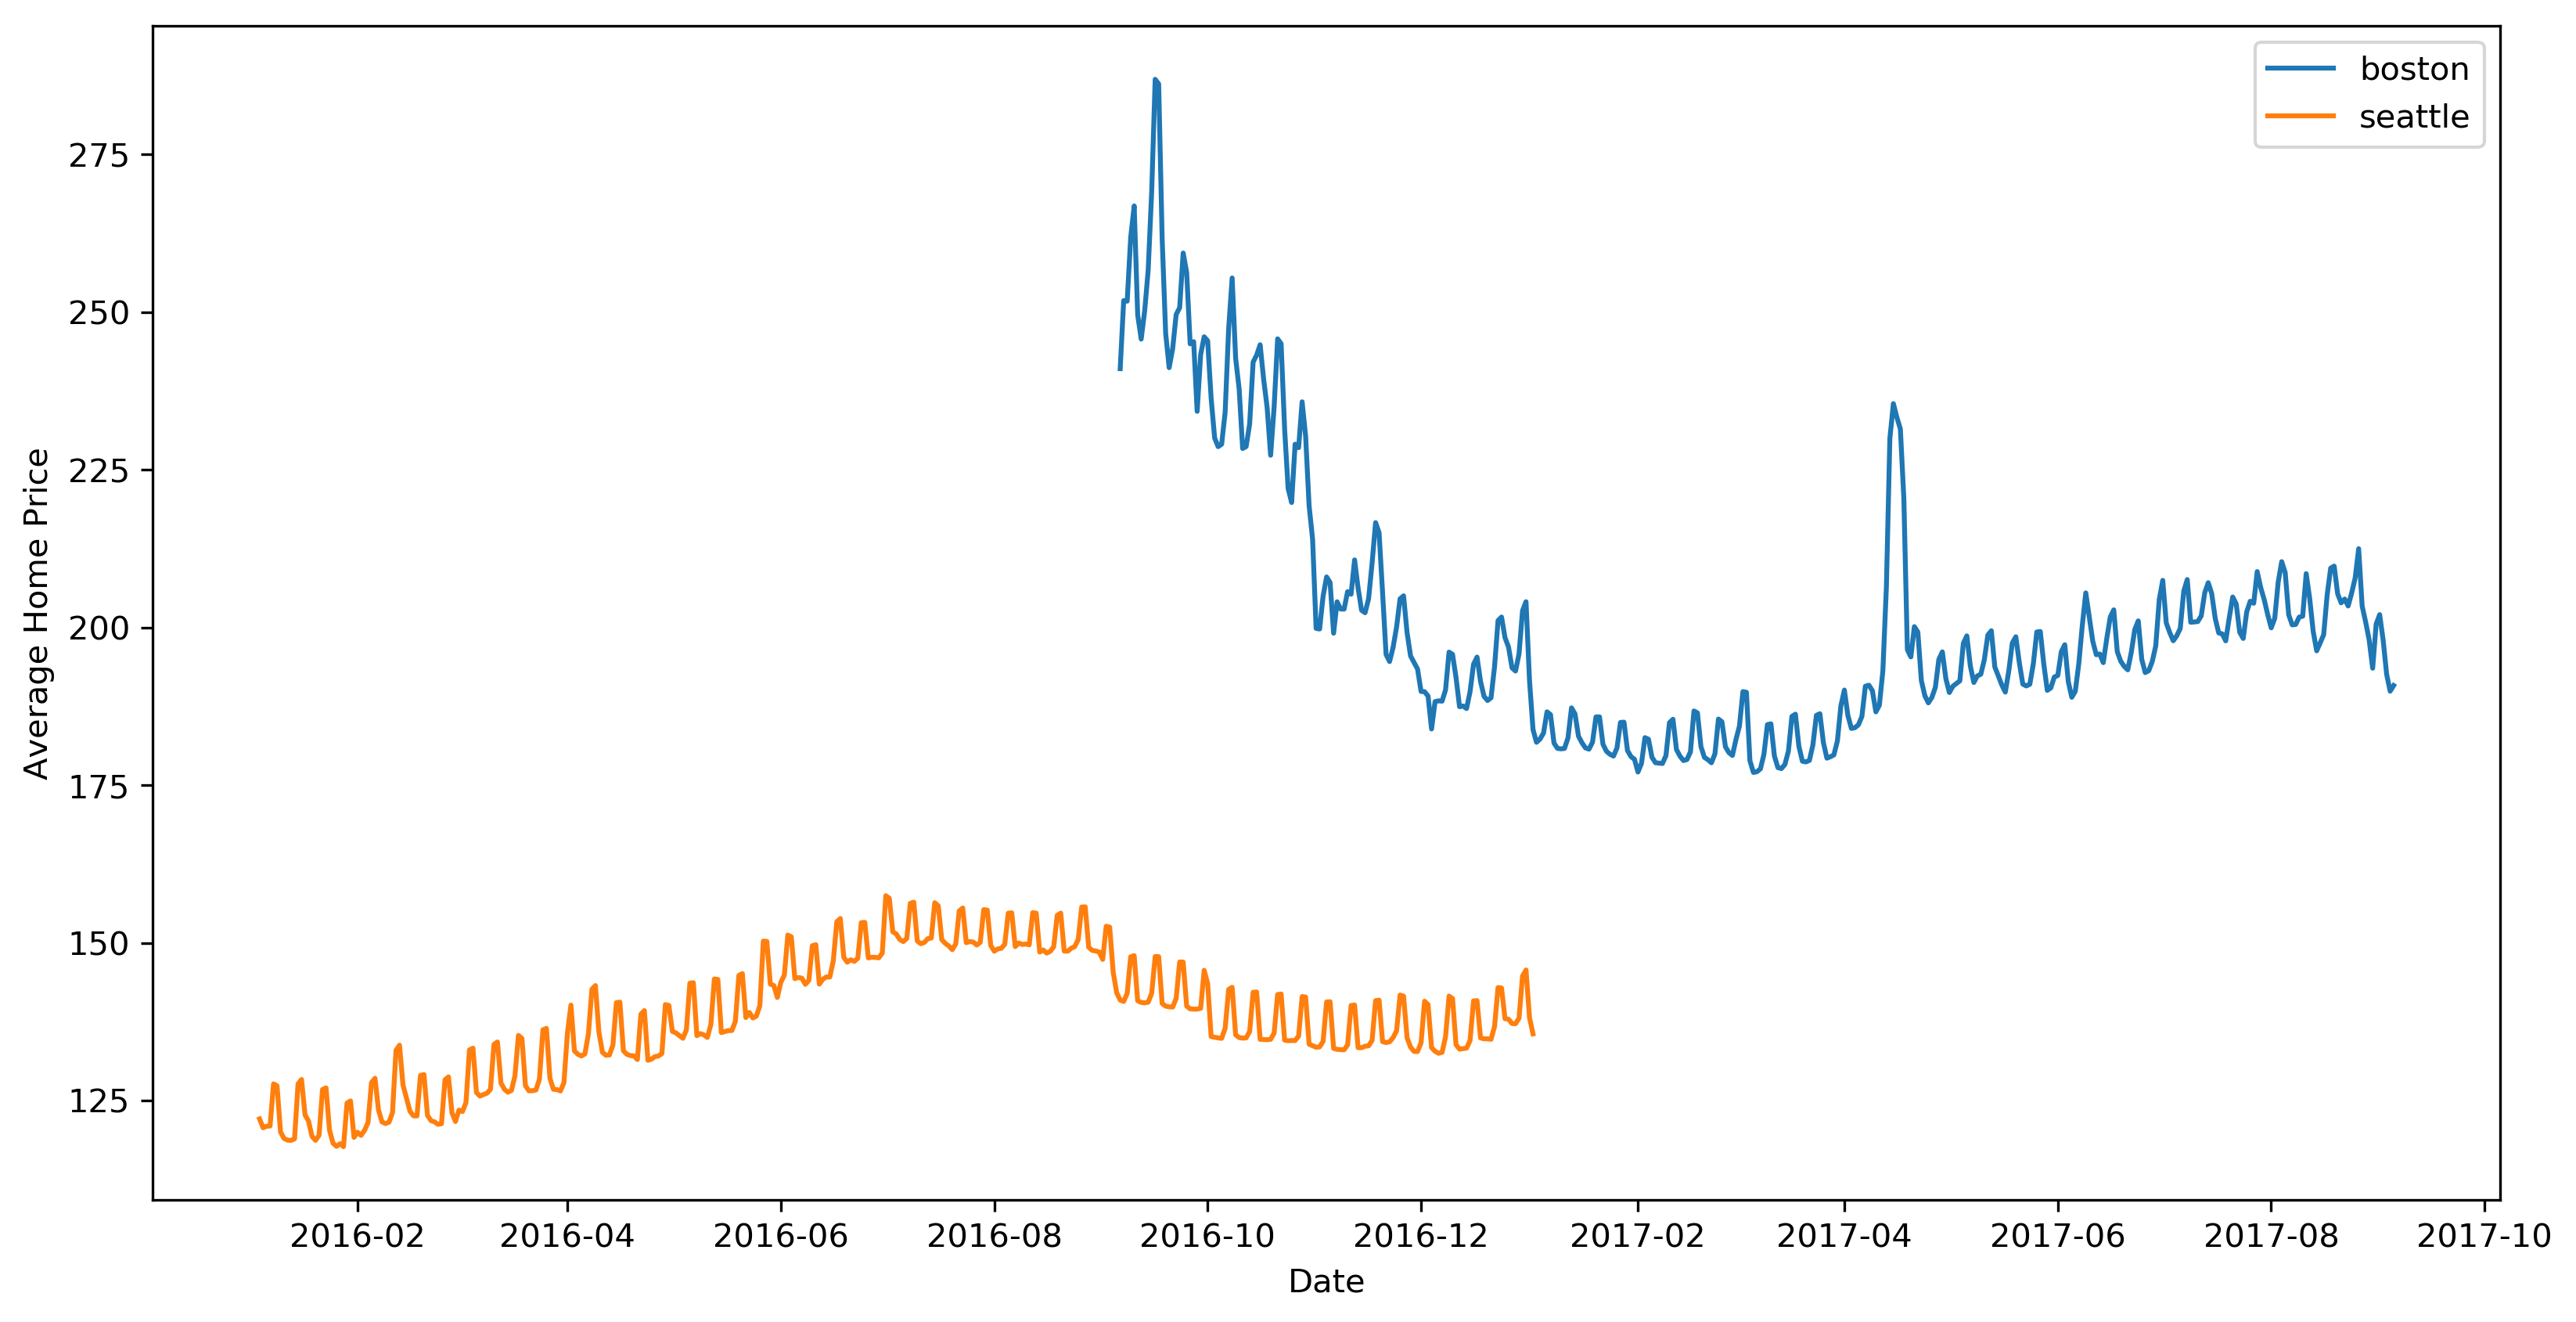

In [5]:
fig = plt.figure(figsize=(10,5),dpi=300)
ax = fig.add_axes([0,0,1,1])
ax.plot(avg_price_date_b['price'], label='boston')
ax.plot(avg_price_date_s['price'], label='seattle')
ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Average Home Price');
fig.savefig('png\PriceVsDate.png', bbox_inches='tight')

In [6]:
'The average price during the Boston Marathon period in 2017 was ${}'.format(int(avg_price_date_b.loc['2017-04-14':'2017-04-17','price'].mean()))

'The average price during the Boston Marathon period in 2017 was $232'

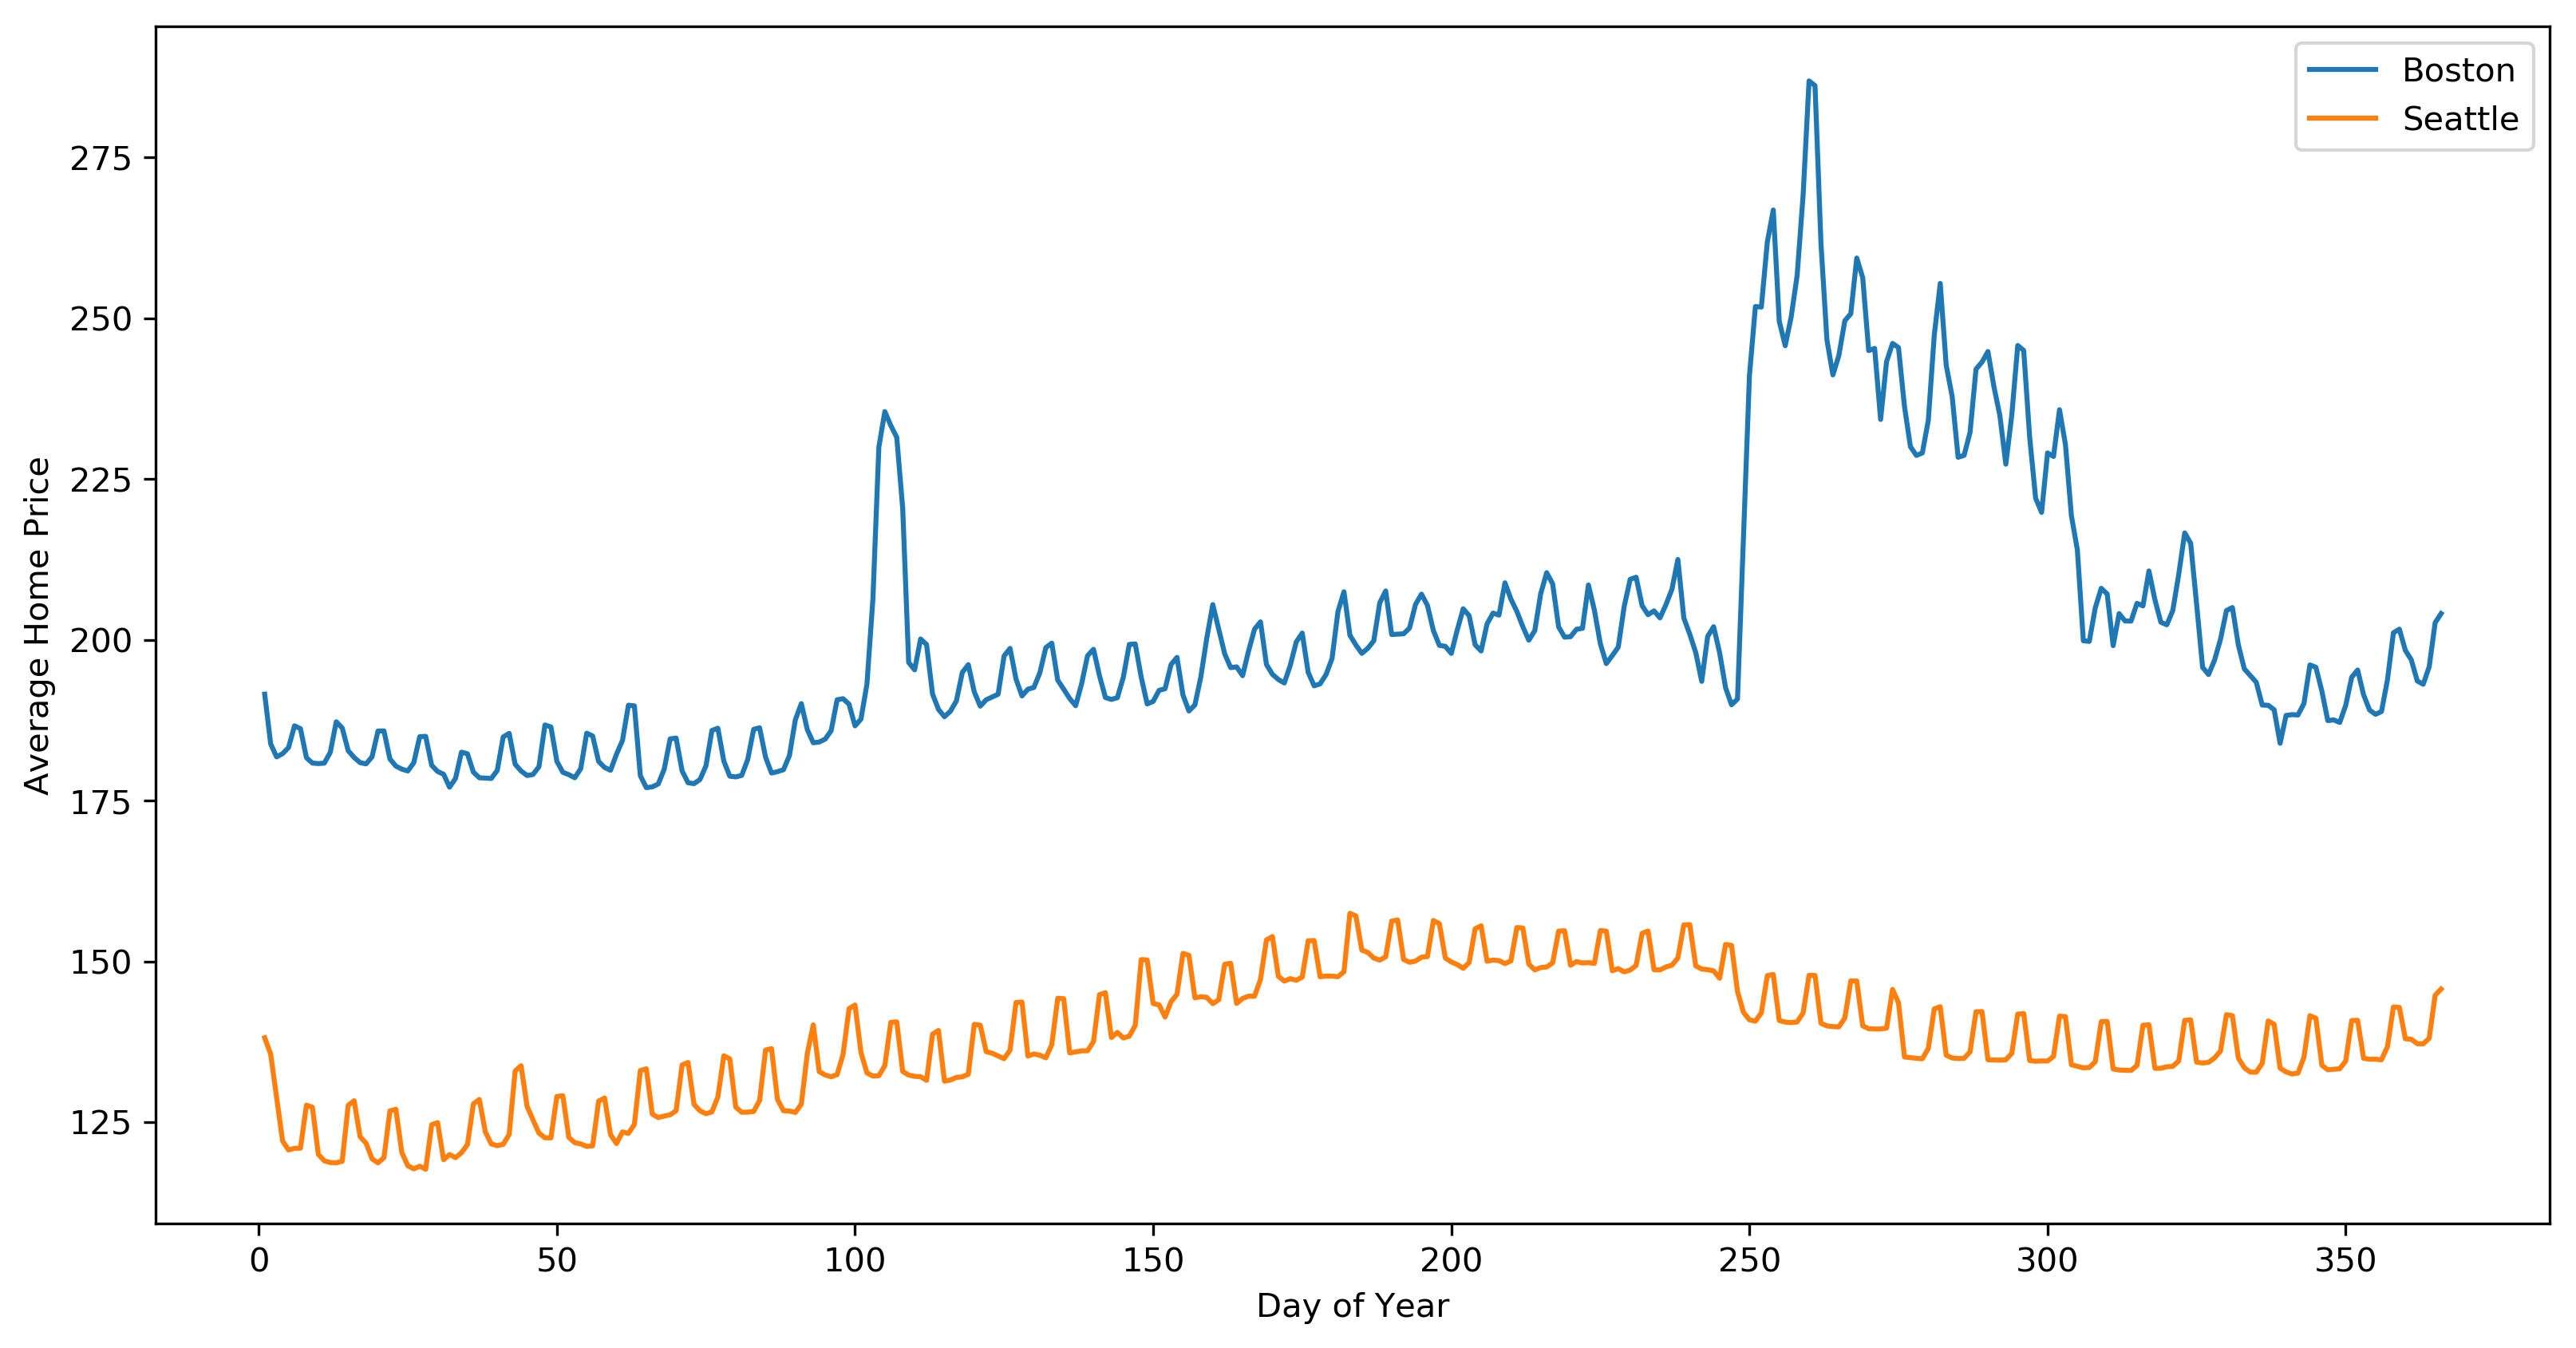

In [7]:
fig2 = plt.figure(figsize=(10,5),dpi=300)
ax2 = fig2.add_axes([0,0,1,1])
ax2.plot(avg_price_day_b['price'], label='Boston')
ax2.plot(avg_price_day_s['price'], label='Seattle');
ax2.legend()
ax2.set_xlabel('Day of Year')
ax2.set_ylabel('Average Home Price')
fig2.savefig('png\PricevsDay.png', bbox_inches='tight')

### Question 2: How is the availability of the properties in both cities throughout the year

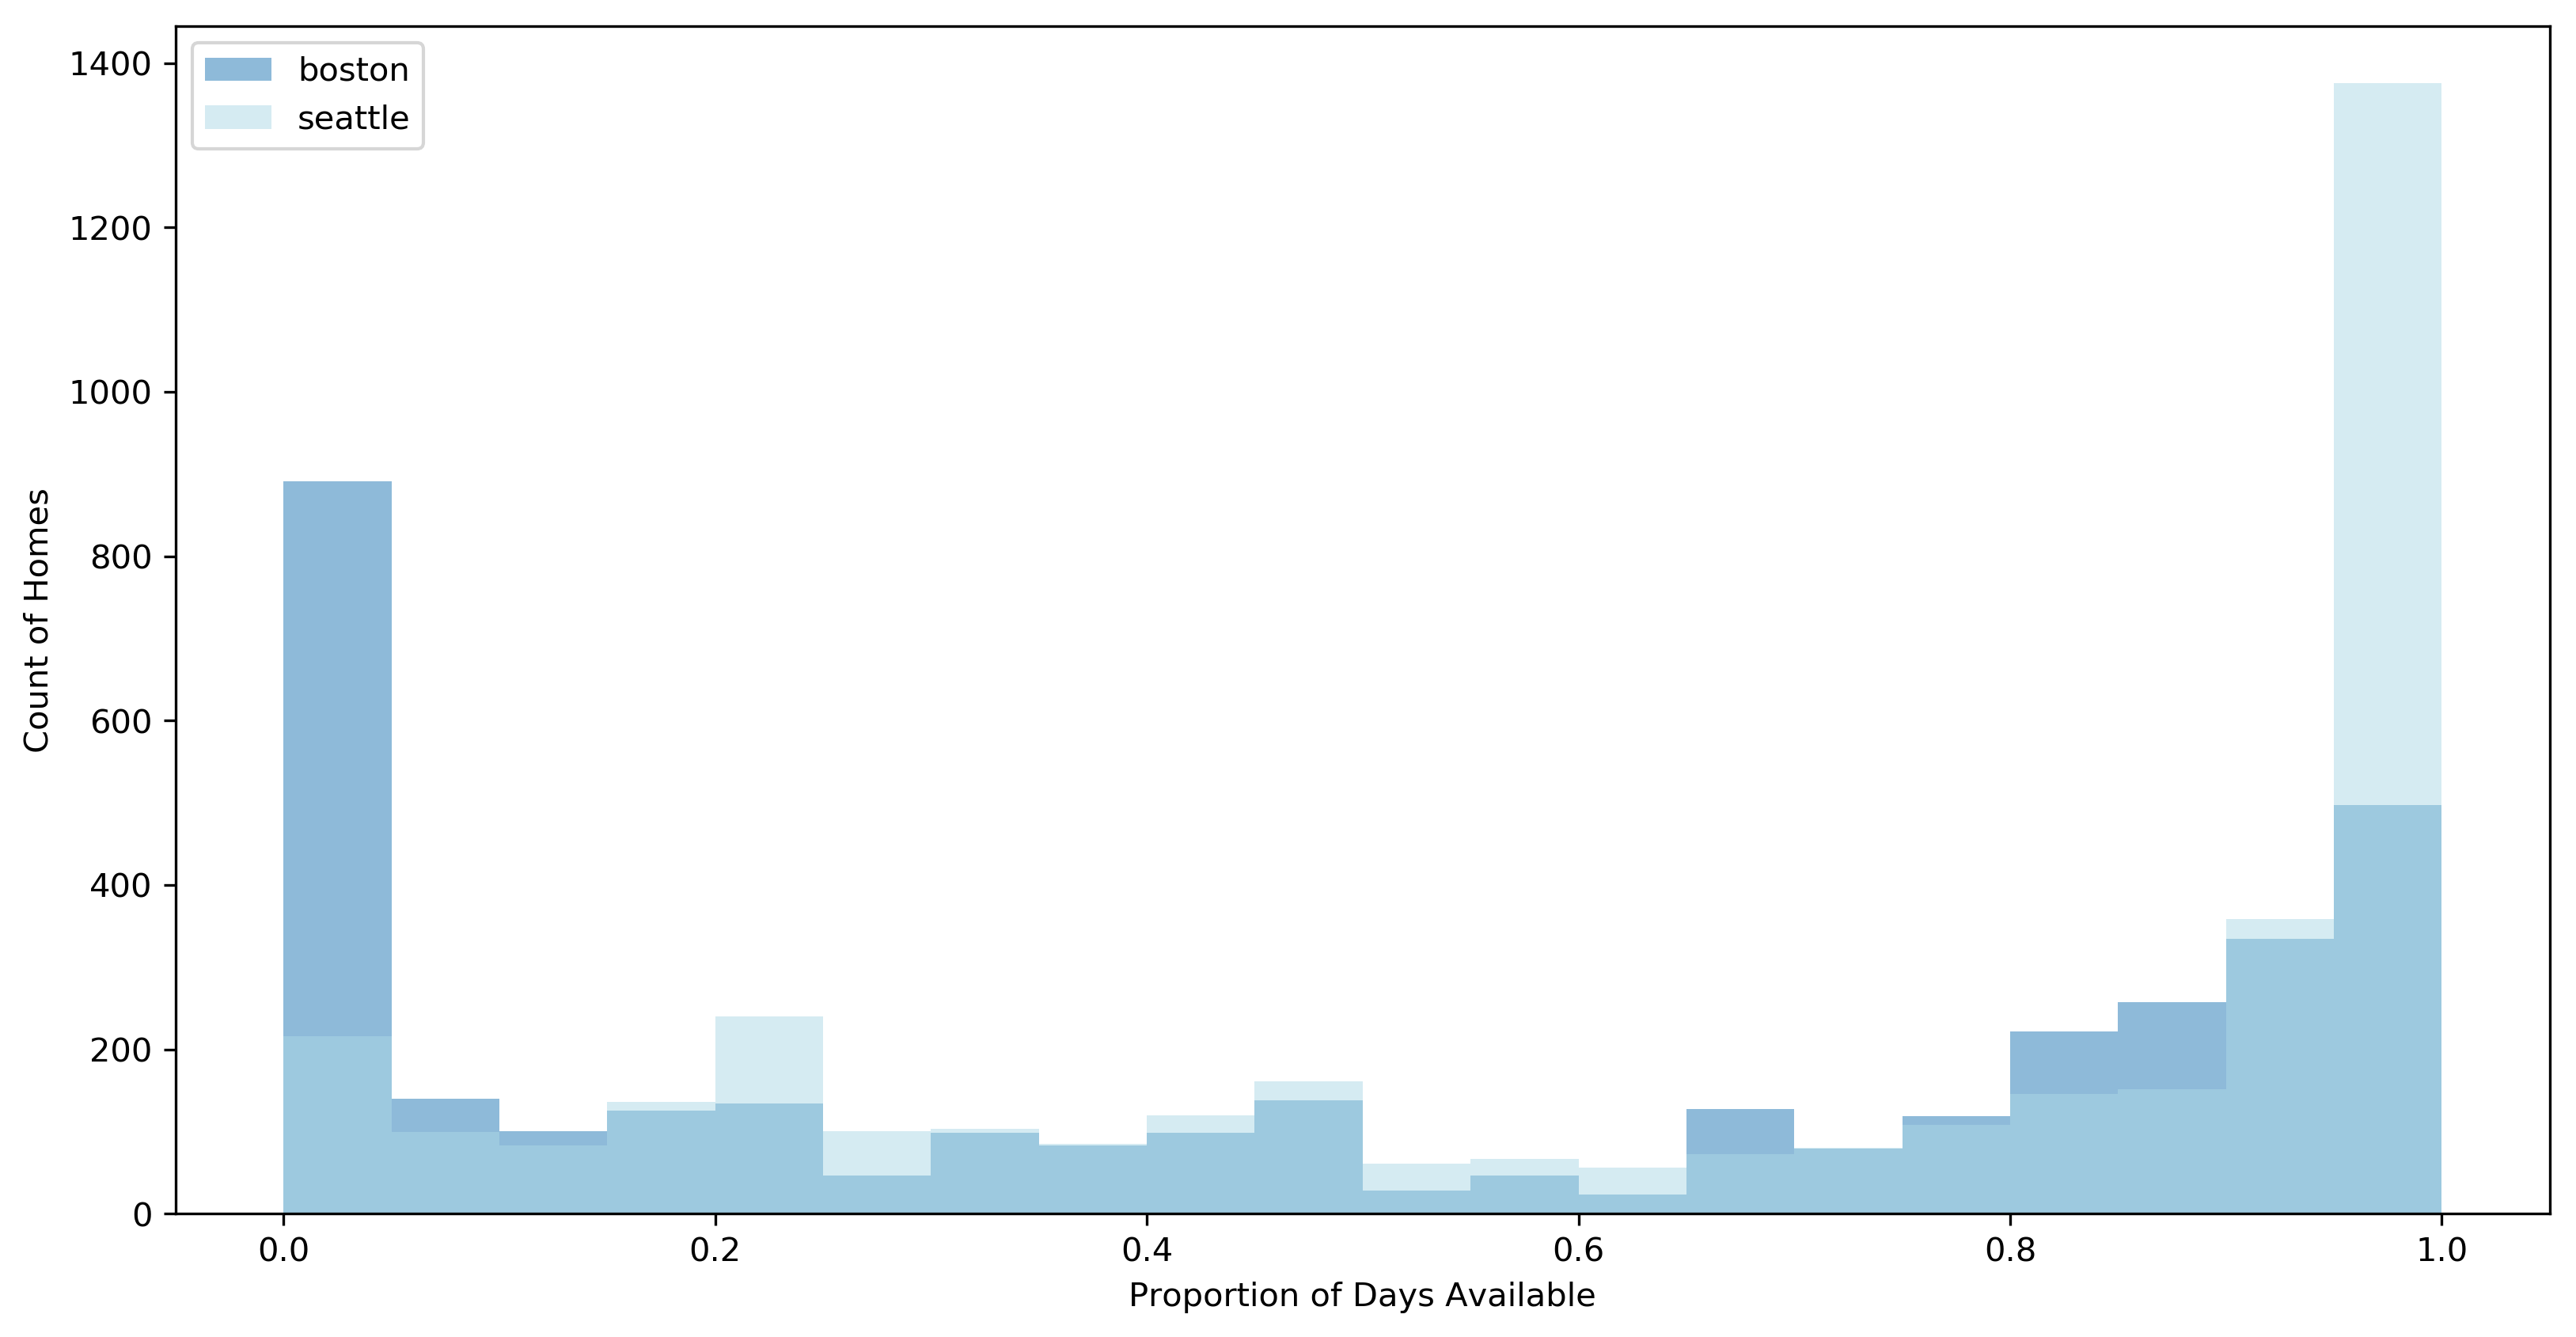

In [8]:
fig3 = plt.figure(figsize=(10,5),dpi=300)
ax3 = fig3.add_axes([0,0,1,1])
ax3.hist(boston_calendar.groupby('listing_id').mean()['available'],bins=20,alpha=0.5, label='boston');
ax3.hist(seattle_calendar.groupby('listing_id').mean()['available'],bins=20,alpha=0.5, label='seattle', color='lightblue')
ax3.legend()
ax3.set_xlabel('Proportion of Days Available')
ax3.set_ylabel('Count of Homes')
fig3.savefig('png\PropDaysAvailable.png', bbox_inches='tight')

In [9]:
'In Boston, at any given time, there is a %{} chance that a house is available, while in Seattle this figure is much higher at %{}'.format(int(boston_calendar['available'].mean()*100), int(seattle_calendar['available'].mean()*100))

'In Boston, at any given time, there is a %49 chance that a house is available, while in Seattle this figure is much higher at %67'

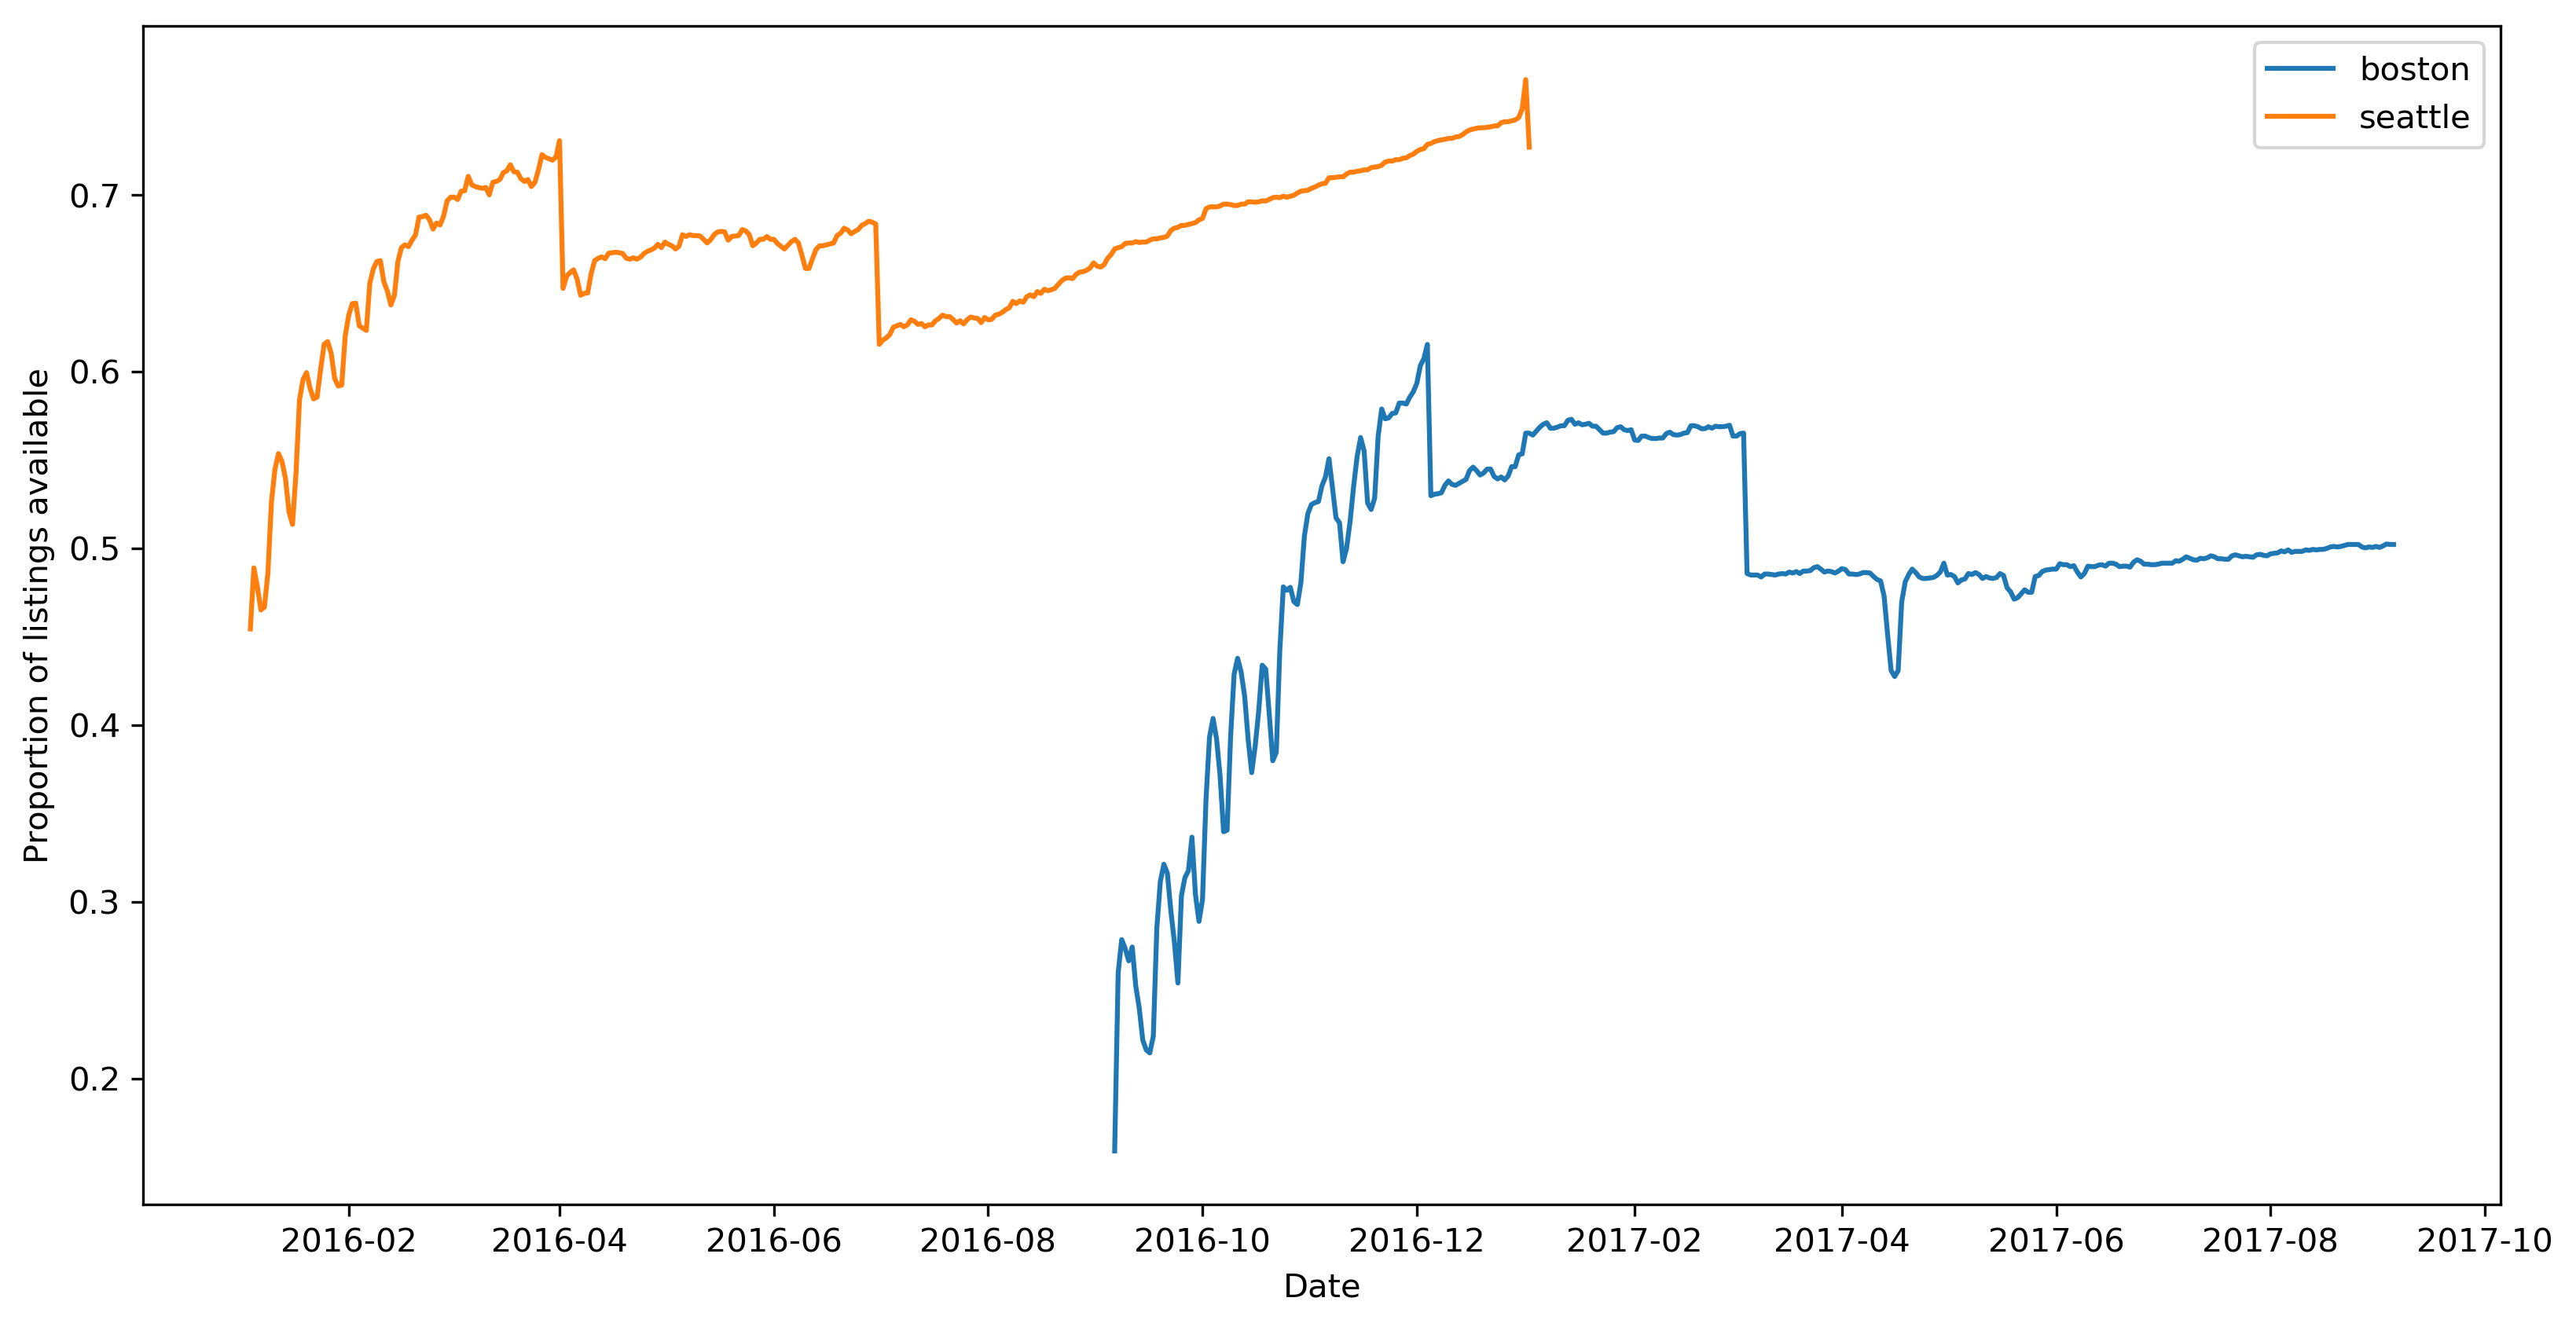

In [10]:
fig4 = plt.figure(figsize=(10,5),dpi=300)
ax4 = fig4.add_axes([0,0,1,1])
ax4.plot(boston_calendar.drop(['listing_id','price','day_of_year'],axis=1).groupby('date').mean(),label='boston')
ax4.plot(seattle_calendar.drop(['listing_id','price','day_of_year'],axis=1).groupby('date').mean(),label='seattle')
ax4.legend()
ax4.set_xlabel('Date')
ax4.set_ylabel('Proportion of listings available')
fig4.savefig('png\ListingsAvailableByDate.png', bbox_inches='tight')

### Question 3: Can we predict the review score from comments using regression? Do the comments of the visitors on a listing give us enough information for us to guess the review score of that listing

In [11]:
# Assess Seattle reviews table
seattle_review.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


In [12]:
# Assess Seattle listings table
seattle_listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [13]:
# Assess Seattle review-specific columns of the reviews table
seattle_listings.loc[:,[column for column in seattle_listings.columns if 'review' in column]].head()

,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month
0,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,4.07
1,43,2013-08-19,2015-12-29,96.0,10.0,10.0,10.0,10.0,10.0,10.0,1.48
2,20,2014-07-30,2015-09-03,97.0,10.0,10.0,10.0,10.0,10.0,10.0,1.15
3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,38,2012-07-10,2015-10-24,92.0,9.0,9.0,10.0,10.0,9.0,9.0,0.89


In [14]:
####  Below I create a reviews dataframe that concatenates all review strings into one per listing. Boston and Seattle data are also merged into one.

In [15]:
reviews = pd.DataFrame(columns=['comments'])

for item in seattle_review['listing_id'].unique():
        reviews.loc[item,'comments'] = seattle_review[seattle_review['listing_id']==item]['comments'].str.cat()

for item in boston_review['listing_id'].unique():
        reviews.loc[item,'comments'] = boston_review[boston_review['listing_id']==item]['comments'].str.cat()
        
review_score_rating = pd.concat([seattle_listings.loc[:,['id','review_scores_rating']],boston_listings.loc[:,['id','review_scores_rating']]])
reviews['review_scores_rating'] = reviews.index.map(review_score_rating.set_index('id')['review_scores_rating'])

In [16]:
# of listings without a valid review score
reviews.isnull().sum()

comments                 0
review_scores_rating    77
dtype: int64

In [17]:
# of listings without a valid review score that have a 'automated host cancellation message'
len([comment for comment in (reviews[reviews.isnull()['review_scores_rating']])['comments'] if 'auto' in comment])

76

## 3. Data Preparation

#### I will be dropping any reviews that have an NA value in either comments or scores for simplicity. There are 77 reviews with na review score, and 76 of them have been auto generated by system due to cancellation by the host.

#### Due to the low number of NA values, dropping these will not affect the data adversely.

In [18]:
reviews.dropna(inplace=True)

In [19]:
def preprocessor(text):
    """Takes in text, removes punctuation and returns it
    
    text (str) : Text to be preprocessed. Punctuation will be removed from the string and string will be returned.
    
    Returns:
    str: Text without any punctuation
    
    """
      
    text = re.sub(r"[^a-zA-Z0-9]"," ", text)
    text = re.sub(r"'","", text)
    return text

stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

## Define tokenizer, splitting text into tokens, while also removing stopwords, applying stemming and lemmatization as well
def tokenizer(text):
    """Splits text into tokens, removes stopwords, lemmatizes and stems, then returns resulting tokens
    
    text (str) : String to be tokenized. Firstly the string will be split into tokens. Then, it will be stripped from stop words.
    Finally, lemmatization and stemming will be applied to each token
    
    Returns:
    list : Tokenized text in list format
    
    """
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token not in stopwords.words('english')]
    tokens = [stemmer.stem(lemmatizer.lemmatize(token)) for token in tokens]
    return tokens

#Initialize Vectorizers
CV = CountVectorizer(stop_words=None, tokenizer=tokenizer, preprocessor=preprocessor, lowercase=True)
TFIDF = TfidfVectorizer(stop_words=None, tokenizer = tokenizer, preprocessor=preprocessor, lowercase=True)

## 4. Modeling

In [20]:
#Initialize TFIDF Vectorizer with custom preprocessor and tokenizer
TFIDF = TfidfVectorizer(stop_words=None, tokenizer = tokenizer, preprocessor=preprocessor, max_features=1000)

#Create intermediate set which contains our train and validation sets, as well as
X_intermediate, X_test, y_intermediate, y_test = train_test_split(reviews['comments'], reviews['review_scores_rating'],
                                                                  shuffle=True,
                                                                  test_size=0.2)
#Set alphas and learning_rates to GridSearch upon for SGDR, XGBR and CatBoostReg
alphas = [1, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]
learning_rates = [1,0.1,0.01,0.001,0.0001,0.00001,0.000001]

kf = KFold(3, shuffle=True, random_state=21)

train_errors_sgdr = {a:[] for a in alphas}
val_errors_sgdr = {a:[] for a in alphas}
train_errors_xgb = {n:[] for n in learning_rates}
val_errors_xgb = {n:[] for n in learning_rates}
train_errors_cat = {n:[] for n in learning_rates}
val_errors_cat = {n:[] for n in learning_rates}


for train_index, val_index in kf.split(X_intermediate, y_intermediate):
    
    X_train, X_val = X_intermediate[X_intermediate.index[train_index]], X_intermediate[X_intermediate.index[val_index]]
    y_train, y_val = y_intermediate[y_intermediate.index[train_index]], y_intermediate[y_intermediate.index[val_index]]
    
    X_train = pd.DataFrame(TFIDF.fit_transform(X_train).toarray(), X_train.index)
    X_val = pd.DataFrame(TFIDF.transform(X_val).toarray(), X_val.index)
    
    #Stochastic Gradient Descent
    for alpha in alphas:
        #instantiate Stochastic Gradient Descent model and fit it
        sgdr = SGDRegressor(alpha=alpha, random_state=21).fit(X_train, y_train)
    
        #calculate errors
        yhat_train = sgdr.predict(X_train)
        yhat_val = sgdr.predict(X_val)
        train_error, val_error = mean_squared_error(y_train, yhat_train), mean_squared_error(y_val, yhat_val)
        train_errors_sgdr[alpha].append(train_error)
        val_errors_sgdr[alpha].append(val_error)
    
    for lr in learning_rates:
        
        # CatBoost Regressor
        cat = CatBoostRegressor(learning_rate=lr,random_seed=21,thread_count=4).fit(X_train, y_train)
        train_error_cat, val_error_cat = mean_squared_error(cat.predict(X_train), y_train), mean_squared_error(cat.predict(X_val), y_val)
        train_errors_cat[lr].append(train_error_cat)
        val_errors_cat[lr].append(val_error_cat)
        
        # XGBoost Regressor
        xgb = XGBRegressor(learning_rate=lr,random_seed=21,n_jobs=-1).fit(X_train, y_train)
        train_error_xgb, val_error_xgb = mean_squared_error(xgb.predict(X_train), y_train), mean_squared_error(xgb.predict(X_val), y_val)
        train_errors_xgb[lr].append(train_error_xgb)
        val_errors_xgb[lr].append(val_error_xgb)

C:\Anaconda3\envs\dsnd\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


0:	learn: 9.7970623	total: 493ms	remaining: 8m 12s
1:	learn: 9.0546874	total: 803ms	remaining: 6m 40s
2:	learn: 8.8015079	total: 1.16s	remaining: 6m 25s
3:	learn: 8.4657836	total: 1.47s	remaining: 6m 5s
4:	learn: 8.3861693	total: 1.77s	remaining: 5m 52s
5:	learn: 8.2250254	total: 2.08s	remaining: 5m 43s
6:	learn: 8.0499233	total: 2.38s	remaining: 5m 38s
7:	learn: 7.4352572	total: 2.7s	remaining: 5m 34s
8:	learn: 7.3385406	total: 3s	remaining: 5m 30s
9:	learn: 7.2984886	total: 3.31s	remaining: 5m 27s
10:	learn: 7.0801970	total: 3.62s	remaining: 5m 25s
11:	learn: 6.9035664	total: 3.94s	remaining: 5m 24s
12:	learn: 6.8635932	total: 4.25s	remaining: 5m 22s
13:	learn: 6.8253940	total: 4.56s	remaining: 5m 20s
14:	learn: 6.7789555	total: 4.86s	remaining: 5m 19s
15:	learn: 6.7551631	total: 5.17s	remaining: 5m 17s
16:	learn: 6.7265992	total: 5.47s	remaining: 5m 16s
17:	learn: 6.6682061	total: 5.78s	remaining: 5m 15s
18:	learn: 6.6378077	total: 6.09s	remaining: 5m 14s
19:	learn: 6.5936037	total:

158:	learn: 4.5103648	total: 49.1s	remaining: 4m 19s
159:	learn: 4.4974753	total: 49.4s	remaining: 4m 19s
160:	learn: 4.4873582	total: 49.7s	remaining: 4m 19s
161:	learn: 4.4738428	total: 50s	remaining: 4m 18s
162:	learn: 4.4603568	total: 50.3s	remaining: 4m 18s
163:	learn: 4.4559328	total: 50.6s	remaining: 4m 18s
164:	learn: 4.4502889	total: 50.9s	remaining: 4m 17s
165:	learn: 4.4472119	total: 51.2s	remaining: 4m 17s
166:	learn: 4.4426672	total: 51.6s	remaining: 4m 17s
167:	learn: 4.4410406	total: 51.9s	remaining: 4m 16s
168:	learn: 4.4369678	total: 52.2s	remaining: 4m 16s
169:	learn: 4.4328946	total: 52.5s	remaining: 4m 16s
170:	learn: 4.4319341	total: 52.8s	remaining: 4m 15s
171:	learn: 4.4294168	total: 53.1s	remaining: 4m 15s
172:	learn: 4.4266421	total: 53.4s	remaining: 4m 15s
173:	learn: 4.4257250	total: 53.7s	remaining: 4m 14s
174:	learn: 4.4174370	total: 54s	remaining: 4m 14s
175:	learn: 4.4164769	total: 54.3s	remaining: 4m 14s
176:	learn: 4.4106793	total: 54.6s	remaining: 4m 1

313:	learn: 3.8216096	total: 1m 36s	remaining: 3m 30s
314:	learn: 3.8151675	total: 1m 36s	remaining: 3m 30s
315:	learn: 3.7992802	total: 1m 37s	remaining: 3m 30s
316:	learn: 3.7960722	total: 1m 37s	remaining: 3m 29s
317:	learn: 3.7938014	total: 1m 37s	remaining: 3m 29s
318:	learn: 3.7910530	total: 1m 38s	remaining: 3m 29s
319:	learn: 3.7898788	total: 1m 38s	remaining: 3m 28s
320:	learn: 3.7873201	total: 1m 38s	remaining: 3m 28s
321:	learn: 3.7806059	total: 1m 38s	remaining: 3m 28s
322:	learn: 3.7798655	total: 1m 39s	remaining: 3m 27s
323:	learn: 3.7796048	total: 1m 39s	remaining: 3m 27s
324:	learn: 3.7785431	total: 1m 39s	remaining: 3m 27s
325:	learn: 3.7776845	total: 1m 40s	remaining: 3m 27s
326:	learn: 3.7764739	total: 1m 40s	remaining: 3m 26s
327:	learn: 3.7716282	total: 1m 40s	remaining: 3m 26s
328:	learn: 3.7706673	total: 1m 41s	remaining: 3m 26s
329:	learn: 3.7695367	total: 1m 41s	remaining: 3m 25s
330:	learn: 3.7686608	total: 1m 41s	remaining: 3m 25s
331:	learn: 3.7680717	total:

467:	learn: 3.2633951	total: 2m 23s	remaining: 2m 43s
468:	learn: 3.2620640	total: 2m 23s	remaining: 2m 42s
469:	learn: 3.2584213	total: 2m 24s	remaining: 2m 42s
470:	learn: 3.2577447	total: 2m 24s	remaining: 2m 42s
471:	learn: 3.2576760	total: 2m 24s	remaining: 2m 41s
472:	learn: 3.2572512	total: 2m 25s	remaining: 2m 41s
473:	learn: 3.2562002	total: 2m 25s	remaining: 2m 41s
474:	learn: 3.2554734	total: 2m 25s	remaining: 2m 40s
475:	learn: 3.2546654	total: 2m 25s	remaining: 2m 40s
476:	learn: 3.2532202	total: 2m 26s	remaining: 2m 40s
477:	learn: 3.2521262	total: 2m 26s	remaining: 2m 40s
478:	learn: 3.2505422	total: 2m 26s	remaining: 2m 39s
479:	learn: 3.2486181	total: 2m 27s	remaining: 2m 39s
480:	learn: 3.2431184	total: 2m 27s	remaining: 2m 39s
481:	learn: 3.2395687	total: 2m 27s	remaining: 2m 38s
482:	learn: 3.2387794	total: 2m 28s	remaining: 2m 38s
483:	learn: 3.2322189	total: 2m 28s	remaining: 2m 38s
484:	learn: 3.2286774	total: 2m 28s	remaining: 2m 37s
485:	learn: 3.2278161	total:

621:	learn: 2.9696620	total: 3m 10s	remaining: 1m 55s
622:	learn: 2.9691816	total: 3m 10s	remaining: 1m 55s
623:	learn: 2.9679166	total: 3m 11s	remaining: 1m 55s
624:	learn: 2.9663927	total: 3m 11s	remaining: 1m 54s
625:	learn: 2.9658696	total: 3m 11s	remaining: 1m 54s
626:	learn: 2.9642761	total: 3m 12s	remaining: 1m 54s
627:	learn: 2.9624538	total: 3m 12s	remaining: 1m 53s
628:	learn: 2.9623049	total: 3m 12s	remaining: 1m 53s
629:	learn: 2.9620110	total: 3m 12s	remaining: 1m 53s
630:	learn: 2.9617270	total: 3m 13s	remaining: 1m 53s
631:	learn: 2.9604652	total: 3m 13s	remaining: 1m 52s
632:	learn: 2.9603161	total: 3m 13s	remaining: 1m 52s
633:	learn: 2.9601859	total: 3m 14s	remaining: 1m 52s
634:	learn: 2.9600268	total: 3m 14s	remaining: 1m 51s
635:	learn: 2.9589561	total: 3m 14s	remaining: 1m 51s
636:	learn: 2.9575838	total: 3m 15s	remaining: 1m 51s
637:	learn: 2.9526850	total: 3m 15s	remaining: 1m 50s
638:	learn: 2.9478712	total: 3m 15s	remaining: 1m 50s
639:	learn: 2.9466425	total:

773:	learn: 2.7691529	total: 3m 57s	remaining: 1m 9s
774:	learn: 2.7663377	total: 3m 57s	remaining: 1m 8s
775:	learn: 2.7637030	total: 3m 57s	remaining: 1m 8s
776:	learn: 2.7634391	total: 3m 58s	remaining: 1m 8s
777:	learn: 2.7549648	total: 3m 58s	remaining: 1m 8s
778:	learn: 2.7538167	total: 3m 58s	remaining: 1m 7s
779:	learn: 2.7514069	total: 3m 59s	remaining: 1m 7s
780:	learn: 2.7511495	total: 3m 59s	remaining: 1m 7s
781:	learn: 2.7502384	total: 3m 59s	remaining: 1m 6s
782:	learn: 2.7500650	total: 4m	remaining: 1m 6s
783:	learn: 2.7487718	total: 4m	remaining: 1m 6s
784:	learn: 2.7473359	total: 4m	remaining: 1m 5s
785:	learn: 2.7458325	total: 4m	remaining: 1m 5s
786:	learn: 2.7455465	total: 4m 1s	remaining: 1m 5s
787:	learn: 2.7452947	total: 4m 1s	remaining: 1m 4s
788:	learn: 2.7452612	total: 4m 1s	remaining: 1m 4s
789:	learn: 2.7401677	total: 4m 2s	remaining: 1m 4s
790:	learn: 2.7386777	total: 4m 2s	remaining: 1m 4s
791:	learn: 2.7384820	total: 4m 2s	remaining: 1m 3s
792:	learn: 2.7

930:	learn: 2.5621220	total: 4m 45s	remaining: 21.1s
931:	learn: 2.5606676	total: 4m 45s	remaining: 20.8s
932:	learn: 2.5606502	total: 4m 45s	remaining: 20.5s
933:	learn: 2.5605352	total: 4m 46s	remaining: 20.2s
934:	learn: 2.5578701	total: 4m 46s	remaining: 19.9s
935:	learn: 2.5559534	total: 4m 46s	remaining: 19.6s
936:	learn: 2.5557555	total: 4m 46s	remaining: 19.3s
937:	learn: 2.5551899	total: 4m 47s	remaining: 19s
938:	learn: 2.5548751	total: 4m 47s	remaining: 18.7s
939:	learn: 2.5539940	total: 4m 47s	remaining: 18.4s
940:	learn: 2.5515996	total: 4m 48s	remaining: 18.1s
941:	learn: 2.5513207	total: 4m 48s	remaining: 17.8s
942:	learn: 2.5511029	total: 4m 48s	remaining: 17.5s
943:	learn: 2.5510720	total: 4m 49s	remaining: 17.1s
944:	learn: 2.5489847	total: 4m 49s	remaining: 16.8s
945:	learn: 2.5489149	total: 4m 49s	remaining: 16.5s
946:	learn: 2.5481340	total: 4m 50s	remaining: 16.2s
947:	learn: 2.5464084	total: 4m 50s	remaining: 15.9s
948:	learn: 2.5456302	total: 4m 50s	remaining: 1

88:	learn: 6.3007860	total: 27.6s	remaining: 4m 43s
89:	learn: 6.2949270	total: 27.9s	remaining: 4m 42s
90:	learn: 6.2860718	total: 28.3s	remaining: 4m 42s
91:	learn: 6.2702321	total: 28.6s	remaining: 4m 41s
92:	learn: 6.2595456	total: 28.9s	remaining: 4m 41s
93:	learn: 6.2045357	total: 29.2s	remaining: 4m 41s
94:	learn: 6.1649778	total: 29.5s	remaining: 4m 40s
95:	learn: 6.1334038	total: 29.8s	remaining: 4m 40s
96:	learn: 6.1056787	total: 30.1s	remaining: 4m 40s
97:	learn: 6.0960946	total: 30.4s	remaining: 4m 39s
98:	learn: 6.0537140	total: 30.7s	remaining: 4m 39s
99:	learn: 6.0380770	total: 31s	remaining: 4m 39s
100:	learn: 6.0145479	total: 31.3s	remaining: 4m 38s
101:	learn: 5.9849363	total: 31.6s	remaining: 4m 38s
102:	learn: 5.9710074	total: 31.9s	remaining: 4m 38s
103:	learn: 5.9605977	total: 32.3s	remaining: 4m 37s
104:	learn: 5.9452453	total: 32.6s	remaining: 4m 37s
105:	learn: 5.9389881	total: 32.9s	remaining: 4m 37s
106:	learn: 5.9074314	total: 33.2s	remaining: 4m 36s
107:	le

244:	learn: 4.7396517	total: 1m 15s	remaining: 3m 52s
245:	learn: 4.7373674	total: 1m 15s	remaining: 3m 52s
246:	learn: 4.7308175	total: 1m 16s	remaining: 3m 51s
247:	learn: 4.7297785	total: 1m 16s	remaining: 3m 51s
248:	learn: 4.7288902	total: 1m 16s	remaining: 3m 51s
249:	learn: 4.7247702	total: 1m 16s	remaining: 3m 50s
250:	learn: 4.7229966	total: 1m 17s	remaining: 3m 50s
251:	learn: 4.7174527	total: 1m 17s	remaining: 3m 50s
252:	learn: 4.7146690	total: 1m 17s	remaining: 3m 49s
253:	learn: 4.7109135	total: 1m 18s	remaining: 3m 49s
254:	learn: 4.7072114	total: 1m 18s	remaining: 3m 49s
255:	learn: 4.7035922	total: 1m 18s	remaining: 3m 49s
256:	learn: 4.6960806	total: 1m 19s	remaining: 3m 48s
257:	learn: 4.6942537	total: 1m 19s	remaining: 3m 48s
258:	learn: 4.6919966	total: 1m 19s	remaining: 3m 48s
259:	learn: 4.6899615	total: 1m 20s	remaining: 3m 47s
260:	learn: 4.6875115	total: 1m 20s	remaining: 3m 47s
261:	learn: 4.6815098	total: 1m 20s	remaining: 3m 47s
262:	learn: 4.6740209	total:

397:	learn: 4.2824356	total: 2m 2s	remaining: 3m 4s
398:	learn: 4.2811606	total: 2m 2s	remaining: 3m 4s
399:	learn: 4.2786914	total: 2m 2s	remaining: 3m 4s
400:	learn: 4.2747539	total: 2m 3s	remaining: 3m 3s
401:	learn: 4.2700472	total: 2m 3s	remaining: 3m 3s
402:	learn: 4.2696266	total: 2m 3s	remaining: 3m 3s
403:	learn: 4.2693833	total: 2m 3s	remaining: 3m 2s
404:	learn: 4.2681239	total: 2m 4s	remaining: 3m 2s
405:	learn: 4.2657802	total: 2m 4s	remaining: 3m 2s
406:	learn: 4.2642694	total: 2m 4s	remaining: 3m 1s
407:	learn: 4.2634687	total: 2m 5s	remaining: 3m 1s
408:	learn: 4.2629051	total: 2m 5s	remaining: 3m 1s
409:	learn: 4.2622546	total: 2m 5s	remaining: 3m
410:	learn: 4.2607814	total: 2m 6s	remaining: 3m
411:	learn: 4.2558939	total: 2m 6s	remaining: 3m
412:	learn: 4.2449547	total: 2m 6s	remaining: 3m
413:	learn: 4.2429174	total: 2m 6s	remaining: 2m 59s
414:	learn: 4.2425660	total: 2m 7s	remaining: 2m 59s
415:	learn: 4.2395678	total: 2m 7s	remaining: 2m 59s
416:	learn: 4.2374187

550:	learn: 4.0041917	total: 2m 48s	remaining: 2m 17s
551:	learn: 4.0040533	total: 2m 48s	remaining: 2m 17s
552:	learn: 4.0034723	total: 2m 49s	remaining: 2m 16s
553:	learn: 4.0028442	total: 2m 49s	remaining: 2m 16s
554:	learn: 4.0027674	total: 2m 49s	remaining: 2m 16s
555:	learn: 3.9985097	total: 2m 50s	remaining: 2m 15s
556:	learn: 3.9968815	total: 2m 50s	remaining: 2m 15s
557:	learn: 3.9964388	total: 2m 50s	remaining: 2m 15s
558:	learn: 3.9963221	total: 2m 51s	remaining: 2m 15s
559:	learn: 3.9936320	total: 2m 51s	remaining: 2m 14s
560:	learn: 3.9934797	total: 2m 51s	remaining: 2m 14s
561:	learn: 3.9929523	total: 2m 52s	remaining: 2m 14s
562:	learn: 3.9922301	total: 2m 52s	remaining: 2m 13s
563:	learn: 3.9903578	total: 2m 52s	remaining: 2m 13s
564:	learn: 3.9894707	total: 2m 53s	remaining: 2m 13s
565:	learn: 3.9885829	total: 2m 53s	remaining: 2m 12s
566:	learn: 3.9878613	total: 2m 53s	remaining: 2m 12s
567:	learn: 3.9863892	total: 2m 53s	remaining: 2m 12s
568:	learn: 3.9826815	total:

704:	learn: 3.8634977	total: 3m 35s	remaining: 1m 30s
705:	learn: 3.8632644	total: 3m 35s	remaining: 1m 29s
706:	learn: 3.8630777	total: 3m 36s	remaining: 1m 29s
707:	learn: 3.8628759	total: 3m 36s	remaining: 1m 29s
708:	learn: 3.8628445	total: 3m 36s	remaining: 1m 28s
709:	learn: 3.8617656	total: 3m 36s	remaining: 1m 28s
710:	learn: 3.8605558	total: 3m 37s	remaining: 1m 28s
711:	learn: 3.8604070	total: 3m 37s	remaining: 1m 28s
712:	learn: 3.8597932	total: 3m 37s	remaining: 1m 27s
713:	learn: 3.8597560	total: 3m 38s	remaining: 1m 27s
714:	learn: 3.8592179	total: 3m 38s	remaining: 1m 27s
715:	learn: 3.8561760	total: 3m 38s	remaining: 1m 26s
716:	learn: 3.8561035	total: 3m 39s	remaining: 1m 26s
717:	learn: 3.8546747	total: 3m 39s	remaining: 1m 26s
718:	learn: 3.8545046	total: 3m 39s	remaining: 1m 25s
719:	learn: 3.8528445	total: 3m 40s	remaining: 1m 25s
720:	learn: 3.8527573	total: 3m 40s	remaining: 1m 25s
721:	learn: 3.8516927	total: 3m 40s	remaining: 1m 24s
722:	learn: 3.8509087	total:

859:	learn: 3.7087779	total: 4m 22s	remaining: 42.7s
860:	learn: 3.7082272	total: 4m 22s	remaining: 42.4s
861:	learn: 3.7063910	total: 4m 23s	remaining: 42.1s
862:	learn: 3.7059919	total: 4m 23s	remaining: 41.8s
863:	learn: 3.7045372	total: 4m 23s	remaining: 41.5s
864:	learn: 3.7033110	total: 4m 23s	remaining: 41.2s
865:	learn: 3.7032705	total: 4m 24s	remaining: 40.9s
866:	learn: 3.7032541	total: 4m 24s	remaining: 40.6s
867:	learn: 3.7025787	total: 4m 24s	remaining: 40.3s
868:	learn: 3.7007257	total: 4m 25s	remaining: 40s
869:	learn: 3.7003410	total: 4m 25s	remaining: 39.7s
870:	learn: 3.6975671	total: 4m 25s	remaining: 39.4s
871:	learn: 3.6955670	total: 4m 26s	remaining: 39.1s
872:	learn: 3.6954529	total: 4m 26s	remaining: 38.8s
873:	learn: 3.6902097	total: 4m 26s	remaining: 38.4s
874:	learn: 3.6890874	total: 4m 27s	remaining: 38.1s
875:	learn: 3.6884672	total: 4m 27s	remaining: 37.8s
876:	learn: 3.6881906	total: 4m 27s	remaining: 37.5s
877:	learn: 3.6870366	total: 4m 27s	remaining: 3

15:	learn: 80.1705403	total: 5.03s	remaining: 5m 9s
16:	learn: 79.3951711	total: 5.34s	remaining: 5m 8s
17:	learn: 78.6236251	total: 5.65s	remaining: 5m 8s
18:	learn: 77.8585424	total: 5.96s	remaining: 5m 7s
19:	learn: 77.1012306	total: 6.27s	remaining: 5m 7s
20:	learn: 76.3538588	total: 6.58s	remaining: 5m 6s
21:	learn: 75.6144305	total: 6.89s	remaining: 5m 6s
22:	learn: 74.8813017	total: 7.2s	remaining: 5m 5s
23:	learn: 74.1593711	total: 7.51s	remaining: 5m 5s
24:	learn: 73.4460428	total: 7.82s	remaining: 5m 4s
25:	learn: 72.7298635	total: 8.12s	remaining: 5m 4s
26:	learn: 72.0318095	total: 8.45s	remaining: 5m 4s
27:	learn: 71.3353199	total: 8.75s	remaining: 5m 3s
28:	learn: 70.6440675	total: 9.06s	remaining: 5m 3s
29:	learn: 69.9588309	total: 9.36s	remaining: 5m 2s
30:	learn: 69.2754010	total: 9.66s	remaining: 5m 2s
31:	learn: 68.6106645	total: 9.98s	remaining: 5m 1s
32:	learn: 67.9407488	total: 10.3s	remaining: 5m 1s
33:	learn: 67.2904067	total: 10.6s	remaining: 5m
34:	learn: 66.64

170:	learn: 18.9814892	total: 52.8s	remaining: 4m 15s
171:	learn: 18.8262507	total: 53.1s	remaining: 4m 15s
172:	learn: 18.6741205	total: 53.4s	remaining: 4m 15s
173:	learn: 18.5214990	total: 53.7s	remaining: 4m 14s
174:	learn: 18.3714176	total: 54s	remaining: 4m 14s
175:	learn: 18.2231447	total: 54.3s	remaining: 4m 14s
176:	learn: 18.0763743	total: 54.6s	remaining: 4m 14s
177:	learn: 17.9312711	total: 54.9s	remaining: 4m 13s
178:	learn: 17.7885382	total: 55.2s	remaining: 4m 13s
179:	learn: 17.6471031	total: 55.6s	remaining: 4m 13s
180:	learn: 17.5074696	total: 55.9s	remaining: 4m 12s
181:	learn: 17.3694772	total: 56.2s	remaining: 4m 12s
182:	learn: 17.2327343	total: 56.5s	remaining: 4m 12s
183:	learn: 17.0980718	total: 56.8s	remaining: 4m 11s
184:	learn: 16.9648999	total: 57.1s	remaining: 4m 11s
185:	learn: 16.8346725	total: 57.4s	remaining: 4m 11s
186:	learn: 16.7044843	total: 57.7s	remaining: 4m 10s
187:	learn: 16.5758812	total: 58s	remaining: 4m 10s
188:	learn: 16.4492221	total: 58

322:	learn: 8.3724303	total: 1m 39s	remaining: 3m 29s
323:	learn: 8.3496813	total: 1m 40s	remaining: 3m 28s
324:	learn: 8.3298354	total: 1m 40s	remaining: 3m 28s
325:	learn: 8.3098047	total: 1m 40s	remaining: 3m 28s
326:	learn: 8.2912632	total: 1m 40s	remaining: 3m 27s
327:	learn: 8.2692837	total: 1m 41s	remaining: 3m 27s
328:	learn: 8.2505500	total: 1m 41s	remaining: 3m 27s
329:	learn: 8.2316263	total: 1m 41s	remaining: 3m 26s
330:	learn: 8.2111606	total: 1m 42s	remaining: 3m 26s
331:	learn: 8.1906279	total: 1m 42s	remaining: 3m 26s
332:	learn: 8.1707095	total: 1m 42s	remaining: 3m 26s
333:	learn: 8.1515101	total: 1m 43s	remaining: 3m 25s
334:	learn: 8.1350523	total: 1m 43s	remaining: 3m 25s
335:	learn: 8.1166163	total: 1m 43s	remaining: 3m 25s
336:	learn: 8.1012515	total: 1m 44s	remaining: 3m 24s
337:	learn: 8.0802660	total: 1m 44s	remaining: 3m 24s
338:	learn: 8.0656589	total: 1m 44s	remaining: 3m 24s
339:	learn: 8.0491610	total: 1m 45s	remaining: 3m 24s
340:	learn: 8.0298301	total:

476:	learn: 6.8724420	total: 2m 27s	remaining: 2m 41s
477:	learn: 6.8674818	total: 2m 27s	remaining: 2m 41s
478:	learn: 6.8611477	total: 2m 28s	remaining: 2m 41s
479:	learn: 6.8576415	total: 2m 28s	remaining: 2m 40s
480:	learn: 6.8520713	total: 2m 28s	remaining: 2m 40s
481:	learn: 6.8456491	total: 2m 29s	remaining: 2m 40s
482:	learn: 6.8425380	total: 2m 29s	remaining: 2m 39s
483:	learn: 6.8383470	total: 2m 29s	remaining: 2m 39s
484:	learn: 6.8328402	total: 2m 30s	remaining: 2m 39s
485:	learn: 6.8288145	total: 2m 30s	remaining: 2m 39s
486:	learn: 6.8262377	total: 2m 30s	remaining: 2m 38s
487:	learn: 6.8232622	total: 2m 30s	remaining: 2m 38s
488:	learn: 6.8192216	total: 2m 31s	remaining: 2m 38s
489:	learn: 6.8137503	total: 2m 31s	remaining: 2m 37s
490:	learn: 6.8110776	total: 2m 31s	remaining: 2m 37s
491:	learn: 6.8079368	total: 2m 32s	remaining: 2m 37s
492:	learn: 6.8041782	total: 2m 32s	remaining: 2m 36s
493:	learn: 6.8003979	total: 2m 32s	remaining: 2m 36s
494:	learn: 6.7975045	total:

630:	learn: 6.4457505	total: 3m 14s	remaining: 1m 53s
631:	learn: 6.4456186	total: 3m 15s	remaining: 1m 53s
632:	learn: 6.4441361	total: 3m 15s	remaining: 1m 53s
633:	learn: 6.4435162	total: 3m 15s	remaining: 1m 52s
634:	learn: 6.4424057	total: 3m 15s	remaining: 1m 52s
635:	learn: 6.4411194	total: 3m 16s	remaining: 1m 52s
636:	learn: 6.4393956	total: 3m 16s	remaining: 1m 51s
637:	learn: 6.4382828	total: 3m 16s	remaining: 1m 51s
638:	learn: 6.4361225	total: 3m 17s	remaining: 1m 51s
639:	learn: 6.4340026	total: 3m 17s	remaining: 1m 51s
640:	learn: 6.4321706	total: 3m 17s	remaining: 1m 50s
641:	learn: 6.4300146	total: 3m 18s	remaining: 1m 50s
642:	learn: 6.4281308	total: 3m 18s	remaining: 1m 50s
643:	learn: 6.4267298	total: 3m 18s	remaining: 1m 49s
644:	learn: 6.4253753	total: 3m 18s	remaining: 1m 49s
645:	learn: 6.4235390	total: 3m 19s	remaining: 1m 49s
646:	learn: 6.4211428	total: 3m 19s	remaining: 1m 48s
647:	learn: 6.4199230	total: 3m 19s	remaining: 1m 48s
648:	learn: 6.4176367	total:

783:	learn: 6.2367470	total: 4m	remaining: 1m 6s
784:	learn: 6.2360265	total: 4m 1s	remaining: 1m 6s
785:	learn: 6.2355977	total: 4m 1s	remaining: 1m 5s
786:	learn: 6.2334173	total: 4m 1s	remaining: 1m 5s
787:	learn: 6.2326267	total: 4m 2s	remaining: 1m 5s
788:	learn: 6.2314216	total: 4m 2s	remaining: 1m 4s
789:	learn: 6.2306056	total: 4m 2s	remaining: 1m 4s
790:	learn: 6.2297195	total: 4m 3s	remaining: 1m 4s
791:	learn: 6.2285775	total: 4m 3s	remaining: 1m 3s
792:	learn: 6.2273483	total: 4m 3s	remaining: 1m 3s
793:	learn: 6.2265865	total: 4m 3s	remaining: 1m 3s
794:	learn: 6.2250288	total: 4m 4s	remaining: 1m 2s
795:	learn: 6.2243277	total: 4m 4s	remaining: 1m 2s
796:	learn: 6.2237468	total: 4m 4s	remaining: 1m 2s
797:	learn: 6.2208342	total: 4m 5s	remaining: 1m 2s
798:	learn: 6.2192222	total: 4m 5s	remaining: 1m 1s
799:	learn: 6.2189566	total: 4m 5s	remaining: 1m 1s
800:	learn: 6.2161173	total: 4m 6s	remaining: 1m 1s
801:	learn: 6.2155927	total: 4m 6s	remaining: 1m
802:	learn: 6.2150

940:	learn: 6.0048929	total: 4m 48s	remaining: 18.1s
941:	learn: 6.0024017	total: 4m 48s	remaining: 17.8s
942:	learn: 5.9999034	total: 4m 49s	remaining: 17.5s
943:	learn: 5.9988713	total: 4m 49s	remaining: 17.2s
944:	learn: 5.9976769	total: 4m 49s	remaining: 16.9s
945:	learn: 5.9963082	total: 4m 49s	remaining: 16.6s
946:	learn: 5.9945429	total: 4m 50s	remaining: 16.2s
947:	learn: 5.9920071	total: 4m 50s	remaining: 15.9s
948:	learn: 5.9907400	total: 4m 50s	remaining: 15.6s
949:	learn: 5.9886299	total: 4m 51s	remaining: 15.3s
950:	learn: 5.9852421	total: 4m 51s	remaining: 15s
951:	learn: 5.9826117	total: 4m 51s	remaining: 14.7s
952:	learn: 5.9804926	total: 4m 52s	remaining: 14.4s
953:	learn: 5.9787247	total: 4m 52s	remaining: 14.1s
954:	learn: 5.9762972	total: 4m 52s	remaining: 13.8s
955:	learn: 5.9727937	total: 4m 53s	remaining: 13.5s
956:	learn: 5.9715887	total: 4m 53s	remaining: 13.2s
957:	learn: 5.9707107	total: 4m 53s	remaining: 12.9s
958:	learn: 5.9681258	total: 4m 53s	remaining: 1

97:	learn: 85.2011146	total: 30.4s	remaining: 4m 39s
98:	learn: 85.1180092	total: 30.7s	remaining: 4m 39s
99:	learn: 85.0348752	total: 31s	remaining: 4m 39s
100:	learn: 84.9518833	total: 31.3s	remaining: 4m 38s
101:	learn: 84.8697354	total: 31.6s	remaining: 4m 38s
102:	learn: 84.7867073	total: 32s	remaining: 4m 38s
103:	learn: 84.7039781	total: 32.3s	remaining: 4m 38s
104:	learn: 84.6212245	total: 32.6s	remaining: 4m 37s
105:	learn: 84.5389676	total: 33s	remaining: 4m 37s
106:	learn: 84.4573361	total: 33.3s	remaining: 4m 37s
107:	learn: 84.3752869	total: 33.6s	remaining: 4m 37s
108:	learn: 84.2931966	total: 33.9s	remaining: 4m 37s
109:	learn: 84.2109128	total: 34.2s	remaining: 4m 37s
110:	learn: 84.1286469	total: 34.5s	remaining: 4m 36s
111:	learn: 84.0462764	total: 34.9s	remaining: 4m 36s
112:	learn: 83.9641422	total: 35.2s	remaining: 4m 36s
113:	learn: 83.8824525	total: 35.5s	remaining: 4m 35s
114:	learn: 83.8007708	total: 35.8s	remaining: 4m 35s
115:	learn: 83.7195726	total: 36.1s	r

250:	learn: 73.4304029	total: 1m 17s	remaining: 3m 52s
251:	learn: 73.3592344	total: 1m 18s	remaining: 3m 51s
252:	learn: 73.2884056	total: 1m 18s	remaining: 3m 51s
253:	learn: 73.2175459	total: 1m 18s	remaining: 3m 51s
254:	learn: 73.1461601	total: 1m 19s	remaining: 3m 50s
255:	learn: 73.0752880	total: 1m 19s	remaining: 3m 50s
256:	learn: 73.0043778	total: 1m 19s	remaining: 3m 50s
257:	learn: 72.9338839	total: 1m 19s	remaining: 3m 49s
258:	learn: 72.8633015	total: 1m 20s	remaining: 3m 49s
259:	learn: 72.7929101	total: 1m 20s	remaining: 3m 49s
260:	learn: 72.7219443	total: 1m 20s	remaining: 3m 49s
261:	learn: 72.6518706	total: 1m 21s	remaining: 3m 48s
262:	learn: 72.5811120	total: 1m 21s	remaining: 3m 48s
263:	learn: 72.5104591	total: 1m 21s	remaining: 3m 48s
264:	learn: 72.4397888	total: 1m 22s	remaining: 3m 47s
265:	learn: 72.3694924	total: 1m 22s	remaining: 3m 47s
266:	learn: 72.2994996	total: 1m 22s	remaining: 3m 47s
267:	learn: 72.2292664	total: 1m 23s	remaining: 3m 46s
268:	learn

400:	learn: 63.5008082	total: 2m 4s	remaining: 3m 5s
401:	learn: 63.4394142	total: 2m 4s	remaining: 3m 5s
402:	learn: 63.3780114	total: 2m 4s	remaining: 3m 4s
403:	learn: 63.3169263	total: 2m 5s	remaining: 3m 4s
404:	learn: 63.2555365	total: 2m 5s	remaining: 3m 4s
405:	learn: 63.1943193	total: 2m 5s	remaining: 3m 3s
406:	learn: 63.1329367	total: 2m 5s	remaining: 3m 3s
407:	learn: 63.0723206	total: 2m 6s	remaining: 3m 3s
408:	learn: 63.0111566	total: 2m 6s	remaining: 3m 2s
409:	learn: 62.9503164	total: 2m 6s	remaining: 3m 2s
410:	learn: 62.8894024	total: 2m 7s	remaining: 3m 2s
411:	learn: 62.8285334	total: 2m 7s	remaining: 3m 1s
412:	learn: 62.7673990	total: 2m 7s	remaining: 3m 1s
413:	learn: 62.7074640	total: 2m 8s	remaining: 3m 1s
414:	learn: 62.6467743	total: 2m 8s	remaining: 3m 1s
415:	learn: 62.5868943	total: 2m 8s	remaining: 3m
416:	learn: 62.5267594	total: 2m 9s	remaining: 3m
417:	learn: 62.4669815	total: 2m 9s	remaining: 3m
418:	learn: 62.4070452	total: 2m 9s	remaining: 2m 59s
4

550:	learn: 54.9537635	total: 2m 50s	remaining: 2m 18s
551:	learn: 54.9009266	total: 2m 50s	remaining: 2m 18s
552:	learn: 54.8480492	total: 2m 50s	remaining: 2m 18s
553:	learn: 54.7949926	total: 2m 51s	remaining: 2m 17s
554:	learn: 54.7424462	total: 2m 51s	remaining: 2m 17s
555:	learn: 54.6899576	total: 2m 51s	remaining: 2m 17s
556:	learn: 54.6371449	total: 2m 52s	remaining: 2m 16s
557:	learn: 54.5850545	total: 2m 52s	remaining: 2m 16s
558:	learn: 54.5324648	total: 2m 52s	remaining: 2m 16s
559:	learn: 54.4799536	total: 2m 53s	remaining: 2m 15s
560:	learn: 54.4272520	total: 2m 53s	remaining: 2m 15s
561:	learn: 54.3744949	total: 2m 53s	remaining: 2m 15s
562:	learn: 54.3224167	total: 2m 53s	remaining: 2m 15s
563:	learn: 54.2706516	total: 2m 54s	remaining: 2m 14s
564:	learn: 54.2180248	total: 2m 54s	remaining: 2m 14s
565:	learn: 54.1661708	total: 2m 54s	remaining: 2m 14s
566:	learn: 54.1143865	total: 2m 55s	remaining: 2m 13s
567:	learn: 54.0619865	total: 2m 55s	remaining: 2m 13s
568:	learn

701:	learn: 47.5481002	total: 3m 36s	remaining: 1m 32s
702:	learn: 47.5026574	total: 3m 37s	remaining: 1m 31s
703:	learn: 47.4571631	total: 3m 37s	remaining: 1m 31s
704:	learn: 47.4118622	total: 3m 37s	remaining: 1m 31s
705:	learn: 47.3669727	total: 3m 38s	remaining: 1m 30s
706:	learn: 47.3221783	total: 3m 38s	remaining: 1m 30s
707:	learn: 47.2773161	total: 3m 38s	remaining: 1m 30s
708:	learn: 47.2321325	total: 3m 39s	remaining: 1m 29s
709:	learn: 47.1868193	total: 3m 39s	remaining: 1m 29s
710:	learn: 47.1415838	total: 3m 39s	remaining: 1m 29s
711:	learn: 47.0966632	total: 3m 39s	remaining: 1m 28s
712:	learn: 47.0518549	total: 3m 40s	remaining: 1m 28s
713:	learn: 47.0068193	total: 3m 40s	remaining: 1m 28s
714:	learn: 46.9618290	total: 3m 40s	remaining: 1m 28s
715:	learn: 46.9170608	total: 3m 41s	remaining: 1m 27s
716:	learn: 46.8724514	total: 3m 41s	remaining: 1m 27s
717:	learn: 46.8275924	total: 3m 41s	remaining: 1m 27s
718:	learn: 46.7829681	total: 3m 42s	remaining: 1m 26s
719:	learn

853:	learn: 41.1528075	total: 4m 23s	remaining: 45.1s
854:	learn: 41.1139007	total: 4m 24s	remaining: 44.8s
855:	learn: 41.0747665	total: 4m 24s	remaining: 44.5s
856:	learn: 41.0359419	total: 4m 24s	remaining: 44.2s
857:	learn: 40.9971848	total: 4m 25s	remaining: 43.9s
858:	learn: 40.9581260	total: 4m 25s	remaining: 43.6s
859:	learn: 40.9190852	total: 4m 25s	remaining: 43.2s
860:	learn: 40.8808577	total: 4m 25s	remaining: 42.9s
861:	learn: 40.8421035	total: 4m 26s	remaining: 42.6s
862:	learn: 40.8032489	total: 4m 26s	remaining: 42.3s
863:	learn: 40.7649578	total: 4m 26s	remaining: 42s
864:	learn: 40.7264301	total: 4m 27s	remaining: 41.7s
865:	learn: 40.6878944	total: 4m 27s	remaining: 41.4s
866:	learn: 40.6494110	total: 4m 27s	remaining: 41.1s
867:	learn: 40.6110418	total: 4m 28s	remaining: 40.8s
868:	learn: 40.5724801	total: 4m 28s	remaining: 40.5s
869:	learn: 40.5340184	total: 4m 28s	remaining: 40.2s
870:	learn: 40.4956456	total: 4m 29s	remaining: 39.9s
871:	learn: 40.4571278	total: 

7:	learn: 93.6630375	total: 2.58s	remaining: 5m 19s
8:	learn: 93.6539646	total: 2.89s	remaining: 5m 18s
9:	learn: 93.6449323	total: 3.2s	remaining: 5m 17s
10:	learn: 93.6358186	total: 3.51s	remaining: 5m 15s
11:	learn: 93.6266203	total: 3.82s	remaining: 5m 14s
12:	learn: 93.6175914	total: 4.13s	remaining: 5m 13s
13:	learn: 93.6084661	total: 4.44s	remaining: 5m 12s
14:	learn: 93.5994577	total: 4.76s	remaining: 5m 12s
15:	learn: 93.5903116	total: 5.07s	remaining: 5m 11s
16:	learn: 93.5812344	total: 5.38s	remaining: 5m 10s
17:	learn: 93.5721143	total: 5.69s	remaining: 5m 10s
18:	learn: 93.5629805	total: 6s	remaining: 5m 9s
19:	learn: 93.5538501	total: 6.31s	remaining: 5m 9s
20:	learn: 93.5447528	total: 6.63s	remaining: 5m 8s
21:	learn: 93.5356590	total: 6.93s	remaining: 5m 8s
22:	learn: 93.5265637	total: 7.24s	remaining: 5m 7s
23:	learn: 93.5175140	total: 7.55s	remaining: 5m 7s
24:	learn: 93.5084797	total: 7.87s	remaining: 5m 6s
25:	learn: 93.4993207	total: 8.18s	remaining: 5m 6s
26:	lear

162:	learn: 92.2592755	total: 50.8s	remaining: 4m 20s
163:	learn: 92.2502997	total: 51.1s	remaining: 4m 20s
164:	learn: 92.2413096	total: 51.4s	remaining: 4m 20s
165:	learn: 92.2322311	total: 51.7s	remaining: 4m 19s
166:	learn: 92.2232236	total: 52s	remaining: 4m 19s
167:	learn: 92.2142593	total: 52.3s	remaining: 4m 19s
168:	learn: 92.2052099	total: 52.6s	remaining: 4m 18s
169:	learn: 92.1961999	total: 52.9s	remaining: 4m 18s
170:	learn: 92.1872238	total: 53.3s	remaining: 4m 18s
171:	learn: 92.1781863	total: 53.6s	remaining: 4m 17s
172:	learn: 92.1693060	total: 53.9s	remaining: 4m 17s
173:	learn: 92.1602557	total: 54.2s	remaining: 4m 17s
174:	learn: 92.1512945	total: 54.5s	remaining: 4m 16s
175:	learn: 92.1423124	total: 54.8s	remaining: 4m 16s
176:	learn: 92.1332808	total: 55.1s	remaining: 4m 16s
177:	learn: 92.1242529	total: 55.4s	remaining: 4m 15s
178:	learn: 92.1153245	total: 55.7s	remaining: 4m 15s
179:	learn: 92.1063273	total: 56s	remaining: 4m 15s
180:	learn: 92.0973504	total: 56

314:	learn: 90.9041438	total: 1m 37s	remaining: 3m 33s
315:	learn: 90.8952654	total: 1m 38s	remaining: 3m 32s
316:	learn: 90.8863369	total: 1m 38s	remaining: 3m 32s
317:	learn: 90.8774778	total: 1m 38s	remaining: 3m 32s
318:	learn: 90.8685692	total: 1m 39s	remaining: 3m 31s
319:	learn: 90.8597184	total: 1m 39s	remaining: 3m 31s
320:	learn: 90.8509413	total: 1m 39s	remaining: 3m 31s
321:	learn: 90.8420650	total: 1m 40s	remaining: 3m 30s
322:	learn: 90.8332748	total: 1m 40s	remaining: 3m 30s
323:	learn: 90.8244087	total: 1m 40s	remaining: 3m 30s
324:	learn: 90.8156015	total: 1m 41s	remaining: 3m 29s
325:	learn: 90.8068121	total: 1m 41s	remaining: 3m 29s
326:	learn: 90.7979922	total: 1m 41s	remaining: 3m 29s
327:	learn: 90.7890711	total: 1m 41s	remaining: 3m 28s
328:	learn: 90.7803167	total: 1m 42s	remaining: 3m 28s
329:	learn: 90.7715651	total: 1m 42s	remaining: 3m 28s
330:	learn: 90.7628007	total: 1m 42s	remaining: 3m 27s
331:	learn: 90.7538578	total: 1m 43s	remaining: 3m 27s
332:	learn

465:	learn: 89.5775706	total: 2m 24s	remaining: 2m 45s
466:	learn: 89.5688977	total: 2m 24s	remaining: 2m 45s
467:	learn: 89.5601688	total: 2m 25s	remaining: 2m 45s
468:	learn: 89.5512988	total: 2m 25s	remaining: 2m 44s
469:	learn: 89.5425978	total: 2m 25s	remaining: 2m 44s
470:	learn: 89.5338429	total: 2m 25s	remaining: 2m 43s
471:	learn: 89.5251042	total: 2m 26s	remaining: 2m 43s
472:	learn: 89.5163812	total: 2m 26s	remaining: 2m 43s
473:	learn: 89.5077338	total: 2m 26s	remaining: 2m 42s
474:	learn: 89.4989893	total: 2m 27s	remaining: 2m 42s
475:	learn: 89.4902480	total: 2m 27s	remaining: 2m 42s
476:	learn: 89.4815337	total: 2m 27s	remaining: 2m 42s
477:	learn: 89.4728917	total: 2m 28s	remaining: 2m 41s
478:	learn: 89.4641355	total: 2m 28s	remaining: 2m 41s
479:	learn: 89.4554436	total: 2m 28s	remaining: 2m 41s
480:	learn: 89.4469042	total: 2m 28s	remaining: 2m 40s
481:	learn: 89.4382032	total: 2m 29s	remaining: 2m 40s
482:	learn: 89.4294684	total: 2m 29s	remaining: 2m 40s
483:	learn

616:	learn: 88.2706759	total: 3m 11s	remaining: 1m 58s
617:	learn: 88.2620100	total: 3m 11s	remaining: 1m 58s
618:	learn: 88.2534333	total: 3m 11s	remaining: 1m 58s
619:	learn: 88.2448483	total: 3m 12s	remaining: 1m 57s
620:	learn: 88.2362644	total: 3m 12s	remaining: 1m 57s
621:	learn: 88.2276461	total: 3m 12s	remaining: 1m 57s
622:	learn: 88.2190690	total: 3m 13s	remaining: 1m 56s
623:	learn: 88.2104845	total: 3m 13s	remaining: 1m 56s
624:	learn: 88.2018644	total: 3m 13s	remaining: 1m 56s
625:	learn: 88.1932542	total: 3m 14s	remaining: 1m 55s
626:	learn: 88.1846335	total: 3m 14s	remaining: 1m 55s
627:	learn: 88.1759841	total: 3m 14s	remaining: 1m 55s
628:	learn: 88.1674118	total: 3m 15s	remaining: 1m 55s
629:	learn: 88.1588721	total: 3m 15s	remaining: 1m 54s
630:	learn: 88.1502454	total: 3m 15s	remaining: 1m 54s
631:	learn: 88.1417172	total: 3m 16s	remaining: 1m 54s
632:	learn: 88.1331716	total: 3m 16s	remaining: 1m 53s
633:	learn: 88.1245812	total: 3m 16s	remaining: 1m 53s
634:	learn

765:	learn: 86.9999406	total: 3m 57s	remaining: 1m 12s
766:	learn: 86.9914662	total: 3m 57s	remaining: 1m 12s
767:	learn: 86.9830284	total: 3m 58s	remaining: 1m 11s
768:	learn: 86.9745559	total: 3m 58s	remaining: 1m 11s
769:	learn: 86.9661287	total: 3m 58s	remaining: 1m 11s
770:	learn: 86.9576195	total: 3m 59s	remaining: 1m 11s
771:	learn: 86.9491448	total: 3m 59s	remaining: 1m 10s
772:	learn: 86.9406368	total: 3m 59s	remaining: 1m 10s
773:	learn: 86.9321440	total: 4m	remaining: 1m 10s
774:	learn: 86.9236520	total: 4m	remaining: 1m 9s
775:	learn: 86.9152980	total: 4m	remaining: 1m 9s
776:	learn: 86.9068295	total: 4m 1s	remaining: 1m 9s
777:	learn: 86.8983480	total: 4m 1s	remaining: 1m 8s
778:	learn: 86.8899446	total: 4m 1s	remaining: 1m 8s
779:	learn: 86.8814846	total: 4m 1s	remaining: 1m 8s
780:	learn: 86.8729591	total: 4m 2s	remaining: 1m 7s
781:	learn: 86.8645195	total: 4m 2s	remaining: 1m 7s
782:	learn: 86.8562525	total: 4m 2s	remaining: 1m 7s
783:	learn: 86.8478990	total: 4m 3s	re

918:	learn: 85.7148874	total: 4m 44s	remaining: 25.1s
919:	learn: 85.7064988	total: 4m 45s	remaining: 24.8s
920:	learn: 85.6981580	total: 4m 45s	remaining: 24.5s
921:	learn: 85.6898232	total: 4m 45s	remaining: 24.2s
922:	learn: 85.6814359	total: 4m 46s	remaining: 23.9s
923:	learn: 85.6730999	total: 4m 46s	remaining: 23.6s
924:	learn: 85.6647403	total: 4m 46s	remaining: 23.3s
925:	learn: 85.6563786	total: 4m 47s	remaining: 22.9s
926:	learn: 85.6479821	total: 4m 47s	remaining: 22.6s
927:	learn: 85.6396083	total: 4m 47s	remaining: 22.3s
928:	learn: 85.6314121	total: 4m 48s	remaining: 22s
929:	learn: 85.6230781	total: 4m 48s	remaining: 21.7s
930:	learn: 85.6147367	total: 4m 48s	remaining: 21.4s
931:	learn: 85.6064105	total: 4m 48s	remaining: 21.1s
932:	learn: 85.5980963	total: 4m 49s	remaining: 20.8s
933:	learn: 85.5897027	total: 4m 49s	remaining: 20.5s
934:	learn: 85.5813513	total: 4m 49s	remaining: 20.1s
935:	learn: 85.5729915	total: 4m 50s	remaining: 19.8s
936:	learn: 85.5646699	total: 

74:	learn: 93.6676918	total: 23.4s	remaining: 4m 48s
75:	learn: 93.6667776	total: 23.7s	remaining: 4m 47s
76:	learn: 93.6658585	total: 24s	remaining: 4m 47s
77:	learn: 93.6649436	total: 24.3s	remaining: 4m 47s
78:	learn: 93.6640311	total: 24.6s	remaining: 4m 46s
79:	learn: 93.6631122	total: 24.9s	remaining: 4m 46s
80:	learn: 93.6621968	total: 25.2s	remaining: 4m 46s
81:	learn: 93.6612800	total: 25.5s	remaining: 4m 45s
82:	learn: 93.6603679	total: 25.8s	remaining: 4m 45s
83:	learn: 93.6594671	total: 26.1s	remaining: 4m 45s
84:	learn: 93.6585553	total: 26.4s	remaining: 4m 44s
85:	learn: 93.6576386	total: 26.7s	remaining: 4m 44s
86:	learn: 93.6567233	total: 27.1s	remaining: 4m 43s
87:	learn: 93.6558100	total: 27.4s	remaining: 4m 43s
88:	learn: 93.6548966	total: 27.7s	remaining: 4m 43s
89:	learn: 93.6539835	total: 28s	remaining: 4m 42s
90:	learn: 93.6530748	total: 28.3s	remaining: 4m 42s
91:	learn: 93.6521569	total: 28.6s	remaining: 4m 42s
92:	learn: 93.6512475	total: 28.9s	remaining: 4m 4

228:	learn: 93.5272711	total: 1m 10s	remaining: 3m 58s
229:	learn: 93.5263665	total: 1m 11s	remaining: 3m 58s
230:	learn: 93.5254541	total: 1m 11s	remaining: 3m 57s
231:	learn: 93.5245403	total: 1m 11s	remaining: 3m 57s
232:	learn: 93.5236248	total: 1m 12s	remaining: 3m 57s
233:	learn: 93.5227076	total: 1m 12s	remaining: 3m 56s
234:	learn: 93.5217934	total: 1m 12s	remaining: 3m 56s
235:	learn: 93.5208779	total: 1m 13s	remaining: 3m 56s
236:	learn: 93.5199711	total: 1m 13s	remaining: 3m 56s
237:	learn: 93.5190516	total: 1m 13s	remaining: 3m 55s
238:	learn: 93.5181470	total: 1m 13s	remaining: 3m 55s
239:	learn: 93.5172446	total: 1m 14s	remaining: 3m 55s
240:	learn: 93.5163367	total: 1m 14s	remaining: 3m 54s
241:	learn: 93.5154198	total: 1m 14s	remaining: 3m 54s
242:	learn: 93.5145014	total: 1m 15s	remaining: 3m 54s
243:	learn: 93.5135918	total: 1m 15s	remaining: 3m 53s
244:	learn: 93.5126809	total: 1m 15s	remaining: 3m 53s
245:	learn: 93.5117798	total: 1m 16s	remaining: 3m 53s
246:	learn

377:	learn: 93.3916098	total: 1m 56s	remaining: 3m 12s
378:	learn: 93.3907017	total: 1m 57s	remaining: 3m 11s
379:	learn: 93.3897911	total: 1m 57s	remaining: 3m 11s
380:	learn: 93.3888800	total: 1m 57s	remaining: 3m 11s
381:	learn: 93.3879663	total: 1m 58s	remaining: 3m 10s
382:	learn: 93.3870599	total: 1m 58s	remaining: 3m 10s
383:	learn: 93.3861516	total: 1m 58s	remaining: 3m 10s
384:	learn: 93.3852414	total: 1m 58s	remaining: 3m 10s
385:	learn: 93.3843290	total: 1m 59s	remaining: 3m 9s
386:	learn: 93.3834240	total: 1m 59s	remaining: 3m 9s
387:	learn: 93.3825187	total: 1m 59s	remaining: 3m 9s
388:	learn: 93.3816100	total: 2m	remaining: 3m 8s
389:	learn: 93.3807039	total: 2m	remaining: 3m 8s
390:	learn: 93.3797951	total: 2m	remaining: 3m 8s
391:	learn: 93.3788841	total: 2m 1s	remaining: 3m 7s
392:	learn: 93.3779792	total: 2m 1s	remaining: 3m 7s
393:	learn: 93.3770718	total: 2m 1s	remaining: 3m 7s
394:	learn: 93.3761622	total: 2m 2s	remaining: 3m 6s
395:	learn: 93.3752451	total: 2m 2s	

528:	learn: 93.2544237	total: 2m 43s	remaining: 2m 25s
529:	learn: 93.2535173	total: 2m 43s	remaining: 2m 25s
530:	learn: 93.2525997	total: 2m 43s	remaining: 2m 24s
531:	learn: 93.2516911	total: 2m 44s	remaining: 2m 24s
532:	learn: 93.2507799	total: 2m 44s	remaining: 2m 24s
533:	learn: 93.2498673	total: 2m 44s	remaining: 2m 23s
534:	learn: 93.2489557	total: 2m 45s	remaining: 2m 23s
535:	learn: 93.2480563	total: 2m 45s	remaining: 2m 23s
536:	learn: 93.2471490	total: 2m 45s	remaining: 2m 22s
537:	learn: 93.2462487	total: 2m 46s	remaining: 2m 22s
538:	learn: 93.2453426	total: 2m 46s	remaining: 2m 22s
539:	learn: 93.2444425	total: 2m 46s	remaining: 2m 21s
540:	learn: 93.2435248	total: 2m 46s	remaining: 2m 21s
541:	learn: 93.2426137	total: 2m 47s	remaining: 2m 21s
542:	learn: 93.2417043	total: 2m 47s	remaining: 2m 21s
543:	learn: 93.2407990	total: 2m 47s	remaining: 2m 20s
544:	learn: 93.2398887	total: 2m 48s	remaining: 2m 20s
545:	learn: 93.2389820	total: 2m 48s	remaining: 2m 20s
546:	learn

679:	learn: 93.1173205	total: 3m 29s	remaining: 1m 38s
680:	learn: 93.1164114	total: 3m 30s	remaining: 1m 38s
681:	learn: 93.1155103	total: 3m 30s	remaining: 1m 38s
682:	learn: 93.1146081	total: 3m 30s	remaining: 1m 37s
683:	learn: 93.1137034	total: 3m 31s	remaining: 1m 37s
684:	learn: 93.1127923	total: 3m 31s	remaining: 1m 37s
685:	learn: 93.1118841	total: 3m 31s	remaining: 1m 36s
686:	learn: 93.1109849	total: 3m 31s	remaining: 1m 36s
687:	learn: 93.1100761	total: 3m 32s	remaining: 1m 36s
688:	learn: 93.1091740	total: 3m 32s	remaining: 1m 35s
689:	learn: 93.1082650	total: 3m 32s	remaining: 1m 35s
690:	learn: 93.1073588	total: 3m 33s	remaining: 1m 35s
691:	learn: 93.1064578	total: 3m 33s	remaining: 1m 35s
692:	learn: 93.1055477	total: 3m 33s	remaining: 1m 34s
693:	learn: 93.1046375	total: 3m 34s	remaining: 1m 34s
694:	learn: 93.1037332	total: 3m 34s	remaining: 1m 34s
695:	learn: 93.1028188	total: 3m 34s	remaining: 1m 33s
696:	learn: 93.1019089	total: 3m 35s	remaining: 1m 33s
697:	learn

831:	learn: 92.9796114	total: 4m 16s	remaining: 51.9s
832:	learn: 92.9787030	total: 4m 17s	remaining: 51.6s
833:	learn: 92.9777995	total: 4m 17s	remaining: 51.3s
834:	learn: 92.9768902	total: 4m 17s	remaining: 51s
835:	learn: 92.9759770	total: 4m 18s	remaining: 50.7s
836:	learn: 92.9750749	total: 4m 18s	remaining: 50.3s
837:	learn: 92.9741646	total: 4m 18s	remaining: 50s
838:	learn: 92.9732571	total: 4m 19s	remaining: 49.7s
839:	learn: 92.9723618	total: 4m 19s	remaining: 49.4s
840:	learn: 92.9714590	total: 4m 19s	remaining: 49.1s
841:	learn: 92.9705486	total: 4m 20s	remaining: 48.8s
842:	learn: 92.9696465	total: 4m 20s	remaining: 48.5s
843:	learn: 92.9687368	total: 4m 20s	remaining: 48.2s
844:	learn: 92.9678346	total: 4m 21s	remaining: 47.9s
845:	learn: 92.9669245	total: 4m 21s	remaining: 47.6s
846:	learn: 92.9660259	total: 4m 21s	remaining: 47.3s
847:	learn: 92.9651159	total: 4m 21s	remaining: 46.9s
848:	learn: 92.9642126	total: 4m 22s	remaining: 46.6s
849:	learn: 92.9633137	total: 4m

984:	learn: 92.8411113	total: 5m 4s	remaining: 4.63s
985:	learn: 92.8402124	total: 5m 4s	remaining: 4.33s
986:	learn: 92.8393007	total: 5m 4s	remaining: 4.02s
987:	learn: 92.8383897	total: 5m 5s	remaining: 3.71s
988:	learn: 92.8374920	total: 5m 5s	remaining: 3.4s
989:	learn: 92.8365853	total: 5m 5s	remaining: 3.09s
990:	learn: 92.8356776	total: 5m 6s	remaining: 2.78s
991:	learn: 92.8347676	total: 5m 6s	remaining: 2.47s
992:	learn: 92.8338745	total: 5m 6s	remaining: 2.16s
993:	learn: 92.8329645	total: 5m 7s	remaining: 1.85s
994:	learn: 92.8320654	total: 5m 7s	remaining: 1.54s
995:	learn: 92.8311635	total: 5m 7s	remaining: 1.24s
996:	learn: 92.8302586	total: 5m 7s	remaining: 927ms
997:	learn: 92.8293578	total: 5m 8s	remaining: 618ms
998:	learn: 92.8284516	total: 5m 8s	remaining: 309ms
999:	learn: 92.8275539	total: 5m 8s	remaining: 0us
0:	learn: 93.7360446	total: 393ms	remaining: 6m 32s
1:	learn: 93.7359529	total: 706ms	remaining: 5m 52s
2:	learn: 93.7358612	total: 1.02s	remaining: 5m 38s

140:	learn: 93.7232575	total: 43.7s	remaining: 4m 26s
141:	learn: 93.7231655	total: 44s	remaining: 4m 26s
142:	learn: 93.7230754	total: 44.4s	remaining: 4m 25s
143:	learn: 93.7229836	total: 44.7s	remaining: 4m 25s
144:	learn: 93.7228930	total: 45s	remaining: 4m 25s
145:	learn: 93.7228017	total: 45.3s	remaining: 4m 24s
146:	learn: 93.7227106	total: 45.6s	remaining: 4m 24s
147:	learn: 93.7226189	total: 45.9s	remaining: 4m 24s
148:	learn: 93.7225279	total: 46.2s	remaining: 4m 23s
149:	learn: 93.7224367	total: 46.5s	remaining: 4m 23s
150:	learn: 93.7223445	total: 46.8s	remaining: 4m 23s
151:	learn: 93.7222532	total: 47.1s	remaining: 4m 22s
152:	learn: 93.7221626	total: 47.4s	remaining: 4m 22s
153:	learn: 93.7220710	total: 47.8s	remaining: 4m 22s
154:	learn: 93.7219799	total: 48.1s	remaining: 4m 22s
155:	learn: 93.7218888	total: 48.4s	remaining: 4m 21s
156:	learn: 93.7217977	total: 48.7s	remaining: 4m 21s
157:	learn: 93.7217063	total: 49s	remaining: 4m 21s
158:	learn: 93.7216162	total: 49.3

292:	learn: 93.7093873	total: 1m 30s	remaining: 3m 39s
293:	learn: 93.7092956	total: 1m 31s	remaining: 3m 38s
294:	learn: 93.7092042	total: 1m 31s	remaining: 3m 38s
295:	learn: 93.7091123	total: 1m 31s	remaining: 3m 38s
296:	learn: 93.7090204	total: 1m 32s	remaining: 3m 37s
297:	learn: 93.7089285	total: 1m 32s	remaining: 3m 37s
298:	learn: 93.7088375	total: 1m 32s	remaining: 3m 37s
299:	learn: 93.7087456	total: 1m 32s	remaining: 3m 36s
300:	learn: 93.7086546	total: 1m 33s	remaining: 3m 36s
301:	learn: 93.7085630	total: 1m 33s	remaining: 3m 36s
302:	learn: 93.7084719	total: 1m 33s	remaining: 3m 36s
303:	learn: 93.7083818	total: 1m 34s	remaining: 3m 35s
304:	learn: 93.7082903	total: 1m 34s	remaining: 3m 35s
305:	learn: 93.7081994	total: 1m 34s	remaining: 3m 35s
306:	learn: 93.7081077	total: 1m 35s	remaining: 3m 34s
307:	learn: 93.7080165	total: 1m 35s	remaining: 3m 34s
308:	learn: 93.7079251	total: 1m 35s	remaining: 3m 34s
309:	learn: 93.7078350	total: 1m 36s	remaining: 3m 33s
310:	learn

443:	learn: 93.6956074	total: 2m 17s	remaining: 2m 52s
444:	learn: 93.6955153	total: 2m 17s	remaining: 2m 51s
445:	learn: 93.6954246	total: 2m 18s	remaining: 2m 51s
446:	learn: 93.6953337	total: 2m 18s	remaining: 2m 51s
447:	learn: 93.6952425	total: 2m 18s	remaining: 2m 50s
448:	learn: 93.6951505	total: 2m 19s	remaining: 2m 50s
449:	learn: 93.6950592	total: 2m 19s	remaining: 2m 50s
450:	learn: 93.6949675	total: 2m 19s	remaining: 2m 50s
451:	learn: 93.6948761	total: 2m 19s	remaining: 2m 49s
452:	learn: 93.6947852	total: 2m 20s	remaining: 2m 49s
453:	learn: 93.6946939	total: 2m 20s	remaining: 2m 49s
454:	learn: 93.6946021	total: 2m 20s	remaining: 2m 48s
455:	learn: 93.6945109	total: 2m 21s	remaining: 2m 48s
456:	learn: 93.6944195	total: 2m 21s	remaining: 2m 48s
457:	learn: 93.6943278	total: 2m 21s	remaining: 2m 47s
458:	learn: 93.6942361	total: 2m 22s	remaining: 2m 47s
459:	learn: 93.6941451	total: 2m 22s	remaining: 2m 47s
460:	learn: 93.6940538	total: 2m 22s	remaining: 2m 46s
461:	learn

593:	learn: 93.6819176	total: 3m 3s	remaining: 2m 5s
594:	learn: 93.6818263	total: 3m 4s	remaining: 2m 5s
595:	learn: 93.6817352	total: 3m 4s	remaining: 2m 4s
596:	learn: 93.6816433	total: 3m 4s	remaining: 2m 4s
597:	learn: 93.6815520	total: 3m 4s	remaining: 2m 4s
598:	learn: 93.6814609	total: 3m 5s	remaining: 2m 4s
599:	learn: 93.6813697	total: 3m 5s	remaining: 2m 3s
600:	learn: 93.6812785	total: 3m 5s	remaining: 2m 3s
601:	learn: 93.6811864	total: 3m 6s	remaining: 2m 3s
602:	learn: 93.6810949	total: 3m 6s	remaining: 2m 2s
603:	learn: 93.6810041	total: 3m 6s	remaining: 2m 2s
604:	learn: 93.6809129	total: 3m 7s	remaining: 2m 2s
605:	learn: 93.6808216	total: 3m 7s	remaining: 2m 1s
606:	learn: 93.6807302	total: 3m 7s	remaining: 2m 1s
607:	learn: 93.6806390	total: 3m 8s	remaining: 2m 1s
608:	learn: 93.6805477	total: 3m 8s	remaining: 2m
609:	learn: 93.6804569	total: 3m 8s	remaining: 2m
610:	learn: 93.6803657	total: 3m 9s	remaining: 2m
611:	learn: 93.6802739	total: 3m 9s	remaining: 2m
612:	

743:	learn: 93.6682310	total: 3m 50s	remaining: 1m 19s
744:	learn: 93.6681396	total: 3m 50s	remaining: 1m 18s
745:	learn: 93.6680480	total: 3m 50s	remaining: 1m 18s
746:	learn: 93.6679575	total: 3m 51s	remaining: 1m 18s
747:	learn: 93.6678667	total: 3m 51s	remaining: 1m 17s
748:	learn: 93.6677752	total: 3m 51s	remaining: 1m 17s
749:	learn: 93.6676843	total: 3m 52s	remaining: 1m 17s
750:	learn: 93.6675929	total: 3m 52s	remaining: 1m 17s
751:	learn: 93.6675021	total: 3m 52s	remaining: 1m 16s
752:	learn: 93.6674101	total: 3m 52s	remaining: 1m 16s
753:	learn: 93.6673185	total: 3m 53s	remaining: 1m 16s
754:	learn: 93.6672269	total: 3m 53s	remaining: 1m 15s
755:	learn: 93.6671353	total: 3m 53s	remaining: 1m 15s
756:	learn: 93.6670446	total: 3m 54s	remaining: 1m 15s
757:	learn: 93.6669528	total: 3m 54s	remaining: 1m 14s
758:	learn: 93.6668621	total: 3m 54s	remaining: 1m 14s
759:	learn: 93.6667706	total: 3m 55s	remaining: 1m 14s
760:	learn: 93.6666792	total: 3m 55s	remaining: 1m 13s
761:	learn

896:	learn: 93.6542758	total: 4m 37s	remaining: 31.9s
897:	learn: 93.6541844	total: 4m 38s	remaining: 31.6s
898:	learn: 93.6540939	total: 4m 38s	remaining: 31.3s
899:	learn: 93.6540028	total: 4m 38s	remaining: 31s
900:	learn: 93.6539113	total: 4m 39s	remaining: 30.7s
901:	learn: 93.6538211	total: 4m 39s	remaining: 30.4s
902:	learn: 93.6537296	total: 4m 39s	remaining: 30s
903:	learn: 93.6536393	total: 4m 40s	remaining: 29.7s
904:	learn: 93.6535475	total: 4m 40s	remaining: 29.4s
905:	learn: 93.6534569	total: 4m 40s	remaining: 29.1s
906:	learn: 93.6533658	total: 4m 40s	remaining: 28.8s
907:	learn: 93.6532737	total: 4m 41s	remaining: 28.5s
908:	learn: 93.6531816	total: 4m 41s	remaining: 28.2s
909:	learn: 93.6530902	total: 4m 41s	remaining: 27.9s
910:	learn: 93.6529983	total: 4m 42s	remaining: 27.6s
911:	learn: 93.6529072	total: 4m 42s	remaining: 27.3s
912:	learn: 93.6528156	total: 4m 42s	remaining: 26.9s
913:	learn: 93.6527239	total: 4m 43s	remaining: 26.6s
914:	learn: 93.6526320	total: 4m

C:\Anaconda3\envs\dsnd\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


0:	learn: 9.7276123	total: 396ms	remaining: 6m 35s
1:	learn: 9.2550389	total: 695ms	remaining: 5m 46s
2:	learn: 8.6707335	total: 1s	remaining: 5m 32s
3:	learn: 8.6113785	total: 1.31s	remaining: 5m 25s
4:	learn: 8.3542192	total: 1.61s	remaining: 5m 20s
5:	learn: 8.2928867	total: 1.92s	remaining: 5m 17s
6:	learn: 8.1827545	total: 2.21s	remaining: 5m 14s
7:	learn: 7.6897977	total: 2.53s	remaining: 5m 13s
8:	learn: 7.5565084	total: 2.83s	remaining: 5m 11s
9:	learn: 7.4975311	total: 3.13s	remaining: 5m 9s
10:	learn: 7.3466965	total: 3.44s	remaining: 5m 8s
11:	learn: 7.3056691	total: 3.73s	remaining: 5m 7s
12:	learn: 7.1201680	total: 4.04s	remaining: 5m 6s
13:	learn: 7.0714940	total: 4.34s	remaining: 5m 5s
14:	learn: 7.0492111	total: 4.64s	remaining: 5m 4s
15:	learn: 6.9812170	total: 4.94s	remaining: 5m 3s
16:	learn: 6.6657791	total: 5.25s	remaining: 5m 3s
17:	learn: 6.5763018	total: 5.56s	remaining: 5m 3s
18:	learn: 6.5640684	total: 5.86s	remaining: 5m 2s
19:	learn: 6.4954161	total: 6.16s	r

158:	learn: 4.9592530	total: 48.3s	remaining: 4m 15s
159:	learn: 4.9478159	total: 48.6s	remaining: 4m 15s
160:	learn: 4.9391382	total: 48.9s	remaining: 4m 14s
161:	learn: 4.9352614	total: 49.2s	remaining: 4m 14s
162:	learn: 4.9245377	total: 49.5s	remaining: 4m 14s
163:	learn: 4.9213627	total: 49.8s	remaining: 4m 13s
164:	learn: 4.9163784	total: 50.1s	remaining: 4m 13s
165:	learn: 4.9107150	total: 50.4s	remaining: 4m 13s
166:	learn: 4.9044362	total: 50.7s	remaining: 4m 12s
167:	learn: 4.8980548	total: 51s	remaining: 4m 12s
168:	learn: 4.8933152	total: 51.3s	remaining: 4m 12s
169:	learn: 4.8905545	total: 51.6s	remaining: 4m 11s
170:	learn: 4.8892525	total: 51.9s	remaining: 4m 11s
171:	learn: 4.8817379	total: 52.2s	remaining: 4m 11s
172:	learn: 4.8803932	total: 52.5s	remaining: 4m 10s
173:	learn: 4.8650334	total: 52.8s	remaining: 4m 10s
174:	learn: 4.8492384	total: 53.1s	remaining: 4m 10s
175:	learn: 4.8424504	total: 53.4s	remaining: 4m 10s
176:	learn: 4.8375833	total: 53.7s	remaining: 4m

313:	learn: 4.2354530	total: 1m 35s	remaining: 3m 27s
314:	learn: 4.2250550	total: 1m 35s	remaining: 3m 27s
315:	learn: 4.2168077	total: 1m 35s	remaining: 3m 27s
316:	learn: 4.2119994	total: 1m 36s	remaining: 3m 26s
317:	learn: 4.2045800	total: 1m 36s	remaining: 3m 26s
318:	learn: 4.2032277	total: 1m 36s	remaining: 3m 26s
319:	learn: 4.2023325	total: 1m 36s	remaining: 3m 25s
320:	learn: 4.2001974	total: 1m 37s	remaining: 3m 25s
321:	learn: 4.1963248	total: 1m 37s	remaining: 3m 25s
322:	learn: 4.1957889	total: 1m 37s	remaining: 3m 25s
323:	learn: 4.1908577	total: 1m 38s	remaining: 3m 24s
324:	learn: 4.1877429	total: 1m 38s	remaining: 3m 24s
325:	learn: 4.1832749	total: 1m 38s	remaining: 3m 24s
326:	learn: 4.1811419	total: 1m 39s	remaining: 3m 23s
327:	learn: 4.1740342	total: 1m 39s	remaining: 3m 23s
328:	learn: 4.1718548	total: 1m 39s	remaining: 3m 23s
329:	learn: 4.1638831	total: 1m 39s	remaining: 3m 22s
330:	learn: 4.1593330	total: 1m 40s	remaining: 3m 22s
331:	learn: 4.1587198	total:

467:	learn: 3.6330436	total: 2m 21s	remaining: 2m 40s
468:	learn: 3.6325436	total: 2m 21s	remaining: 2m 40s
469:	learn: 3.6323238	total: 2m 22s	remaining: 2m 40s
470:	learn: 3.6310329	total: 2m 22s	remaining: 2m 40s
471:	learn: 3.6296706	total: 2m 22s	remaining: 2m 39s
472:	learn: 3.6238219	total: 2m 23s	remaining: 2m 39s
473:	learn: 3.6215184	total: 2m 23s	remaining: 2m 39s
474:	learn: 3.6194740	total: 2m 23s	remaining: 2m 38s
475:	learn: 3.6178701	total: 2m 24s	remaining: 2m 38s
476:	learn: 3.6176896	total: 2m 24s	remaining: 2m 38s
477:	learn: 3.6172572	total: 2m 24s	remaining: 2m 37s
478:	learn: 3.6168132	total: 2m 24s	remaining: 2m 37s
479:	learn: 3.6166844	total: 2m 25s	remaining: 2m 37s
480:	learn: 3.5997874	total: 2m 25s	remaining: 2m 37s
481:	learn: 3.5961678	total: 2m 25s	remaining: 2m 36s
482:	learn: 3.5906618	total: 2m 26s	remaining: 2m 36s
483:	learn: 3.5887898	total: 2m 26s	remaining: 2m 36s
484:	learn: 3.5878388	total: 2m 26s	remaining: 2m 35s
485:	learn: 3.5856906	total:

621:	learn: 3.1853792	total: 3m 8s	remaining: 1m 54s
622:	learn: 3.1815681	total: 3m 8s	remaining: 1m 54s
623:	learn: 3.1799765	total: 3m 8s	remaining: 1m 53s
624:	learn: 3.1797026	total: 3m 9s	remaining: 1m 53s
625:	learn: 3.1793528	total: 3m 9s	remaining: 1m 53s
626:	learn: 3.1736915	total: 3m 9s	remaining: 1m 52s
627:	learn: 3.1735562	total: 3m 10s	remaining: 1m 52s
628:	learn: 3.1695821	total: 3m 10s	remaining: 1m 52s
629:	learn: 3.1675136	total: 3m 10s	remaining: 1m 51s
630:	learn: 3.1645990	total: 3m 10s	remaining: 1m 51s
631:	learn: 3.1629873	total: 3m 11s	remaining: 1m 51s
632:	learn: 3.1592061	total: 3m 11s	remaining: 1m 51s
633:	learn: 3.1589868	total: 3m 11s	remaining: 1m 50s
634:	learn: 3.1581214	total: 3m 12s	remaining: 1m 50s
635:	learn: 3.1577212	total: 3m 12s	remaining: 1m 50s
636:	learn: 3.1575538	total: 3m 12s	remaining: 1m 49s
637:	learn: 3.1574149	total: 3m 13s	remaining: 1m 49s
638:	learn: 3.1573176	total: 3m 13s	remaining: 1m 49s
639:	learn: 3.1558497	total: 3m 13

773:	learn: 2.8969901	total: 3m 54s	remaining: 1m 8s
774:	learn: 2.8962220	total: 3m 54s	remaining: 1m 8s
775:	learn: 2.8960064	total: 3m 55s	remaining: 1m 7s
776:	learn: 2.8957372	total: 3m 55s	remaining: 1m 7s
777:	learn: 2.8955748	total: 3m 55s	remaining: 1m 7s
778:	learn: 2.8944305	total: 3m 56s	remaining: 1m 6s
779:	learn: 2.8935824	total: 3m 56s	remaining: 1m 6s
780:	learn: 2.8933461	total: 3m 56s	remaining: 1m 6s
781:	learn: 2.8908064	total: 3m 56s	remaining: 1m 6s
782:	learn: 2.8889665	total: 3m 57s	remaining: 1m 5s
783:	learn: 2.8886654	total: 3m 57s	remaining: 1m 5s
784:	learn: 2.8874226	total: 3m 57s	remaining: 1m 5s
785:	learn: 2.8855052	total: 3m 58s	remaining: 1m 4s
786:	learn: 2.8840362	total: 3m 58s	remaining: 1m 4s
787:	learn: 2.8837882	total: 3m 58s	remaining: 1m 4s
788:	learn: 2.8825264	total: 3m 59s	remaining: 1m 3s
789:	learn: 2.8823368	total: 3m 59s	remaining: 1m 3s
790:	learn: 2.8800541	total: 3m 59s	remaining: 1m 3s
791:	learn: 2.8784754	total: 3m 59s	remaining:

930:	learn: 2.6741907	total: 4m 42s	remaining: 20.9s
931:	learn: 2.6740142	total: 4m 42s	remaining: 20.6s
932:	learn: 2.6733362	total: 4m 42s	remaining: 20.3s
933:	learn: 2.6730785	total: 4m 43s	remaining: 20s
934:	learn: 2.6724067	total: 4m 43s	remaining: 19.7s
935:	learn: 2.6721936	total: 4m 43s	remaining: 19.4s
936:	learn: 2.6720425	total: 4m 44s	remaining: 19.1s
937:	learn: 2.6679544	total: 4m 44s	remaining: 18.8s
938:	learn: 2.6670616	total: 4m 44s	remaining: 18.5s
939:	learn: 2.6651492	total: 4m 44s	remaining: 18.2s
940:	learn: 2.6641857	total: 4m 45s	remaining: 17.9s
941:	learn: 2.6619353	total: 4m 45s	remaining: 17.6s
942:	learn: 2.6615437	total: 4m 45s	remaining: 17.3s
943:	learn: 2.6602837	total: 4m 46s	remaining: 17s
944:	learn: 2.6595908	total: 4m 46s	remaining: 16.7s
945:	learn: 2.6590613	total: 4m 46s	remaining: 16.4s
946:	learn: 2.6585790	total: 4m 47s	remaining: 16.1s
947:	learn: 2.6576665	total: 4m 47s	remaining: 15.8s
948:	learn: 2.6572993	total: 4m 47s	remaining: 15.

88:	learn: 6.2572284	total: 27.5s	remaining: 4m 41s
89:	learn: 6.2401942	total: 27.8s	remaining: 4m 41s
90:	learn: 6.2077504	total: 28.1s	remaining: 4m 40s
91:	learn: 6.1836445	total: 28.4s	remaining: 4m 40s
92:	learn: 6.1728604	total: 28.7s	remaining: 4m 40s
93:	learn: 6.1399597	total: 29s	remaining: 4m 39s
94:	learn: 6.1249393	total: 29.4s	remaining: 4m 39s
95:	learn: 6.1033087	total: 29.7s	remaining: 4m 39s
96:	learn: 6.0645913	total: 30s	remaining: 4m 38s
97:	learn: 6.0504563	total: 30.3s	remaining: 4m 38s
98:	learn: 6.0267834	total: 30.6s	remaining: 4m 38s
99:	learn: 6.0122927	total: 30.9s	remaining: 4m 37s
100:	learn: 6.0003581	total: 31.2s	remaining: 4m 37s
101:	learn: 5.9855829	total: 31.5s	remaining: 4m 37s
102:	learn: 5.9778156	total: 31.8s	remaining: 4m 36s
103:	learn: 5.9597487	total: 32.1s	remaining: 4m 36s
104:	learn: 5.9436733	total: 32.4s	remaining: 4m 36s
105:	learn: 5.9383801	total: 32.7s	remaining: 4m 35s
106:	learn: 5.9248331	total: 33s	remaining: 4m 35s
107:	learn:

244:	learn: 4.8100387	total: 1m 15s	remaining: 3m 51s
245:	learn: 4.8083737	total: 1m 15s	remaining: 3m 51s
246:	learn: 4.8064644	total: 1m 15s	remaining: 3m 50s
247:	learn: 4.8019754	total: 1m 15s	remaining: 3m 50s
248:	learn: 4.7966440	total: 1m 16s	remaining: 3m 50s
249:	learn: 4.7936079	total: 1m 16s	remaining: 3m 49s
250:	learn: 4.7811667	total: 1m 16s	remaining: 3m 49s
251:	learn: 4.7766742	total: 1m 17s	remaining: 3m 49s
252:	learn: 4.7746387	total: 1m 17s	remaining: 3m 48s
253:	learn: 4.7694433	total: 1m 17s	remaining: 3m 48s
254:	learn: 4.7631595	total: 1m 18s	remaining: 3m 48s
255:	learn: 4.7582032	total: 1m 18s	remaining: 3m 47s
256:	learn: 4.7541445	total: 1m 18s	remaining: 3m 47s
257:	learn: 4.7517575	total: 1m 19s	remaining: 3m 47s
258:	learn: 4.7485909	total: 1m 19s	remaining: 3m 46s
259:	learn: 4.7476794	total: 1m 19s	remaining: 3m 46s
260:	learn: 4.7425323	total: 1m 19s	remaining: 3m 46s
261:	learn: 4.7413259	total: 1m 20s	remaining: 3m 46s
262:	learn: 4.7389489	total:

397:	learn: 4.3487807	total: 2m 1s	remaining: 3m 3s
398:	learn: 4.3471054	total: 2m 1s	remaining: 3m 3s
399:	learn: 4.3437258	total: 2m 2s	remaining: 3m 3s
400:	learn: 4.3334525	total: 2m 2s	remaining: 3m 2s
401:	learn: 4.3307644	total: 2m 2s	remaining: 3m 2s
402:	learn: 4.3289493	total: 2m 3s	remaining: 3m 2s
403:	learn: 4.3286680	total: 2m 3s	remaining: 3m 2s
404:	learn: 4.3280077	total: 2m 3s	remaining: 3m 1s
405:	learn: 4.3276496	total: 2m 4s	remaining: 3m 1s
406:	learn: 4.3229817	total: 2m 4s	remaining: 3m 1s
407:	learn: 4.3214385	total: 2m 4s	remaining: 3m
408:	learn: 4.3182776	total: 2m 4s	remaining: 3m
409:	learn: 4.3152930	total: 2m 5s	remaining: 3m
410:	learn: 4.3135384	total: 2m 5s	remaining: 2m 59s
411:	learn: 4.3104603	total: 2m 5s	remaining: 2m 59s
412:	learn: 4.3094547	total: 2m 6s	remaining: 2m 59s
413:	learn: 4.3089294	total: 2m 6s	remaining: 2m 58s
414:	learn: 4.3076120	total: 2m 6s	remaining: 2m 58s
415:	learn: 4.3063672	total: 2m 7s	remaining: 2m 58s
416:	learn: 4.3

550:	learn: 4.1014728	total: 2m 47s	remaining: 2m 16s
551:	learn: 4.0999991	total: 2m 48s	remaining: 2m 16s
552:	learn: 4.0996932	total: 2m 48s	remaining: 2m 16s
553:	learn: 4.0991388	total: 2m 48s	remaining: 2m 15s
554:	learn: 4.0972954	total: 2m 49s	remaining: 2m 15s
555:	learn: 4.0967103	total: 2m 49s	remaining: 2m 15s
556:	learn: 4.0956913	total: 2m 49s	remaining: 2m 14s
557:	learn: 4.0952059	total: 2m 50s	remaining: 2m 14s
558:	learn: 4.0942026	total: 2m 50s	remaining: 2m 14s
559:	learn: 4.0935083	total: 2m 50s	remaining: 2m 14s
560:	learn: 4.0926630	total: 2m 50s	remaining: 2m 13s
561:	learn: 4.0923672	total: 2m 51s	remaining: 2m 13s
562:	learn: 4.0917681	total: 2m 51s	remaining: 2m 13s
563:	learn: 4.0912774	total: 2m 51s	remaining: 2m 12s
564:	learn: 4.0877253	total: 2m 52s	remaining: 2m 12s
565:	learn: 4.0867901	total: 2m 52s	remaining: 2m 12s
566:	learn: 4.0865619	total: 2m 52s	remaining: 2m 11s
567:	learn: 4.0861048	total: 2m 53s	remaining: 2m 11s
568:	learn: 4.0851901	total:

704:	learn: 3.9492748	total: 3m 34s	remaining: 1m 29s
705:	learn: 3.9488465	total: 3m 34s	remaining: 1m 29s
706:	learn: 3.9482120	total: 3m 35s	remaining: 1m 29s
707:	learn: 3.9470087	total: 3m 35s	remaining: 1m 28s
708:	learn: 3.9465557	total: 3m 35s	remaining: 1m 28s
709:	learn: 3.9462957	total: 3m 36s	remaining: 1m 28s
710:	learn: 3.9457463	total: 3m 36s	remaining: 1m 27s
711:	learn: 3.9455329	total: 3m 36s	remaining: 1m 27s
712:	learn: 3.9439206	total: 3m 36s	remaining: 1m 27s
713:	learn: 3.9437389	total: 3m 37s	remaining: 1m 27s
714:	learn: 3.9433920	total: 3m 37s	remaining: 1m 26s
715:	learn: 3.9427234	total: 3m 37s	remaining: 1m 26s
716:	learn: 3.9426235	total: 3m 38s	remaining: 1m 26s
717:	learn: 3.9408776	total: 3m 38s	remaining: 1m 25s
718:	learn: 3.9368413	total: 3m 38s	remaining: 1m 25s
719:	learn: 3.9361403	total: 3m 39s	remaining: 1m 25s
720:	learn: 3.9320374	total: 3m 39s	remaining: 1m 24s
721:	learn: 3.9315105	total: 3m 39s	remaining: 1m 24s
722:	learn: 3.9313578	total:

859:	learn: 3.8175903	total: 4m 21s	remaining: 42.6s
860:	learn: 3.8147477	total: 4m 21s	remaining: 42.3s
861:	learn: 3.8144781	total: 4m 22s	remaining: 42s
862:	learn: 3.8133822	total: 4m 22s	remaining: 41.6s
863:	learn: 3.8133596	total: 4m 22s	remaining: 41.3s
864:	learn: 3.8121982	total: 4m 22s	remaining: 41s
865:	learn: 3.8087374	total: 4m 23s	remaining: 40.7s
866:	learn: 3.8086765	total: 4m 23s	remaining: 40.4s
867:	learn: 3.8084091	total: 4m 23s	remaining: 40.1s
868:	learn: 3.8073727	total: 4m 24s	remaining: 39.8s
869:	learn: 3.8071781	total: 4m 24s	remaining: 39.5s
870:	learn: 3.8070324	total: 4m 24s	remaining: 39.2s
871:	learn: 3.8069640	total: 4m 25s	remaining: 38.9s
872:	learn: 3.8061659	total: 4m 25s	remaining: 38.6s
873:	learn: 3.8056774	total: 4m 25s	remaining: 38.3s
874:	learn: 3.8048965	total: 4m 25s	remaining: 38s
875:	learn: 3.8036861	total: 4m 26s	remaining: 37.7s
876:	learn: 3.8029230	total: 4m 26s	remaining: 37.4s
877:	learn: 3.8017363	total: 4m 26s	remaining: 37.1s

15:	learn: 80.1001606	total: 5.05s	remaining: 5m 10s
16:	learn: 79.3230747	total: 5.36s	remaining: 5m 10s
17:	learn: 78.5466966	total: 5.67s	remaining: 5m 9s
18:	learn: 77.7846398	total: 5.97s	remaining: 5m 8s
19:	learn: 77.0207704	total: 6.28s	remaining: 5m 7s
20:	learn: 76.2727541	total: 6.59s	remaining: 5m 7s
21:	learn: 75.5274901	total: 6.9s	remaining: 5m 6s
22:	learn: 74.7934959	total: 7.21s	remaining: 5m 6s
23:	learn: 74.0712472	total: 7.53s	remaining: 5m 6s
24:	learn: 73.3552140	total: 7.84s	remaining: 5m 5s
25:	learn: 72.6417279	total: 8.14s	remaining: 5m 4s
26:	learn: 71.9410397	total: 8.46s	remaining: 5m 4s
27:	learn: 71.2388725	total: 8.77s	remaining: 5m 4s
28:	learn: 70.5479747	total: 9.07s	remaining: 5m 3s
29:	learn: 69.8630894	total: 9.38s	remaining: 5m 3s
30:	learn: 69.1819777	total: 9.69s	remaining: 5m 2s
31:	learn: 68.5202223	total: 10s	remaining: 5m 2s
32:	learn: 67.8519169	total: 10.3s	remaining: 5m 2s
33:	learn: 67.1955027	total: 10.6s	remaining: 5m 1s
34:	learn: 66

170:	learn: 19.0024688	total: 53.1s	remaining: 4m 17s
171:	learn: 18.8470258	total: 53.4s	remaining: 4m 17s
172:	learn: 18.6940003	total: 53.7s	remaining: 4m 16s
173:	learn: 18.5413209	total: 54s	remaining: 4m 16s
174:	learn: 18.3914446	total: 54.4s	remaining: 4m 16s
175:	learn: 18.2427233	total: 54.7s	remaining: 4m 15s
176:	learn: 18.0961405	total: 55s	remaining: 4m 15s
177:	learn: 17.9511332	total: 55.3s	remaining: 4m 15s
178:	learn: 17.8078053	total: 55.6s	remaining: 4m 14s
179:	learn: 17.6670464	total: 55.9s	remaining: 4m 14s
180:	learn: 17.5279871	total: 56.2s	remaining: 4m 14s
181:	learn: 17.3897954	total: 56.5s	remaining: 4m 14s
182:	learn: 17.2536075	total: 56.8s	remaining: 4m 13s
183:	learn: 17.1201542	total: 57.1s	remaining: 4m 13s
184:	learn: 16.9858838	total: 57.4s	remaining: 4m 13s
185:	learn: 16.8548539	total: 57.8s	remaining: 4m 12s
186:	learn: 16.7241296	total: 58.1s	remaining: 4m 12s
187:	learn: 16.5954803	total: 58.4s	remaining: 4m 12s
188:	learn: 16.4689335	total: 58

322:	learn: 8.4467617	total: 1m 40s	remaining: 3m 30s
323:	learn: 8.4246234	total: 1m 40s	remaining: 3m 30s
324:	learn: 8.4053343	total: 1m 41s	remaining: 3m 29s
325:	learn: 8.3883342	total: 1m 41s	remaining: 3m 29s
326:	learn: 8.3681369	total: 1m 41s	remaining: 3m 29s
327:	learn: 8.3474647	total: 1m 41s	remaining: 3m 28s
328:	learn: 8.3284047	total: 1m 42s	remaining: 3m 28s
329:	learn: 8.3104648	total: 1m 42s	remaining: 3m 28s
330:	learn: 8.2917015	total: 1m 42s	remaining: 3m 28s
331:	learn: 8.2755745	total: 1m 43s	remaining: 3m 27s
332:	learn: 8.2549788	total: 1m 43s	remaining: 3m 27s
333:	learn: 8.2375920	total: 1m 43s	remaining: 3m 27s
334:	learn: 8.2162550	total: 1m 44s	remaining: 3m 26s
335:	learn: 8.1985540	total: 1m 44s	remaining: 3m 26s
336:	learn: 8.1810584	total: 1m 44s	remaining: 3m 26s
337:	learn: 8.1634619	total: 1m 45s	remaining: 3m 25s
338:	learn: 8.1478961	total: 1m 45s	remaining: 3m 25s
339:	learn: 8.1340132	total: 1m 45s	remaining: 3m 25s
340:	learn: 8.1179840	total:

476:	learn: 7.0138904	total: 2m 28s	remaining: 2m 42s
477:	learn: 7.0094666	total: 2m 28s	remaining: 2m 42s
478:	learn: 7.0064086	total: 2m 29s	remaining: 2m 42s
479:	learn: 7.0028334	total: 2m 29s	remaining: 2m 41s
480:	learn: 7.0003857	total: 2m 29s	remaining: 2m 41s
481:	learn: 6.9948395	total: 2m 30s	remaining: 2m 41s
482:	learn: 6.9909212	total: 2m 30s	remaining: 2m 41s
483:	learn: 6.9850935	total: 2m 30s	remaining: 2m 40s
484:	learn: 6.9792707	total: 2m 31s	remaining: 2m 40s
485:	learn: 6.9742487	total: 2m 31s	remaining: 2m 40s
486:	learn: 6.9698107	total: 2m 31s	remaining: 2m 39s
487:	learn: 6.9669103	total: 2m 32s	remaining: 2m 39s
488:	learn: 6.9636609	total: 2m 32s	remaining: 2m 39s
489:	learn: 6.9595269	total: 2m 32s	remaining: 2m 38s
490:	learn: 6.9565701	total: 2m 32s	remaining: 2m 38s
491:	learn: 6.9534365	total: 2m 33s	remaining: 2m 38s
492:	learn: 6.9515485	total: 2m 33s	remaining: 2m 37s
493:	learn: 6.9478813	total: 2m 33s	remaining: 2m 37s
494:	learn: 6.9448580	total:

630:	learn: 6.6032642	total: 3m 16s	remaining: 1m 54s
631:	learn: 6.6024754	total: 3m 16s	remaining: 1m 54s
632:	learn: 6.6006962	total: 3m 16s	remaining: 1m 54s
633:	learn: 6.5988931	total: 3m 16s	remaining: 1m 53s
634:	learn: 6.5976285	total: 3m 17s	remaining: 1m 53s
635:	learn: 6.5965918	total: 3m 17s	remaining: 1m 53s
636:	learn: 6.5959771	total: 3m 17s	remaining: 1m 52s
637:	learn: 6.5949984	total: 3m 18s	remaining: 1m 52s
638:	learn: 6.5931592	total: 3m 18s	remaining: 1m 52s
639:	learn: 6.5917456	total: 3m 18s	remaining: 1m 51s
640:	learn: 6.5911498	total: 3m 19s	remaining: 1m 51s
641:	learn: 6.5902238	total: 3m 19s	remaining: 1m 51s
642:	learn: 6.5895443	total: 3m 19s	remaining: 1m 50s
643:	learn: 6.5868147	total: 3m 20s	remaining: 1m 50s
644:	learn: 6.5860981	total: 3m 20s	remaining: 1m 50s
645:	learn: 6.5853122	total: 3m 20s	remaining: 1m 49s
646:	learn: 6.5844881	total: 3m 20s	remaining: 1m 49s
647:	learn: 6.5827866	total: 3m 21s	remaining: 1m 49s
648:	learn: 6.5811865	total:

783:	learn: 6.4170547	total: 4m 2s	remaining: 1m 6s
784:	learn: 6.4141699	total: 4m 2s	remaining: 1m 6s
785:	learn: 6.4124426	total: 4m 3s	remaining: 1m 6s
786:	learn: 6.4120102	total: 4m 3s	remaining: 1m 5s
787:	learn: 6.4088310	total: 4m 3s	remaining: 1m 5s
788:	learn: 6.4074097	total: 4m 4s	remaining: 1m 5s
789:	learn: 6.4068166	total: 4m 4s	remaining: 1m 4s
790:	learn: 6.4056980	total: 4m 4s	remaining: 1m 4s
791:	learn: 6.4039211	total: 4m 5s	remaining: 1m 4s
792:	learn: 6.4028137	total: 4m 5s	remaining: 1m 4s
793:	learn: 6.4021882	total: 4m 5s	remaining: 1m 3s
794:	learn: 6.4018710	total: 4m 6s	remaining: 1m 3s
795:	learn: 6.3999832	total: 4m 6s	remaining: 1m 3s
796:	learn: 6.3988662	total: 4m 6s	remaining: 1m 2s
797:	learn: 6.3968069	total: 4m 6s	remaining: 1m 2s
798:	learn: 6.3954449	total: 4m 7s	remaining: 1m 2s
799:	learn: 6.3948551	total: 4m 7s	remaining: 1m 1s
800:	learn: 6.3937610	total: 4m 7s	remaining: 1m 1s
801:	learn: 6.3922901	total: 4m 8s	remaining: 1m 1s
802:	learn: 

939:	learn: 6.0969020	total: 4m 50s	remaining: 18.6s
940:	learn: 6.0942843	total: 4m 50s	remaining: 18.2s
941:	learn: 6.0931427	total: 4m 51s	remaining: 17.9s
942:	learn: 6.0905205	total: 4m 51s	remaining: 17.6s
943:	learn: 6.0887421	total: 4m 51s	remaining: 17.3s
944:	learn: 6.0875529	total: 4m 52s	remaining: 17s
945:	learn: 6.0861305	total: 4m 52s	remaining: 16.7s
946:	learn: 6.0843754	total: 4m 52s	remaining: 16.4s
947:	learn: 6.0816513	total: 4m 53s	remaining: 16.1s
948:	learn: 6.0770942	total: 4m 53s	remaining: 15.8s
949:	learn: 6.0738137	total: 4m 53s	remaining: 15.5s
950:	learn: 6.0727032	total: 4m 54s	remaining: 15.2s
951:	learn: 6.0698384	total: 4m 54s	remaining: 14.8s
952:	learn: 6.0676049	total: 4m 54s	remaining: 14.5s
953:	learn: 6.0657464	total: 4m 54s	remaining: 14.2s
954:	learn: 6.0644490	total: 4m 55s	remaining: 13.9s
955:	learn: 6.0619126	total: 4m 55s	remaining: 13.6s
956:	learn: 6.0603860	total: 4m 55s	remaining: 13.3s
957:	learn: 6.0590809	total: 4m 56s	remaining: 1

96:	learn: 85.1938672	total: 30.2s	remaining: 4m 41s
97:	learn: 85.1113366	total: 30.5s	remaining: 4m 41s
98:	learn: 85.0283012	total: 30.8s	remaining: 4m 40s
99:	learn: 84.9449708	total: 31.2s	remaining: 4m 40s
100:	learn: 84.8621863	total: 31.5s	remaining: 4m 40s
101:	learn: 84.7794855	total: 31.8s	remaining: 4m 39s
102:	learn: 84.6966315	total: 32.1s	remaining: 4m 39s
103:	learn: 84.6141115	total: 32.4s	remaining: 4m 39s
104:	learn: 84.5312399	total: 32.7s	remaining: 4m 38s
105:	learn: 84.4494861	total: 33s	remaining: 4m 38s
106:	learn: 84.3678026	total: 33.3s	remaining: 4m 38s
107:	learn: 84.2864516	total: 33.6s	remaining: 4m 37s
108:	learn: 84.2041883	total: 33.9s	remaining: 4m 37s
109:	learn: 84.1227503	total: 34.3s	remaining: 4m 37s
110:	learn: 84.0417107	total: 34.6s	remaining: 4m 36s
111:	learn: 83.9596866	total: 34.9s	remaining: 4m 36s
112:	learn: 83.8784312	total: 35.2s	remaining: 4m 36s
113:	learn: 83.7978885	total: 35.5s	remaining: 4m 35s
114:	learn: 83.7165016	total: 35.8

249:	learn: 73.4271458	total: 1m 17s	remaining: 3m 53s
250:	learn: 73.3560664	total: 1m 17s	remaining: 3m 52s
251:	learn: 73.2850753	total: 1m 18s	remaining: 3m 52s
252:	learn: 73.2137444	total: 1m 18s	remaining: 3m 52s
253:	learn: 73.1428456	total: 1m 18s	remaining: 3m 51s
254:	learn: 73.0713040	total: 1m 19s	remaining: 3m 51s
255:	learn: 72.9999548	total: 1m 19s	remaining: 3m 51s
256:	learn: 72.9293771	total: 1m 19s	remaining: 3m 50s
257:	learn: 72.8591356	total: 1m 20s	remaining: 3m 50s
258:	learn: 72.7880286	total: 1m 20s	remaining: 3m 50s
259:	learn: 72.7179865	total: 1m 20s	remaining: 3m 49s
260:	learn: 72.6473061	total: 1m 21s	remaining: 3m 49s
261:	learn: 72.5769478	total: 1m 21s	remaining: 3m 49s
262:	learn: 72.5061684	total: 1m 21s	remaining: 3m 49s
263:	learn: 72.4355405	total: 1m 22s	remaining: 3m 48s
264:	learn: 72.3652378	total: 1m 22s	remaining: 3m 48s
265:	learn: 72.2948948	total: 1m 22s	remaining: 3m 48s
266:	learn: 72.2252127	total: 1m 22s	remaining: 3m 47s
267:	learn

399:	learn: 63.5025407	total: 2m 4s	remaining: 3m 6s
400:	learn: 63.4410782	total: 2m 4s	remaining: 3m 5s
401:	learn: 63.3799815	total: 2m 4s	remaining: 3m 5s
402:	learn: 63.3186249	total: 2m 5s	remaining: 3m 5s
403:	learn: 63.2575375	total: 2m 5s	remaining: 3m 5s
404:	learn: 63.1968210	total: 2m 5s	remaining: 3m 4s
405:	learn: 63.1365750	total: 2m 6s	remaining: 3m 4s
406:	learn: 63.0751465	total: 2m 6s	remaining: 3m 4s
407:	learn: 63.0149434	total: 2m 6s	remaining: 3m 3s
408:	learn: 62.9545202	total: 2m 6s	remaining: 3m 3s
409:	learn: 62.8938709	total: 2m 7s	remaining: 3m 3s
410:	learn: 62.8328242	total: 2m 7s	remaining: 3m 2s
411:	learn: 62.7716086	total: 2m 7s	remaining: 3m 2s
412:	learn: 62.7106161	total: 2m 8s	remaining: 3m 2s
413:	learn: 62.6503362	total: 2m 8s	remaining: 3m 1s
414:	learn: 62.5896661	total: 2m 8s	remaining: 3m 1s
415:	learn: 62.5299384	total: 2m 9s	remaining: 3m 1s
416:	learn: 62.4697402	total: 2m 9s	remaining: 3m
417:	learn: 62.4093678	total: 2m 9s	remaining: 3m

549:	learn: 54.9545180	total: 2m 50s	remaining: 2m 19s
550:	learn: 54.9015525	total: 2m 50s	remaining: 2m 19s
551:	learn: 54.8484926	total: 2m 51s	remaining: 2m 18s
552:	learn: 54.7954438	total: 2m 51s	remaining: 2m 18s
553:	learn: 54.7429860	total: 2m 51s	remaining: 2m 18s
554:	learn: 54.6909870	total: 2m 52s	remaining: 2m 18s
555:	learn: 54.6382228	total: 2m 52s	remaining: 2m 17s
556:	learn: 54.5853531	total: 2m 52s	remaining: 2m 17s
557:	learn: 54.5328505	total: 2m 53s	remaining: 2m 17s
558:	learn: 54.4807741	total: 2m 53s	remaining: 2m 16s
559:	learn: 54.4282366	total: 2m 53s	remaining: 2m 16s
560:	learn: 54.3757983	total: 2m 54s	remaining: 2m 16s
561:	learn: 54.3233798	total: 2m 54s	remaining: 2m 15s
562:	learn: 54.2708927	total: 2m 54s	remaining: 2m 15s
563:	learn: 54.2189535	total: 2m 54s	remaining: 2m 15s
564:	learn: 54.1669801	total: 2m 55s	remaining: 2m 14s
565:	learn: 54.1147472	total: 2m 55s	remaining: 2m 14s
566:	learn: 54.0629030	total: 2m 55s	remaining: 2m 14s
567:	learn

700:	learn: 47.5534518	total: 3m 37s	remaining: 1m 32s
701:	learn: 47.5083704	total: 3m 37s	remaining: 1m 32s
702:	learn: 47.4632591	total: 3m 38s	remaining: 1m 32s
703:	learn: 47.4178304	total: 3m 38s	remaining: 1m 31s
704:	learn: 47.3723873	total: 3m 38s	remaining: 1m 31s
705:	learn: 47.3273343	total: 3m 39s	remaining: 1m 31s
706:	learn: 47.2820848	total: 3m 39s	remaining: 1m 30s
707:	learn: 47.2372222	total: 3m 39s	remaining: 1m 30s
708:	learn: 47.1925980	total: 3m 40s	remaining: 1m 30s
709:	learn: 47.1475313	total: 3m 40s	remaining: 1m 30s
710:	learn: 47.1021487	total: 3m 40s	remaining: 1m 29s
711:	learn: 47.0574122	total: 3m 40s	remaining: 1m 29s
712:	learn: 47.0120584	total: 3m 41s	remaining: 1m 29s
713:	learn: 46.9671231	total: 3m 41s	remaining: 1m 28s
714:	learn: 46.9223882	total: 3m 41s	remaining: 1m 28s
715:	learn: 46.8779340	total: 3m 42s	remaining: 1m 28s
716:	learn: 46.8330739	total: 3m 42s	remaining: 1m 27s
717:	learn: 46.7882836	total: 3m 42s	remaining: 1m 27s
718:	learn

852:	learn: 41.1608640	total: 4m 24s	remaining: 45.6s
853:	learn: 41.1218507	total: 4m 25s	remaining: 45.3s
854:	learn: 41.0833918	total: 4m 25s	remaining: 45s
855:	learn: 41.0445344	total: 4m 25s	remaining: 44.7s
856:	learn: 41.0056970	total: 4m 26s	remaining: 44.4s
857:	learn: 40.9667482	total: 4m 26s	remaining: 44.1s
858:	learn: 40.9277542	total: 4m 26s	remaining: 43.8s
859:	learn: 40.8893553	total: 4m 26s	remaining: 43.5s
860:	learn: 40.8506497	total: 4m 27s	remaining: 43.1s
861:	learn: 40.8120165	total: 4m 27s	remaining: 42.8s
862:	learn: 40.7731694	total: 4m 27s	remaining: 42.5s
863:	learn: 40.7343807	total: 4m 28s	remaining: 42.2s
864:	learn: 40.6958263	total: 4m 28s	remaining: 41.9s
865:	learn: 40.6574476	total: 4m 28s	remaining: 41.6s
866:	learn: 40.6191079	total: 4m 29s	remaining: 41.3s
867:	learn: 40.5804808	total: 4m 29s	remaining: 41s
868:	learn: 40.5425690	total: 4m 29s	remaining: 40.7s
869:	learn: 40.5042049	total: 4m 30s	remaining: 40.3s
870:	learn: 40.4658583	total: 4m

6:	learn: 93.5598858	total: 2.25s	remaining: 5m 19s
7:	learn: 93.5508614	total: 2.56s	remaining: 5m 17s
8:	learn: 93.5419172	total: 2.88s	remaining: 5m 16s
9:	learn: 93.5327935	total: 3.19s	remaining: 5m 15s
10:	learn: 93.5236681	total: 3.49s	remaining: 5m 14s
11:	learn: 93.5146112	total: 3.8s	remaining: 5m 13s
12:	learn: 93.5055481	total: 4.11s	remaining: 5m 12s
13:	learn: 93.4964667	total: 4.42s	remaining: 5m 11s
14:	learn: 93.4873382	total: 4.73s	remaining: 5m 10s
15:	learn: 93.4783039	total: 5.04s	remaining: 5m 10s
16:	learn: 93.4692100	total: 5.35s	remaining: 5m 9s
17:	learn: 93.4600350	total: 5.66s	remaining: 5m 8s
18:	learn: 93.4509388	total: 5.96s	remaining: 5m 7s
19:	learn: 93.4417309	total: 6.27s	remaining: 5m 7s
20:	learn: 93.4326230	total: 6.58s	remaining: 5m 6s
21:	learn: 93.4234580	total: 6.9s	remaining: 5m 6s
22:	learn: 93.4143419	total: 7.2s	remaining: 5m 6s
23:	learn: 93.4052869	total: 7.53s	remaining: 5m 6s
24:	learn: 93.3962172	total: 7.83s	remaining: 5m 5s
25:	learn

161:	learn: 92.1589944	total: 50.3s	remaining: 4m 20s
162:	learn: 92.1499666	total: 50.6s	remaining: 4m 20s
163:	learn: 92.1409921	total: 50.9s	remaining: 4m 19s
164:	learn: 92.1319727	total: 51.3s	remaining: 4m 19s
165:	learn: 92.1229403	total: 51.6s	remaining: 4m 19s
166:	learn: 92.1139722	total: 51.9s	remaining: 4m 18s
167:	learn: 92.1049714	total: 52.2s	remaining: 4m 18s
168:	learn: 92.0960083	total: 52.5s	remaining: 4m 18s
169:	learn: 92.0870256	total: 52.8s	remaining: 4m 17s
170:	learn: 92.0781446	total: 53.1s	remaining: 4m 17s
171:	learn: 92.0691088	total: 53.4s	remaining: 4m 17s
172:	learn: 92.0601881	total: 53.7s	remaining: 4m 16s
173:	learn: 92.0512457	total: 54s	remaining: 4m 16s
174:	learn: 92.0422375	total: 54.4s	remaining: 4m 16s
175:	learn: 92.0332706	total: 54.7s	remaining: 4m 15s
176:	learn: 92.0242503	total: 55s	remaining: 4m 15s
177:	learn: 92.0152078	total: 55.3s	remaining: 4m 15s
178:	learn: 92.0062069	total: 55.6s	remaining: 4m 14s
179:	learn: 91.9972058	total: 55

313:	learn: 90.8049105	total: 1m 37s	remaining: 3m 32s
314:	learn: 90.7960112	total: 1m 37s	remaining: 3m 32s
315:	learn: 90.7871329	total: 1m 37s	remaining: 3m 32s
316:	learn: 90.7783395	total: 1m 38s	remaining: 3m 31s
317:	learn: 90.7695638	total: 1m 38s	remaining: 3m 31s
318:	learn: 90.7606614	total: 1m 38s	remaining: 3m 31s
319:	learn: 90.7518578	total: 1m 39s	remaining: 3m 30s
320:	learn: 90.7431111	total: 1m 39s	remaining: 3m 30s
321:	learn: 90.7342203	total: 1m 39s	remaining: 3m 30s
322:	learn: 90.7255064	total: 1m 40s	remaining: 3m 29s
323:	learn: 90.7167462	total: 1m 40s	remaining: 3m 29s
324:	learn: 90.7079605	total: 1m 40s	remaining: 3m 29s
325:	learn: 90.6990754	total: 1m 41s	remaining: 3m 28s
326:	learn: 90.6902526	total: 1m 41s	remaining: 3m 28s
327:	learn: 90.6813843	total: 1m 41s	remaining: 3m 28s
328:	learn: 90.6726334	total: 1m 41s	remaining: 3m 27s
329:	learn: 90.6639071	total: 1m 42s	remaining: 3m 27s
330:	learn: 90.6551079	total: 1m 42s	remaining: 3m 27s
331:	learn

464:	learn: 89.4806240	total: 2m 24s	remaining: 2m 45s
465:	learn: 89.4719640	total: 2m 24s	remaining: 2m 45s
466:	learn: 89.4632759	total: 2m 24s	remaining: 2m 45s
467:	learn: 89.4546077	total: 2m 25s	remaining: 2m 44s
468:	learn: 89.4459054	total: 2m 25s	remaining: 2m 44s
469:	learn: 89.4372491	total: 2m 25s	remaining: 2m 44s
470:	learn: 89.4285918	total: 2m 26s	remaining: 2m 44s
471:	learn: 89.4198325	total: 2m 26s	remaining: 2m 43s
472:	learn: 89.4111821	total: 2m 26s	remaining: 2m 43s
473:	learn: 89.4024499	total: 2m 26s	remaining: 2m 43s
474:	learn: 89.3938693	total: 2m 27s	remaining: 2m 42s
475:	learn: 89.3851335	total: 2m 27s	remaining: 2m 42s
476:	learn: 89.3763838	total: 2m 27s	remaining: 2m 42s
477:	learn: 89.3676806	total: 2m 28s	remaining: 2m 41s
478:	learn: 89.3590008	total: 2m 28s	remaining: 2m 41s
479:	learn: 89.3502527	total: 2m 28s	remaining: 2m 41s
480:	learn: 89.3415901	total: 2m 29s	remaining: 2m 40s
481:	learn: 89.3329137	total: 2m 29s	remaining: 2m 40s
482:	learn

615:	learn: 88.1757574	total: 3m 10s	remaining: 1m 59s
616:	learn: 88.1671383	total: 3m 11s	remaining: 1m 58s
617:	learn: 88.1585378	total: 3m 11s	remaining: 1m 58s
618:	learn: 88.1500350	total: 3m 11s	remaining: 1m 58s
619:	learn: 88.1414418	total: 3m 12s	remaining: 1m 57s
620:	learn: 88.1328701	total: 3m 12s	remaining: 1m 57s
621:	learn: 88.1242607	total: 3m 12s	remaining: 1m 57s
622:	learn: 88.1156468	total: 3m 13s	remaining: 1m 56s
623:	learn: 88.1070368	total: 3m 13s	remaining: 1m 56s
624:	learn: 88.0984444	total: 3m 13s	remaining: 1m 56s
625:	learn: 88.0898153	total: 3m 14s	remaining: 1m 55s
626:	learn: 88.0812077	total: 3m 14s	remaining: 1m 55s
627:	learn: 88.0725885	total: 3m 14s	remaining: 1m 55s
628:	learn: 88.0639800	total: 3m 14s	remaining: 1m 54s
629:	learn: 88.0554608	total: 3m 15s	remaining: 1m 54s
630:	learn: 88.0468727	total: 3m 15s	remaining: 1m 54s
631:	learn: 88.0383059	total: 3m 15s	remaining: 1m 54s
632:	learn: 88.0297268	total: 3m 16s	remaining: 1m 53s
633:	learn

764:	learn: 86.9065930	total: 3m 57s	remaining: 1m 12s
765:	learn: 86.8981734	total: 3m 57s	remaining: 1m 12s
766:	learn: 86.8897798	total: 3m 57s	remaining: 1m 12s
767:	learn: 86.8813269	total: 3m 58s	remaining: 1m 11s
768:	learn: 86.8728648	total: 3m 58s	remaining: 1m 11s
769:	learn: 86.8643502	total: 3m 58s	remaining: 1m 11s
770:	learn: 86.8559443	total: 3m 58s	remaining: 1m 10s
771:	learn: 86.8474476	total: 3m 59s	remaining: 1m 10s
772:	learn: 86.8390400	total: 3m 59s	remaining: 1m 10s
773:	learn: 86.8305772	total: 3m 59s	remaining: 1m 10s
774:	learn: 86.8221606	total: 4m	remaining: 1m 9s
775:	learn: 86.8137375	total: 4m	remaining: 1m 9s
776:	learn: 86.8052998	total: 4m	remaining: 1m 9s
777:	learn: 86.7970355	total: 4m 1s	remaining: 1m 8s
778:	learn: 86.7885883	total: 4m 1s	remaining: 1m 8s
779:	learn: 86.7801041	total: 4m 1s	remaining: 1m 8s
780:	learn: 86.7716669	total: 4m 2s	remaining: 1m 7s
781:	learn: 86.7632280	total: 4m 2s	remaining: 1m 7s
782:	learn: 86.7547818	total: 4m 2s

917:	learn: 85.6231399	total: 4m 44s	remaining: 25.4s
918:	learn: 85.6147546	total: 4m 44s	remaining: 25.1s
919:	learn: 85.6064437	total: 4m 45s	remaining: 24.8s
920:	learn: 85.5980791	total: 4m 45s	remaining: 24.5s
921:	learn: 85.5897520	total: 4m 45s	remaining: 24.2s
922:	learn: 85.5814530	total: 4m 46s	remaining: 23.9s
923:	learn: 85.5730435	total: 4m 46s	remaining: 23.6s
924:	learn: 85.5648093	total: 4m 46s	remaining: 23.3s
925:	learn: 85.5564888	total: 4m 47s	remaining: 22.9s
926:	learn: 85.5481847	total: 4m 47s	remaining: 22.6s
927:	learn: 85.5399551	total: 4m 47s	remaining: 22.3s
928:	learn: 85.5316551	total: 4m 48s	remaining: 22s
929:	learn: 85.5232971	total: 4m 48s	remaining: 21.7s
930:	learn: 85.5150169	total: 4m 48s	remaining: 21.4s
931:	learn: 85.5066806	total: 4m 49s	remaining: 21.1s
932:	learn: 85.4983926	total: 4m 49s	remaining: 20.8s
933:	learn: 85.4900866	total: 4m 49s	remaining: 20.5s
934:	learn: 85.4817779	total: 4m 49s	remaining: 20.2s
935:	learn: 85.4734409	total: 

72:	learn: 93.5572374	total: 22.6s	remaining: 4m 47s
73:	learn: 93.5563362	total: 23s	remaining: 4m 47s
74:	learn: 93.5554322	total: 23.3s	remaining: 4m 46s
75:	learn: 93.5545188	total: 23.6s	remaining: 4m 46s
76:	learn: 93.5536114	total: 23.9s	remaining: 4m 46s
77:	learn: 93.5527014	total: 24.2s	remaining: 4m 45s
78:	learn: 93.5517902	total: 24.5s	remaining: 4m 45s
79:	learn: 93.5508733	total: 24.8s	remaining: 4m 45s
80:	learn: 93.5499677	total: 25.1s	remaining: 4m 45s
81:	learn: 93.5490501	total: 25.4s	remaining: 4m 44s
82:	learn: 93.5481435	total: 25.7s	remaining: 4m 44s
83:	learn: 93.5472452	total: 26.1s	remaining: 4m 44s
84:	learn: 93.5463463	total: 26.4s	remaining: 4m 43s
85:	learn: 93.5454306	total: 26.7s	remaining: 4m 43s
86:	learn: 93.5445163	total: 27s	remaining: 4m 43s
87:	learn: 93.5436035	total: 27.3s	remaining: 4m 42s
88:	learn: 93.5426964	total: 27.6s	remaining: 4m 42s
89:	learn: 93.5417843	total: 27.9s	remaining: 4m 42s
90:	learn: 93.5408784	total: 28.2s	remaining: 4m 4

226:	learn: 93.4170691	total: 1m 10s	remaining: 3m 59s
227:	learn: 93.4161696	total: 1m 10s	remaining: 3m 58s
228:	learn: 93.4152617	total: 1m 10s	remaining: 3m 58s
229:	learn: 93.4143514	total: 1m 11s	remaining: 3m 58s
230:	learn: 93.4134396	total: 1m 11s	remaining: 3m 57s
231:	learn: 93.4125346	total: 1m 11s	remaining: 3m 57s
232:	learn: 93.4116206	total: 1m 12s	remaining: 3m 57s
233:	learn: 93.4107069	total: 1m 12s	remaining: 3m 56s
234:	learn: 93.4097934	total: 1m 12s	remaining: 3m 56s
235:	learn: 93.4088747	total: 1m 13s	remaining: 3m 56s
236:	learn: 93.4079697	total: 1m 13s	remaining: 3m 56s
237:	learn: 93.4070519	total: 1m 13s	remaining: 3m 55s
238:	learn: 93.4061561	total: 1m 13s	remaining: 3m 55s
239:	learn: 93.4052525	total: 1m 14s	remaining: 3m 55s
240:	learn: 93.4043442	total: 1m 14s	remaining: 3m 54s
241:	learn: 93.4034322	total: 1m 14s	remaining: 3m 54s
242:	learn: 93.4025147	total: 1m 15s	remaining: 3m 54s
243:	learn: 93.4016028	total: 1m 15s	remaining: 3m 53s
244:	learn

375:	learn: 93.2816525	total: 1m 56s	remaining: 3m 12s
376:	learn: 93.2807410	total: 1m 56s	remaining: 3m 12s
377:	learn: 93.2798245	total: 1m 56s	remaining: 3m 12s
378:	learn: 93.2789227	total: 1m 57s	remaining: 3m 11s
379:	learn: 93.2780112	total: 1m 57s	remaining: 3m 11s
380:	learn: 93.2771060	total: 1m 57s	remaining: 3m 11s
381:	learn: 93.2761962	total: 1m 58s	remaining: 3m 11s
382:	learn: 93.2752929	total: 1m 58s	remaining: 3m 10s
383:	learn: 93.2743896	total: 1m 58s	remaining: 3m 10s
384:	learn: 93.2734797	total: 1m 59s	remaining: 3m 10s
385:	learn: 93.2725651	total: 1m 59s	remaining: 3m 9s
386:	learn: 93.2716640	total: 1m 59s	remaining: 3m 9s
387:	learn: 93.2707534	total: 1m 59s	remaining: 3m 9s
388:	learn: 93.2698395	total: 2m	remaining: 3m 8s
389:	learn: 93.2689279	total: 2m	remaining: 3m 8s
390:	learn: 93.2680122	total: 2m	remaining: 3m 8s
391:	learn: 93.2671017	total: 2m 1s	remaining: 3m 7s
392:	learn: 93.2662047	total: 2m 1s	remaining: 3m 7s
393:	learn: 93.2652939	total: 2m

526:	learn: 93.1446171	total: 2m 42s	remaining: 2m 26s
527:	learn: 93.1437078	total: 2m 43s	remaining: 2m 25s
528:	learn: 93.1428007	total: 2m 43s	remaining: 2m 25s
529:	learn: 93.1418915	total: 2m 43s	remaining: 2m 25s
530:	learn: 93.1409817	total: 2m 44s	remaining: 2m 24s
531:	learn: 93.1400683	total: 2m 44s	remaining: 2m 24s
532:	learn: 93.1391590	total: 2m 44s	remaining: 2m 24s
533:	learn: 93.1382492	total: 2m 45s	remaining: 2m 24s
534:	learn: 93.1373436	total: 2m 45s	remaining: 2m 23s
535:	learn: 93.1364327	total: 2m 45s	remaining: 2m 23s
536:	learn: 93.1355285	total: 2m 45s	remaining: 2m 23s
537:	learn: 93.1346165	total: 2m 46s	remaining: 2m 22s
538:	learn: 93.1337074	total: 2m 46s	remaining: 2m 22s
539:	learn: 93.1328013	total: 2m 46s	remaining: 2m 22s
540:	learn: 93.1318979	total: 2m 47s	remaining: 2m 21s
541:	learn: 93.1309869	total: 2m 47s	remaining: 2m 21s
542:	learn: 93.1300739	total: 2m 47s	remaining: 2m 21s
543:	learn: 93.1291661	total: 2m 48s	remaining: 2m 20s
544:	learn

677:	learn: 93.0077303	total: 3m 29s	remaining: 1m 39s
678:	learn: 93.0068249	total: 3m 29s	remaining: 1m 39s
679:	learn: 93.0059241	total: 3m 30s	remaining: 1m 38s
680:	learn: 93.0050138	total: 3m 30s	remaining: 1m 38s
681:	learn: 93.0041077	total: 3m 30s	remaining: 1m 38s
682:	learn: 93.0031990	total: 3m 31s	remaining: 1m 38s
683:	learn: 93.0023074	total: 3m 31s	remaining: 1m 37s
684:	learn: 93.0014131	total: 3m 31s	remaining: 1m 37s
685:	learn: 93.0005060	total: 3m 32s	remaining: 1m 37s
686:	learn: 92.9995917	total: 3m 32s	remaining: 1m 36s
687:	learn: 92.9986862	total: 3m 32s	remaining: 1m 36s
688:	learn: 92.9977818	total: 3m 33s	remaining: 1m 36s
689:	learn: 92.9968696	total: 3m 33s	remaining: 1m 35s
690:	learn: 92.9959733	total: 3m 33s	remaining: 1m 35s
691:	learn: 92.9950741	total: 3m 33s	remaining: 1m 35s
692:	learn: 92.9941628	total: 3m 34s	remaining: 1m 34s
693:	learn: 92.9932663	total: 3m 34s	remaining: 1m 34s
694:	learn: 92.9923633	total: 3m 34s	remaining: 1m 34s
695:	learn

828:	learn: 92.8711543	total: 4m 16s	remaining: 52.9s
829:	learn: 92.8702422	total: 4m 16s	remaining: 52.6s
830:	learn: 92.8693383	total: 4m 16s	remaining: 52.3s
831:	learn: 92.8684309	total: 4m 17s	remaining: 51.9s
832:	learn: 92.8675237	total: 4m 17s	remaining: 51.6s
833:	learn: 92.8666254	total: 4m 17s	remaining: 51.3s
834:	learn: 92.8657182	total: 4m 18s	remaining: 51s
835:	learn: 92.8648125	total: 4m 18s	remaining: 50.7s
836:	learn: 92.8639248	total: 4m 18s	remaining: 50.4s
837:	learn: 92.8630215	total: 4m 19s	remaining: 50.1s
838:	learn: 92.8621115	total: 4m 19s	remaining: 49.8s
839:	learn: 92.8612034	total: 4m 19s	remaining: 49.5s
840:	learn: 92.8603025	total: 4m 19s	remaining: 49.2s
841:	learn: 92.8593994	total: 4m 20s	remaining: 48.8s
842:	learn: 92.8584991	total: 4m 20s	remaining: 48.5s
843:	learn: 92.8575919	total: 4m 20s	remaining: 48.2s
844:	learn: 92.8567037	total: 4m 21s	remaining: 47.9s
845:	learn: 92.8557966	total: 4m 21s	remaining: 47.6s
846:	learn: 92.8548852	total: 

981:	learn: 92.7328216	total: 5m 3s	remaining: 5.56s
982:	learn: 92.7319404	total: 5m 3s	remaining: 5.25s
983:	learn: 92.7310382	total: 5m 4s	remaining: 4.95s
984:	learn: 92.7301334	total: 5m 4s	remaining: 4.64s
985:	learn: 92.7292282	total: 5m 4s	remaining: 4.33s
986:	learn: 92.7283265	total: 5m 5s	remaining: 4.02s
987:	learn: 92.7274163	total: 5m 5s	remaining: 3.71s
988:	learn: 92.7265089	total: 5m 5s	remaining: 3.4s
989:	learn: 92.7256030	total: 5m 5s	remaining: 3.09s
990:	learn: 92.7246926	total: 5m 6s	remaining: 2.78s
991:	learn: 92.7237965	total: 5m 6s	remaining: 2.47s
992:	learn: 92.7229018	total: 5m 6s	remaining: 2.16s
993:	learn: 92.7219976	total: 5m 7s	remaining: 1.85s
994:	learn: 92.7210988	total: 5m 7s	remaining: 1.54s
995:	learn: 92.7202019	total: 5m 7s	remaining: 1.24s
996:	learn: 92.7192995	total: 5m 8s	remaining: 927ms
997:	learn: 92.7183978	total: 5m 8s	remaining: 618ms
998:	learn: 92.7174914	total: 5m 8s	remaining: 309ms
999:	learn: 92.7165826	total: 5m 9s	remaining: 

137:	learn: 93.6111573	total: 42.8s	remaining: 4m 27s
138:	learn: 93.6110659	total: 43.1s	remaining: 4m 26s
139:	learn: 93.6109742	total: 43.4s	remaining: 4m 26s
140:	learn: 93.6108826	total: 43.7s	remaining: 4m 26s
141:	learn: 93.6107907	total: 44s	remaining: 4m 25s
142:	learn: 93.6107001	total: 44.3s	remaining: 4m 25s
143:	learn: 93.6106088	total: 44.6s	remaining: 4m 25s
144:	learn: 93.6105178	total: 44.9s	remaining: 4m 24s
145:	learn: 93.6104267	total: 45.2s	remaining: 4m 24s
146:	learn: 93.6103351	total: 45.5s	remaining: 4m 24s
147:	learn: 93.6102436	total: 45.9s	remaining: 4m 23s
148:	learn: 93.6101531	total: 46.2s	remaining: 4m 23s
149:	learn: 93.6100625	total: 46.5s	remaining: 4m 23s
150:	learn: 93.6099709	total: 46.8s	remaining: 4m 23s
151:	learn: 93.6098801	total: 47.1s	remaining: 4m 22s
152:	learn: 93.6097901	total: 47.4s	remaining: 4m 22s
153:	learn: 93.6096989	total: 47.7s	remaining: 4m 22s
154:	learn: 93.6096080	total: 48s	remaining: 4m 21s
155:	learn: 93.6095164	total: 48

289:	learn: 93.5972983	total: 1m 29s	remaining: 3m 39s
290:	learn: 93.5972079	total: 1m 29s	remaining: 3m 39s
291:	learn: 93.5971169	total: 1m 30s	remaining: 3m 38s
292:	learn: 93.5970259	total: 1m 30s	remaining: 3m 38s
293:	learn: 93.5969346	total: 1m 30s	remaining: 3m 38s
294:	learn: 93.5968437	total: 1m 31s	remaining: 3m 38s
295:	learn: 93.5967526	total: 1m 31s	remaining: 3m 37s
296:	learn: 93.5966605	total: 1m 31s	remaining: 3m 37s
297:	learn: 93.5965686	total: 1m 32s	remaining: 3m 37s
298:	learn: 93.5964777	total: 1m 32s	remaining: 3m 36s
299:	learn: 93.5963869	total: 1m 32s	remaining: 3m 36s
300:	learn: 93.5962962	total: 1m 33s	remaining: 3m 36s
301:	learn: 93.5962051	total: 1m 33s	remaining: 3m 35s
302:	learn: 93.5961142	total: 1m 33s	remaining: 3m 35s
303:	learn: 93.5960232	total: 1m 34s	remaining: 3m 35s
304:	learn: 93.5959313	total: 1m 34s	remaining: 3m 34s
305:	learn: 93.5958403	total: 1m 34s	remaining: 3m 34s
306:	learn: 93.5957489	total: 1m 34s	remaining: 3m 34s
307:	learn

440:	learn: 93.5835409	total: 2m 16s	remaining: 2m 52s
441:	learn: 93.5834496	total: 2m 16s	remaining: 2m 52s
442:	learn: 93.5833583	total: 2m 16s	remaining: 2m 52s
443:	learn: 93.5832674	total: 2m 17s	remaining: 2m 51s
444:	learn: 93.5831764	total: 2m 17s	remaining: 2m 51s
445:	learn: 93.5830857	total: 2m 17s	remaining: 2m 51s
446:	learn: 93.5829947	total: 2m 18s	remaining: 2m 50s
447:	learn: 93.5829033	total: 2m 18s	remaining: 2m 50s
448:	learn: 93.5828117	total: 2m 18s	remaining: 2m 50s
449:	learn: 93.5827205	total: 2m 19s	remaining: 2m 50s
450:	learn: 93.5826291	total: 2m 19s	remaining: 2m 49s
451:	learn: 93.5825381	total: 2m 19s	remaining: 2m 49s
452:	learn: 93.5824475	total: 2m 20s	remaining: 2m 49s
453:	learn: 93.5823559	total: 2m 20s	remaining: 2m 48s
454:	learn: 93.5822649	total: 2m 20s	remaining: 2m 48s
455:	learn: 93.5821742	total: 2m 20s	remaining: 2m 48s
456:	learn: 93.5820830	total: 2m 21s	remaining: 2m 47s
457:	learn: 93.5819913	total: 2m 21s	remaining: 2m 47s
458:	learn

590:	learn: 93.5698719	total: 3m 2s	remaining: 2m 6s
591:	learn: 93.5697801	total: 3m 3s	remaining: 2m 6s
592:	learn: 93.5696899	total: 3m 3s	remaining: 2m 5s
593:	learn: 93.5695986	total: 3m 3s	remaining: 2m 5s
594:	learn: 93.5695078	total: 3m 3s	remaining: 2m 5s
595:	learn: 93.5694163	total: 3m 4s	remaining: 2m 4s
596:	learn: 93.5693258	total: 3m 4s	remaining: 2m 4s
597:	learn: 93.5692356	total: 3m 4s	remaining: 2m 4s
598:	learn: 93.5691439	total: 3m 5s	remaining: 2m 3s
599:	learn: 93.5690525	total: 3m 5s	remaining: 2m 3s
600:	learn: 93.5689617	total: 3m 5s	remaining: 2m 3s
601:	learn: 93.5688703	total: 3m 6s	remaining: 2m 3s
602:	learn: 93.5687790	total: 3m 6s	remaining: 2m 2s
603:	learn: 93.5686890	total: 3m 6s	remaining: 2m 2s
604:	learn: 93.5685980	total: 3m 7s	remaining: 2m 2s
605:	learn: 93.5685066	total: 3m 7s	remaining: 2m 1s
606:	learn: 93.5684161	total: 3m 7s	remaining: 2m 1s
607:	learn: 93.5683247	total: 3m 7s	remaining: 2m 1s
608:	learn: 93.5682338	total: 3m 8s	remaining:

740:	learn: 93.5562067	total: 3m 49s	remaining: 1m 20s
741:	learn: 93.5561154	total: 3m 49s	remaining: 1m 19s
742:	learn: 93.5560242	total: 3m 49s	remaining: 1m 19s
743:	learn: 93.5559330	total: 3m 50s	remaining: 1m 19s
744:	learn: 93.5558419	total: 3m 50s	remaining: 1m 18s
745:	learn: 93.5557509	total: 3m 50s	remaining: 1m 18s
746:	learn: 93.5556597	total: 3m 51s	remaining: 1m 18s
747:	learn: 93.5555685	total: 3m 51s	remaining: 1m 17s
748:	learn: 93.5554769	total: 3m 51s	remaining: 1m 17s
749:	learn: 93.5553859	total: 3m 52s	remaining: 1m 17s
750:	learn: 93.5552951	total: 3m 52s	remaining: 1m 17s
751:	learn: 93.5552050	total: 3m 52s	remaining: 1m 16s
752:	learn: 93.5551133	total: 3m 52s	remaining: 1m 16s
753:	learn: 93.5550228	total: 3m 53s	remaining: 1m 16s
754:	learn: 93.5549314	total: 3m 53s	remaining: 1m 15s
755:	learn: 93.5548412	total: 3m 53s	remaining: 1m 15s
756:	learn: 93.5547493	total: 3m 54s	remaining: 1m 15s
757:	learn: 93.5546598	total: 3m 54s	remaining: 1m 14s
758:	learn

893:	learn: 93.5422725	total: 4m 36s	remaining: 32.8s
894:	learn: 93.5421813	total: 4m 36s	remaining: 32.5s
895:	learn: 93.5420902	total: 4m 37s	remaining: 32.2s
896:	learn: 93.5419993	total: 4m 37s	remaining: 31.8s
897:	learn: 93.5419087	total: 4m 37s	remaining: 31.5s
898:	learn: 93.5418175	total: 4m 37s	remaining: 31.2s
899:	learn: 93.5417264	total: 4m 38s	remaining: 30.9s
900:	learn: 93.5416356	total: 4m 38s	remaining: 30.6s
901:	learn: 93.5415444	total: 4m 38s	remaining: 30.3s
902:	learn: 93.5414526	total: 4m 39s	remaining: 30s
903:	learn: 93.5413612	total: 4m 39s	remaining: 29.7s
904:	learn: 93.5412697	total: 4m 39s	remaining: 29.4s
905:	learn: 93.5411796	total: 4m 40s	remaining: 29.1s
906:	learn: 93.5410882	total: 4m 40s	remaining: 28.8s
907:	learn: 93.5409967	total: 4m 40s	remaining: 28.4s
908:	learn: 93.5409050	total: 4m 41s	remaining: 28.1s
909:	learn: 93.5408137	total: 4m 41s	remaining: 27.8s
910:	learn: 93.5407237	total: 4m 41s	remaining: 27.5s
911:	learn: 93.5406337	total: 

C:\Anaconda3\envs\dsnd\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


0:	learn: 9.4253837	total: 393ms	remaining: 6m 32s
1:	learn: 8.8746153	total: 701ms	remaining: 5m 50s
2:	learn: 8.3945409	total: 1.01s	remaining: 5m 37s
3:	learn: 8.1947474	total: 1.32s	remaining: 5m 28s
4:	learn: 7.9771193	total: 1.63s	remaining: 5m 24s
5:	learn: 7.8848132	total: 1.94s	remaining: 5m 20s
6:	learn: 7.8586653	total: 2.24s	remaining: 5m 17s
7:	learn: 7.5330023	total: 2.55s	remaining: 5m 16s
8:	learn: 7.2549192	total: 2.87s	remaining: 5m 15s
9:	learn: 7.0524316	total: 3.17s	remaining: 5m 14s
10:	learn: 6.9835108	total: 3.48s	remaining: 5m 13s
11:	learn: 6.9307471	total: 3.79s	remaining: 5m 12s
12:	learn: 6.8579365	total: 4.09s	remaining: 5m 10s
13:	learn: 6.8009539	total: 4.4s	remaining: 5m 9s
14:	learn: 6.7679442	total: 4.7s	remaining: 5m 8s
15:	learn: 6.7315901	total: 5.01s	remaining: 5m 8s
16:	learn: 6.7069347	total: 5.31s	remaining: 5m 7s
17:	learn: 6.6812733	total: 5.62s	remaining: 5m 6s
18:	learn: 6.6227543	total: 5.93s	remaining: 5m 6s
19:	learn: 6.6101367	total: 6.

158:	learn: 4.5577559	total: 48.4s	remaining: 4m 16s
159:	learn: 4.5553802	total: 48.7s	remaining: 4m 15s
160:	learn: 4.5540063	total: 49s	remaining: 4m 15s
161:	learn: 4.5517069	total: 49.3s	remaining: 4m 15s
162:	learn: 4.5467889	total: 49.6s	remaining: 4m 14s
163:	learn: 4.5450615	total: 49.9s	remaining: 4m 14s
164:	learn: 4.5389184	total: 50.2s	remaining: 4m 14s
165:	learn: 4.5331682	total: 50.5s	remaining: 4m 13s
166:	learn: 4.5324721	total: 50.8s	remaining: 4m 13s
167:	learn: 4.5204844	total: 51.1s	remaining: 4m 13s
168:	learn: 4.5185239	total: 51.4s	remaining: 4m 12s
169:	learn: 4.5061819	total: 51.7s	remaining: 4m 12s
170:	learn: 4.4899603	total: 52s	remaining: 4m 12s
171:	learn: 4.4869778	total: 52.3s	remaining: 4m 12s
172:	learn: 4.4846221	total: 52.7s	remaining: 4m 11s
173:	learn: 4.4795998	total: 53s	remaining: 4m 11s
174:	learn: 4.4681547	total: 53.3s	remaining: 4m 11s
175:	learn: 4.4569920	total: 53.6s	remaining: 4m 10s
176:	learn: 4.4528789	total: 53.9s	remaining: 4m 10s

313:	learn: 3.7925877	total: 1m 35s	remaining: 3m 28s
314:	learn: 3.7897426	total: 1m 35s	remaining: 3m 28s
315:	learn: 3.7876133	total: 1m 36s	remaining: 3m 28s
316:	learn: 3.7842965	total: 1m 36s	remaining: 3m 27s
317:	learn: 3.7802845	total: 1m 36s	remaining: 3m 27s
318:	learn: 3.7783269	total: 1m 37s	remaining: 3m 27s
319:	learn: 3.7781667	total: 1m 37s	remaining: 3m 26s
320:	learn: 3.7705252	total: 1m 37s	remaining: 3m 26s
321:	learn: 3.7696789	total: 1m 37s	remaining: 3m 26s
322:	learn: 3.7625903	total: 1m 38s	remaining: 3m 25s
323:	learn: 3.7594039	total: 1m 38s	remaining: 3m 25s
324:	learn: 3.7543573	total: 1m 38s	remaining: 3m 25s
325:	learn: 3.7473425	total: 1m 39s	remaining: 3m 25s
326:	learn: 3.7352110	total: 1m 39s	remaining: 3m 24s
327:	learn: 3.7338468	total: 1m 39s	remaining: 3m 24s
328:	learn: 3.7311129	total: 1m 40s	remaining: 3m 24s
329:	learn: 3.7293976	total: 1m 40s	remaining: 3m 23s
330:	learn: 3.7285184	total: 1m 40s	remaining: 3m 23s
331:	learn: 3.7271511	total:

467:	learn: 3.3488643	total: 2m 22s	remaining: 2m 41s
468:	learn: 3.3461558	total: 2m 22s	remaining: 2m 41s
469:	learn: 3.3454824	total: 2m 22s	remaining: 2m 41s
470:	learn: 3.3428691	total: 2m 23s	remaining: 2m 40s
471:	learn: 3.3427753	total: 2m 23s	remaining: 2m 40s
472:	learn: 3.3382955	total: 2m 23s	remaining: 2m 40s
473:	learn: 3.3332524	total: 2m 24s	remaining: 2m 39s
474:	learn: 3.3310656	total: 2m 24s	remaining: 2m 39s
475:	learn: 3.3301683	total: 2m 24s	remaining: 2m 39s
476:	learn: 3.3279960	total: 2m 24s	remaining: 2m 38s
477:	learn: 3.3254232	total: 2m 25s	remaining: 2m 38s
478:	learn: 3.3176320	total: 2m 25s	remaining: 2m 38s
479:	learn: 3.3171760	total: 2m 25s	remaining: 2m 38s
480:	learn: 3.3169675	total: 2m 26s	remaining: 2m 37s
481:	learn: 3.3151128	total: 2m 26s	remaining: 2m 37s
482:	learn: 3.3130002	total: 2m 26s	remaining: 2m 37s
483:	learn: 3.3109892	total: 2m 27s	remaining: 2m 36s
484:	learn: 3.3097290	total: 2m 27s	remaining: 2m 36s
485:	learn: 3.3096709	total:

621:	learn: 3.0252718	total: 3m 9s	remaining: 1m 55s
622:	learn: 3.0249125	total: 3m 9s	remaining: 1m 54s
623:	learn: 3.0221111	total: 3m 9s	remaining: 1m 54s
624:	learn: 3.0211686	total: 3m 10s	remaining: 1m 54s
625:	learn: 3.0208551	total: 3m 10s	remaining: 1m 53s
626:	learn: 3.0185129	total: 3m 10s	remaining: 1m 53s
627:	learn: 3.0182023	total: 3m 11s	remaining: 1m 53s
628:	learn: 3.0180504	total: 3m 11s	remaining: 1m 52s
629:	learn: 3.0173082	total: 3m 11s	remaining: 1m 52s
630:	learn: 3.0160920	total: 3m 12s	remaining: 1m 52s
631:	learn: 3.0138698	total: 3m 12s	remaining: 1m 52s
632:	learn: 3.0126263	total: 3m 12s	remaining: 1m 51s
633:	learn: 3.0107990	total: 3m 12s	remaining: 1m 51s
634:	learn: 3.0095322	total: 3m 13s	remaining: 1m 51s
635:	learn: 3.0089690	total: 3m 13s	remaining: 1m 50s
636:	learn: 3.0082733	total: 3m 13s	remaining: 1m 50s
637:	learn: 3.0078479	total: 3m 14s	remaining: 1m 50s
638:	learn: 3.0055048	total: 3m 14s	remaining: 1m 49s
639:	learn: 3.0054216	total: 3m

773:	learn: 2.8400570	total: 3m 55s	remaining: 1m 8s
774:	learn: 2.8399134	total: 3m 56s	remaining: 1m 8s
775:	learn: 2.8397734	total: 3m 56s	remaining: 1m 8s
776:	learn: 2.8386585	total: 3m 56s	remaining: 1m 7s
777:	learn: 2.8384180	total: 3m 56s	remaining: 1m 7s
778:	learn: 2.8360505	total: 3m 57s	remaining: 1m 7s
779:	learn: 2.8262453	total: 3m 57s	remaining: 1m 6s
780:	learn: 2.8258362	total: 3m 57s	remaining: 1m 6s
781:	learn: 2.8256645	total: 3m 58s	remaining: 1m 6s
782:	learn: 2.8252112	total: 3m 58s	remaining: 1m 6s
783:	learn: 2.8246972	total: 3m 58s	remaining: 1m 5s
784:	learn: 2.8244230	total: 3m 59s	remaining: 1m 5s
785:	learn: 2.8227528	total: 3m 59s	remaining: 1m 5s
786:	learn: 2.8225241	total: 3m 59s	remaining: 1m 4s
787:	learn: 2.8224027	total: 3m 59s	remaining: 1m 4s
788:	learn: 2.8098022	total: 4m	remaining: 1m 4s
789:	learn: 2.8082662	total: 4m	remaining: 1m 3s
790:	learn: 2.8081314	total: 4m	remaining: 1m 3s
791:	learn: 2.8071619	total: 4m 1s	remaining: 1m 3s
792:	l

930:	learn: 2.6274558	total: 4m 43s	remaining: 21s
931:	learn: 2.6272896	total: 4m 43s	remaining: 20.7s
932:	learn: 2.6262982	total: 4m 43s	remaining: 20.4s
933:	learn: 2.6262626	total: 4m 44s	remaining: 20.1s
934:	learn: 2.6234952	total: 4m 44s	remaining: 19.8s
935:	learn: 2.6203783	total: 4m 44s	remaining: 19.5s
936:	learn: 2.6203230	total: 4m 45s	remaining: 19.2s
937:	learn: 2.6177795	total: 4m 45s	remaining: 18.9s
938:	learn: 2.6168747	total: 4m 45s	remaining: 18.6s
939:	learn: 2.6160745	total: 4m 46s	remaining: 18.3s
940:	learn: 2.6120768	total: 4m 46s	remaining: 18s
941:	learn: 2.6119397	total: 4m 46s	remaining: 17.7s
942:	learn: 2.6113616	total: 4m 46s	remaining: 17.3s
943:	learn: 2.6106606	total: 4m 47s	remaining: 17s
944:	learn: 2.6093083	total: 4m 47s	remaining: 16.7s
945:	learn: 2.6089041	total: 4m 47s	remaining: 16.4s
946:	learn: 2.6085861	total: 4m 48s	remaining: 16.1s
947:	learn: 2.6085241	total: 4m 48s	remaining: 15.8s
948:	learn: 2.6084489	total: 4m 48s	remaining: 15.5s

88:	learn: 6.3306469	total: 27.6s	remaining: 4m 42s
89:	learn: 6.3140966	total: 27.9s	remaining: 4m 41s
90:	learn: 6.3046514	total: 28.2s	remaining: 4m 41s
91:	learn: 6.2877759	total: 28.5s	remaining: 4m 41s
92:	learn: 6.2752966	total: 28.8s	remaining: 4m 40s
93:	learn: 6.2394338	total: 29.1s	remaining: 4m 40s
94:	learn: 6.2199516	total: 29.4s	remaining: 4m 40s
95:	learn: 6.1929527	total: 29.7s	remaining: 4m 39s
96:	learn: 6.1810673	total: 30s	remaining: 4m 39s
97:	learn: 6.1594210	total: 30.3s	remaining: 4m 39s
98:	learn: 6.1306531	total: 30.6s	remaining: 4m 38s
99:	learn: 6.1130497	total: 30.9s	remaining: 4m 38s
100:	learn: 6.0611049	total: 31.3s	remaining: 4m 38s
101:	learn: 6.0517892	total: 31.6s	remaining: 4m 37s
102:	learn: 6.0196575	total: 31.9s	remaining: 4m 37s
103:	learn: 5.9908705	total: 32.2s	remaining: 4m 37s
104:	learn: 5.9821412	total: 32.5s	remaining: 4m 36s
105:	learn: 5.9527576	total: 32.8s	remaining: 4m 36s
106:	learn: 5.9457475	total: 33.1s	remaining: 4m 36s
107:	le

244:	learn: 4.7550090	total: 1m 15s	remaining: 3m 51s
245:	learn: 4.7525745	total: 1m 15s	remaining: 3m 51s
246:	learn: 4.7502052	total: 1m 15s	remaining: 3m 50s
247:	learn: 4.7438033	total: 1m 16s	remaining: 3m 50s
248:	learn: 4.7415542	total: 1m 16s	remaining: 3m 50s
249:	learn: 4.7405514	total: 1m 16s	remaining: 3m 49s
250:	learn: 4.7393302	total: 1m 16s	remaining: 3m 49s
251:	learn: 4.7304946	total: 1m 17s	remaining: 3m 49s
252:	learn: 4.7281849	total: 1m 17s	remaining: 3m 49s
253:	learn: 4.7245703	total: 1m 17s	remaining: 3m 48s
254:	learn: 4.7232635	total: 1m 18s	remaining: 3m 48s
255:	learn: 4.7222005	total: 1m 18s	remaining: 3m 48s
256:	learn: 4.7204795	total: 1m 18s	remaining: 3m 47s
257:	learn: 4.7099229	total: 1m 19s	remaining: 3m 47s
258:	learn: 4.7073143	total: 1m 19s	remaining: 3m 47s
259:	learn: 4.6965845	total: 1m 19s	remaining: 3m 46s
260:	learn: 4.6950872	total: 1m 20s	remaining: 3m 46s
261:	learn: 4.6936531	total: 1m 20s	remaining: 3m 46s
262:	learn: 4.6918842	total:

397:	learn: 4.3140067	total: 2m 1s	remaining: 3m 4s
398:	learn: 4.3130707	total: 2m 2s	remaining: 3m 3s
399:	learn: 4.3124862	total: 2m 2s	remaining: 3m 3s
400:	learn: 4.3119282	total: 2m 2s	remaining: 3m 3s
401:	learn: 4.3055031	total: 2m 2s	remaining: 3m 2s
402:	learn: 4.3040257	total: 2m 3s	remaining: 3m 2s
403:	learn: 4.3033488	total: 2m 3s	remaining: 3m 2s
404:	learn: 4.3022012	total: 2m 3s	remaining: 3m 2s
405:	learn: 4.3010189	total: 2m 4s	remaining: 3m 1s
406:	learn: 4.3000095	total: 2m 4s	remaining: 3m 1s
407:	learn: 4.2942745	total: 2m 4s	remaining: 3m 1s
408:	learn: 4.2927712	total: 2m 5s	remaining: 3m
409:	learn: 4.2919041	total: 2m 5s	remaining: 3m
410:	learn: 4.2916125	total: 2m 5s	remaining: 3m
411:	learn: 4.2912164	total: 2m 6s	remaining: 2m 59s
412:	learn: 4.2882108	total: 2m 6s	remaining: 2m 59s
413:	learn: 4.2867176	total: 2m 6s	remaining: 2m 59s
414:	learn: 4.2864653	total: 2m 6s	remaining: 2m 58s
415:	learn: 4.2844345	total: 2m 7s	remaining: 2m 58s
416:	learn: 4.28

550:	learn: 4.0437314	total: 2m 48s	remaining: 2m 17s
551:	learn: 4.0434868	total: 2m 48s	remaining: 2m 16s
552:	learn: 4.0433304	total: 2m 48s	remaining: 2m 16s
553:	learn: 4.0358081	total: 2m 49s	remaining: 2m 16s
554:	learn: 4.0354539	total: 2m 49s	remaining: 2m 15s
555:	learn: 4.0348912	total: 2m 49s	remaining: 2m 15s
556:	learn: 4.0336817	total: 2m 50s	remaining: 2m 15s
557:	learn: 4.0333556	total: 2m 50s	remaining: 2m 14s
558:	learn: 4.0314736	total: 2m 50s	remaining: 2m 14s
559:	learn: 4.0305854	total: 2m 50s	remaining: 2m 14s
560:	learn: 4.0297252	total: 2m 51s	remaining: 2m 13s
561:	learn: 4.0285256	total: 2m 51s	remaining: 2m 13s
562:	learn: 4.0282978	total: 2m 51s	remaining: 2m 13s
563:	learn: 4.0272142	total: 2m 52s	remaining: 2m 13s
564:	learn: 4.0263600	total: 2m 52s	remaining: 2m 12s
565:	learn: 4.0261281	total: 2m 52s	remaining: 2m 12s
566:	learn: 4.0232360	total: 2m 53s	remaining: 2m 12s
567:	learn: 4.0227835	total: 2m 53s	remaining: 2m 11s
568:	learn: 4.0220331	total:

704:	learn: 3.8655565	total: 3m 34s	remaining: 1m 29s
705:	learn: 3.8653486	total: 3m 35s	remaining: 1m 29s
706:	learn: 3.8636910	total: 3m 35s	remaining: 1m 29s
707:	learn: 3.8631514	total: 3m 35s	remaining: 1m 28s
708:	learn: 3.8623533	total: 3m 36s	remaining: 1m 28s
709:	learn: 3.8609795	total: 3m 36s	remaining: 1m 28s
710:	learn: 3.8609626	total: 3m 36s	remaining: 1m 28s
711:	learn: 3.8598621	total: 3m 36s	remaining: 1m 27s
712:	learn: 3.8596772	total: 3m 37s	remaining: 1m 27s
713:	learn: 3.8586156	total: 3m 37s	remaining: 1m 27s
714:	learn: 3.8550554	total: 3m 37s	remaining: 1m 26s
715:	learn: 3.8535350	total: 3m 38s	remaining: 1m 26s
716:	learn: 3.8532625	total: 3m 38s	remaining: 1m 26s
717:	learn: 3.8531463	total: 3m 38s	remaining: 1m 25s
718:	learn: 3.8525388	total: 3m 39s	remaining: 1m 25s
719:	learn: 3.8524399	total: 3m 39s	remaining: 1m 25s
720:	learn: 3.8519398	total: 3m 39s	remaining: 1m 25s
721:	learn: 3.8518523	total: 3m 39s	remaining: 1m 24s
722:	learn: 3.8506735	total:

859:	learn: 3.7386478	total: 4m 21s	remaining: 42.6s
860:	learn: 3.7386359	total: 4m 22s	remaining: 42.3s
861:	learn: 3.7360812	total: 4m 22s	remaining: 42s
862:	learn: 3.7354593	total: 4m 22s	remaining: 41.7s
863:	learn: 3.7348241	total: 4m 23s	remaining: 41.4s
864:	learn: 3.7348003	total: 4m 23s	remaining: 41.1s
865:	learn: 3.7337380	total: 4m 23s	remaining: 40.8s
866:	learn: 3.7326825	total: 4m 23s	remaining: 40.5s
867:	learn: 3.7309779	total: 4m 24s	remaining: 40.2s
868:	learn: 3.7299495	total: 4m 24s	remaining: 39.9s
869:	learn: 3.7298037	total: 4m 24s	remaining: 39.6s
870:	learn: 3.7297115	total: 4m 25s	remaining: 39.3s
871:	learn: 3.7292285	total: 4m 25s	remaining: 39s
872:	learn: 3.7288067	total: 4m 25s	remaining: 38.7s
873:	learn: 3.7287772	total: 4m 26s	remaining: 38.4s
874:	learn: 3.7286535	total: 4m 26s	remaining: 38.1s
875:	learn: 3.7282935	total: 4m 26s	remaining: 37.8s
876:	learn: 3.7277263	total: 4m 26s	remaining: 37.4s
877:	learn: 3.7275062	total: 4m 27s	remaining: 37.

15:	learn: 80.2949290	total: 5.08s	remaining: 5m 12s
16:	learn: 79.5217748	total: 5.39s	remaining: 5m 11s
17:	learn: 78.7445455	total: 5.7s	remaining: 5m 11s
18:	learn: 77.9756669	total: 6.01s	remaining: 5m 10s
19:	learn: 77.2218168	total: 6.33s	remaining: 5m 10s
20:	learn: 76.4723002	total: 6.64s	remaining: 5m 9s
21:	learn: 75.7270838	total: 6.95s	remaining: 5m 9s
22:	learn: 74.9929428	total: 7.26s	remaining: 5m 8s
23:	learn: 74.2653157	total: 7.57s	remaining: 5m 7s
24:	learn: 73.5439416	total: 7.88s	remaining: 5m 7s
25:	learn: 72.8313513	total: 8.19s	remaining: 5m 6s
26:	learn: 72.1162406	total: 8.5s	remaining: 5m 6s
27:	learn: 71.4159798	total: 8.81s	remaining: 5m 5s
28:	learn: 70.7253206	total: 9.12s	remaining: 5m 5s
29:	learn: 70.0484488	total: 9.43s	remaining: 5m 4s
30:	learn: 69.3797230	total: 9.75s	remaining: 5m 4s
31:	learn: 68.7096779	total: 10.1s	remaining: 5m 4s
32:	learn: 68.0413671	total: 10.4s	remaining: 5m 3s
33:	learn: 67.3945357	total: 10.7s	remaining: 5m 3s
34:	learn

170:	learn: 18.9974914	total: 53.1s	remaining: 4m 17s
171:	learn: 18.8420590	total: 53.4s	remaining: 4m 16s
172:	learn: 18.6874126	total: 53.7s	remaining: 4m 16s
173:	learn: 18.5359552	total: 54s	remaining: 4m 16s
174:	learn: 18.3870592	total: 54.3s	remaining: 4m 15s
175:	learn: 18.2394425	total: 54.6s	remaining: 4m 15s
176:	learn: 18.0926392	total: 54.9s	remaining: 4m 15s
177:	learn: 17.9476375	total: 55.2s	remaining: 4m 15s
178:	learn: 17.8032583	total: 55.5s	remaining: 4m 14s
179:	learn: 17.6606801	total: 55.8s	remaining: 4m 14s
180:	learn: 17.5202938	total: 56.1s	remaining: 4m 14s
181:	learn: 17.3814604	total: 56.4s	remaining: 4m 13s
182:	learn: 17.2443009	total: 56.8s	remaining: 4m 13s
183:	learn: 17.1090716	total: 57.1s	remaining: 4m 13s
184:	learn: 16.9764238	total: 57.4s	remaining: 4m 12s
185:	learn: 16.8450418	total: 57.7s	remaining: 4m 12s
186:	learn: 16.7153047	total: 58s	remaining: 4m 12s
187:	learn: 16.5866578	total: 58.3s	remaining: 4m 11s
188:	learn: 16.4585267	total: 58

322:	learn: 8.4077444	total: 1m 40s	remaining: 3m 30s
323:	learn: 8.3870790	total: 1m 40s	remaining: 3m 29s
324:	learn: 8.3680135	total: 1m 40s	remaining: 3m 29s
325:	learn: 8.3488513	total: 1m 41s	remaining: 3m 29s
326:	learn: 8.3295271	total: 1m 41s	remaining: 3m 28s
327:	learn: 8.3097546	total: 1m 41s	remaining: 3m 28s
328:	learn: 8.2914457	total: 1m 42s	remaining: 3m 28s
329:	learn: 8.2748665	total: 1m 42s	remaining: 3m 27s
330:	learn: 8.2574328	total: 1m 42s	remaining: 3m 27s
331:	learn: 8.2366316	total: 1m 42s	remaining: 3m 27s
332:	learn: 8.2198140	total: 1m 43s	remaining: 3m 26s
333:	learn: 8.2018978	total: 1m 43s	remaining: 3m 26s
334:	learn: 8.1820900	total: 1m 43s	remaining: 3m 26s
335:	learn: 8.1647194	total: 1m 44s	remaining: 3m 25s
336:	learn: 8.1480868	total: 1m 44s	remaining: 3m 25s
337:	learn: 8.1293600	total: 1m 44s	remaining: 3m 25s
338:	learn: 8.1119220	total: 1m 45s	remaining: 3m 25s
339:	learn: 8.0963546	total: 1m 45s	remaining: 3m 24s
340:	learn: 8.0812785	total:

476:	learn: 6.9650947	total: 2m 28s	remaining: 2m 42s
477:	learn: 6.9621908	total: 2m 28s	remaining: 2m 41s
478:	learn: 6.9589691	total: 2m 28s	remaining: 2m 41s
479:	learn: 6.9559301	total: 2m 28s	remaining: 2m 41s
480:	learn: 6.9520440	total: 2m 29s	remaining: 2m 41s
481:	learn: 6.9468051	total: 2m 29s	remaining: 2m 40s
482:	learn: 6.9442751	total: 2m 29s	remaining: 2m 40s
483:	learn: 6.9420622	total: 2m 30s	remaining: 2m 40s
484:	learn: 6.9378486	total: 2m 30s	remaining: 2m 39s
485:	learn: 6.9314650	total: 2m 30s	remaining: 2m 39s
486:	learn: 6.9269407	total: 2m 31s	remaining: 2m 39s
487:	learn: 6.9224922	total: 2m 31s	remaining: 2m 38s
488:	learn: 6.9193915	total: 2m 31s	remaining: 2m 38s
489:	learn: 6.9163558	total: 2m 32s	remaining: 2m 38s
490:	learn: 6.9149505	total: 2m 32s	remaining: 2m 37s
491:	learn: 6.9099049	total: 2m 32s	remaining: 2m 37s
492:	learn: 6.9036055	total: 2m 32s	remaining: 2m 37s
493:	learn: 6.9007134	total: 2m 33s	remaining: 2m 36s
494:	learn: 6.8959322	total:

630:	learn: 6.5285811	total: 3m 15s	remaining: 1m 54s
631:	learn: 6.5240107	total: 3m 15s	remaining: 1m 53s
632:	learn: 6.5225572	total: 3m 16s	remaining: 1m 53s
633:	learn: 6.5216171	total: 3m 16s	remaining: 1m 53s
634:	learn: 6.5200881	total: 3m 16s	remaining: 1m 53s
635:	learn: 6.5180812	total: 3m 16s	remaining: 1m 52s
636:	learn: 6.5168282	total: 3m 17s	remaining: 1m 52s
637:	learn: 6.5152093	total: 3m 17s	remaining: 1m 52s
638:	learn: 6.5149527	total: 3m 17s	remaining: 1m 51s
639:	learn: 6.5114539	total: 3m 18s	remaining: 1m 51s
640:	learn: 6.5098146	total: 3m 18s	remaining: 1m 51s
641:	learn: 6.5089931	total: 3m 18s	remaining: 1m 50s
642:	learn: 6.5067478	total: 3m 19s	remaining: 1m 50s
643:	learn: 6.5055792	total: 3m 19s	remaining: 1m 50s
644:	learn: 6.5033937	total: 3m 19s	remaining: 1m 49s
645:	learn: 6.5023167	total: 3m 20s	remaining: 1m 49s
646:	learn: 6.5011928	total: 3m 20s	remaining: 1m 49s
647:	learn: 6.4970323	total: 3m 20s	remaining: 1m 48s
648:	learn: 6.4954136	total:

783:	learn: 6.3022868	total: 4m 1s	remaining: 1m 6s
784:	learn: 6.3018290	total: 4m 2s	remaining: 1m 6s
785:	learn: 6.3008842	total: 4m 2s	remaining: 1m 6s
786:	learn: 6.2994172	total: 4m 2s	remaining: 1m 5s
787:	learn: 6.2986675	total: 4m 3s	remaining: 1m 5s
788:	learn: 6.2981928	total: 4m 3s	remaining: 1m 5s
789:	learn: 6.2937042	total: 4m 3s	remaining: 1m 4s
790:	learn: 6.2924765	total: 4m 3s	remaining: 1m 4s
791:	learn: 6.2916800	total: 4m 4s	remaining: 1m 4s
792:	learn: 6.2905732	total: 4m 4s	remaining: 1m 3s
793:	learn: 6.2896397	total: 4m 4s	remaining: 1m 3s
794:	learn: 6.2890930	total: 4m 5s	remaining: 1m 3s
795:	learn: 6.2853416	total: 4m 5s	remaining: 1m 2s
796:	learn: 6.2847874	total: 4m 5s	remaining: 1m 2s
797:	learn: 6.2836406	total: 4m 6s	remaining: 1m 2s
798:	learn: 6.2828700	total: 4m 6s	remaining: 1m 1s
799:	learn: 6.2816324	total: 4m 6s	remaining: 1m 1s
800:	learn: 6.2809716	total: 4m 6s	remaining: 1m 1s
801:	learn: 6.2789997	total: 4m 7s	remaining: 1m 1s
802:	learn: 

939:	learn: 6.0402074	total: 4m 49s	remaining: 18.5s
940:	learn: 6.0382487	total: 4m 49s	remaining: 18.1s
941:	learn: 6.0337227	total: 4m 49s	remaining: 17.8s
942:	learn: 6.0320333	total: 4m 50s	remaining: 17.5s
943:	learn: 6.0287970	total: 4m 50s	remaining: 17.2s
944:	learn: 6.0254075	total: 4m 50s	remaining: 16.9s
945:	learn: 6.0211112	total: 4m 51s	remaining: 16.6s
946:	learn: 6.0202891	total: 4m 51s	remaining: 16.3s
947:	learn: 6.0185210	total: 4m 51s	remaining: 16s
948:	learn: 6.0157728	total: 4m 51s	remaining: 15.7s
949:	learn: 6.0125318	total: 4m 52s	remaining: 15.4s
950:	learn: 6.0118052	total: 4m 52s	remaining: 15.1s
951:	learn: 6.0088675	total: 4m 52s	remaining: 14.8s
952:	learn: 6.0044001	total: 4m 53s	remaining: 14.5s
953:	learn: 6.0008518	total: 4m 53s	remaining: 14.2s
954:	learn: 5.9991768	total: 4m 53s	remaining: 13.8s
955:	learn: 5.9940959	total: 4m 54s	remaining: 13.5s
956:	learn: 5.9922024	total: 4m 54s	remaining: 13.2s
957:	learn: 5.9913859	total: 4m 54s	remaining: 1

96:	learn: 85.4185888	total: 30s	remaining: 4m 39s
97:	learn: 85.3345516	total: 30.3s	remaining: 4m 39s
98:	learn: 85.2513031	total: 30.6s	remaining: 4m 38s
99:	learn: 85.1680055	total: 30.9s	remaining: 4m 38s
100:	learn: 85.0855996	total: 31.2s	remaining: 4m 38s
101:	learn: 85.0025599	total: 31.5s	remaining: 4m 37s
102:	learn: 84.9196764	total: 31.8s	remaining: 4m 37s
103:	learn: 84.8368859	total: 32.2s	remaining: 4m 37s
104:	learn: 84.7535729	total: 32.5s	remaining: 4m 36s
105:	learn: 84.6709999	total: 32.8s	remaining: 4m 36s
106:	learn: 84.5879567	total: 33.1s	remaining: 4m 36s
107:	learn: 84.5061498	total: 33.4s	remaining: 4m 35s
108:	learn: 84.4243992	total: 33.7s	remaining: 4m 35s
109:	learn: 84.3427922	total: 34s	remaining: 4m 35s
110:	learn: 84.2607686	total: 34.3s	remaining: 4m 34s
111:	learn: 84.1783917	total: 34.6s	remaining: 4m 34s
112:	learn: 84.0974584	total: 35s	remaining: 4m 34s
113:	learn: 84.0156836	total: 35.3s	remaining: 4m 34s
114:	learn: 83.9341039	total: 35.6s	re

249:	learn: 73.6206518	total: 1m 17s	remaining: 3m 51s
250:	learn: 73.5487949	total: 1m 17s	remaining: 3m 51s
251:	learn: 73.4776203	total: 1m 17s	remaining: 3m 50s
252:	learn: 73.4062171	total: 1m 18s	remaining: 3m 50s
253:	learn: 73.3348698	total: 1m 18s	remaining: 3m 50s
254:	learn: 73.2642609	total: 1m 18s	remaining: 3m 50s
255:	learn: 73.1931095	total: 1m 19s	remaining: 3m 49s
256:	learn: 73.1221394	total: 1m 19s	remaining: 3m 49s
257:	learn: 73.0511595	total: 1m 19s	remaining: 3m 49s
258:	learn: 72.9802479	total: 1m 19s	remaining: 3m 48s
259:	learn: 72.9091905	total: 1m 20s	remaining: 3m 48s
260:	learn: 72.8391951	total: 1m 20s	remaining: 3m 48s
261:	learn: 72.7684458	total: 1m 20s	remaining: 3m 47s
262:	learn: 72.6978557	total: 1m 21s	remaining: 3m 47s
263:	learn: 72.6274031	total: 1m 21s	remaining: 3m 47s
264:	learn: 72.5565845	total: 1m 21s	remaining: 3m 46s
265:	learn: 72.4860727	total: 1m 22s	remaining: 3m 46s
266:	learn: 72.4161436	total: 1m 22s	remaining: 3m 46s
267:	learn

399:	learn: 63.6677416	total: 2m 3s	remaining: 3m 5s
400:	learn: 63.6065032	total: 2m 3s	remaining: 3m 4s
401:	learn: 63.5448593	total: 2m 4s	remaining: 3m 4s
402:	learn: 63.4835019	total: 2m 4s	remaining: 3m 4s
403:	learn: 63.4224642	total: 2m 4s	remaining: 3m 3s
404:	learn: 63.3614216	total: 2m 5s	remaining: 3m 3s
405:	learn: 63.3003367	total: 2m 5s	remaining: 3m 3s
406:	learn: 63.2389238	total: 2m 5s	remaining: 3m 3s
407:	learn: 63.1781957	total: 2m 5s	remaining: 3m 2s
408:	learn: 63.1170793	total: 2m 6s	remaining: 3m 2s
409:	learn: 63.0560385	total: 2m 6s	remaining: 3m 2s
410:	learn: 62.9954420	total: 2m 6s	remaining: 3m 1s
411:	learn: 62.9343478	total: 2m 7s	remaining: 3m 1s
412:	learn: 62.8741312	total: 2m 7s	remaining: 3m 1s
413:	learn: 62.8136167	total: 2m 7s	remaining: 3m
414:	learn: 62.7530728	total: 2m 8s	remaining: 3m
415:	learn: 62.6920666	total: 2m 8s	remaining: 3m
416:	learn: 62.6313073	total: 2m 8s	remaining: 2m 59s
417:	learn: 62.5708508	total: 2m 9s	remaining: 2m 59s


549:	learn: 55.0946771	total: 2m 49s	remaining: 2m 19s
550:	learn: 55.0414956	total: 2m 50s	remaining: 2m 18s
551:	learn: 54.9884784	total: 2m 50s	remaining: 2m 18s
552:	learn: 54.9355522	total: 2m 50s	remaining: 2m 18s
553:	learn: 54.8827655	total: 2m 51s	remaining: 2m 17s
554:	learn: 54.8298376	total: 2m 51s	remaining: 2m 17s
555:	learn: 54.7768220	total: 2m 51s	remaining: 2m 17s
556:	learn: 54.7237280	total: 2m 52s	remaining: 2m 16s
557:	learn: 54.6711427	total: 2m 52s	remaining: 2m 16s
558:	learn: 54.6187424	total: 2m 52s	remaining: 2m 16s
559:	learn: 54.5659284	total: 2m 52s	remaining: 2m 15s
560:	learn: 54.5137311	total: 2m 53s	remaining: 2m 15s
561:	learn: 54.4611895	total: 2m 53s	remaining: 2m 15s
562:	learn: 54.4092304	total: 2m 53s	remaining: 2m 14s
563:	learn: 54.3569400	total: 2m 54s	remaining: 2m 14s
564:	learn: 54.3047166	total: 2m 54s	remaining: 2m 14s
565:	learn: 54.2529476	total: 2m 54s	remaining: 2m 14s
566:	learn: 54.2008582	total: 2m 55s	remaining: 2m 13s
567:	learn

700:	learn: 47.6705240	total: 3m 36s	remaining: 1m 32s
701:	learn: 47.6248099	total: 3m 36s	remaining: 1m 31s
702:	learn: 47.5790116	total: 3m 36s	remaining: 1m 31s
703:	learn: 47.5336271	total: 3m 37s	remaining: 1m 31s
704:	learn: 47.4878869	total: 3m 37s	remaining: 1m 31s
705:	learn: 47.4425934	total: 3m 37s	remaining: 1m 30s
706:	learn: 47.3974013	total: 3m 38s	remaining: 1m 30s
707:	learn: 47.3519897	total: 3m 38s	remaining: 1m 30s
708:	learn: 47.3070298	total: 3m 38s	remaining: 1m 29s
709:	learn: 47.2617596	total: 3m 39s	remaining: 1m 29s
710:	learn: 47.2163684	total: 3m 39s	remaining: 1m 29s
711:	learn: 47.1706938	total: 3m 39s	remaining: 1m 28s
712:	learn: 47.1257253	total: 3m 39s	remaining: 1m 28s
713:	learn: 47.0806451	total: 3m 40s	remaining: 1m 28s
714:	learn: 47.0352934	total: 3m 40s	remaining: 1m 27s
715:	learn: 46.9902150	total: 3m 40s	remaining: 1m 27s
716:	learn: 46.9455968	total: 3m 41s	remaining: 1m 27s
717:	learn: 46.9005549	total: 3m 41s	remaining: 1m 27s
718:	learn

852:	learn: 41.2485351	total: 4m 22s	remaining: 45.3s
853:	learn: 41.2095151	total: 4m 23s	remaining: 45s
854:	learn: 41.1705428	total: 4m 23s	remaining: 44.7s
855:	learn: 41.1316291	total: 4m 23s	remaining: 44.4s
856:	learn: 41.0924919	total: 4m 24s	remaining: 44.1s
857:	learn: 41.0537828	total: 4m 24s	remaining: 43.8s
858:	learn: 41.0148295	total: 4m 24s	remaining: 43.5s
859:	learn: 40.9758759	total: 4m 25s	remaining: 43.2s
860:	learn: 40.9367829	total: 4m 25s	remaining: 42.8s
861:	learn: 40.8983331	total: 4m 25s	remaining: 42.5s
862:	learn: 40.8604624	total: 4m 26s	remaining: 42.2s
863:	learn: 40.8221622	total: 4m 26s	remaining: 41.9s
864:	learn: 40.7835509	total: 4m 26s	remaining: 41.6s
865:	learn: 40.7456590	total: 4m 26s	remaining: 41.3s
866:	learn: 40.7076502	total: 4m 27s	remaining: 41s
867:	learn: 40.6691181	total: 4m 27s	remaining: 40.7s
868:	learn: 40.6307792	total: 4m 27s	remaining: 40.4s
869:	learn: 40.5920937	total: 4m 28s	remaining: 40.1s
870:	learn: 40.5536831	total: 4m

6:	learn: 93.8125621	total: 2.25s	remaining: 5m 18s
7:	learn: 93.8034093	total: 2.56s	remaining: 5m 17s
8:	learn: 93.7942810	total: 2.87s	remaining: 5m 16s
9:	learn: 93.7850861	total: 3.18s	remaining: 5m 15s
10:	learn: 93.7760129	total: 3.5s	remaining: 5m 14s
11:	learn: 93.7669177	total: 3.81s	remaining: 5m 14s
12:	learn: 93.7578847	total: 4.14s	remaining: 5m 14s
13:	learn: 93.7488273	total: 4.45s	remaining: 5m 13s
14:	learn: 93.7397350	total: 4.76s	remaining: 5m 12s
15:	learn: 93.7306187	total: 5.08s	remaining: 5m 12s
16:	learn: 93.7215682	total: 5.39s	remaining: 5m 11s
17:	learn: 93.7123811	total: 5.69s	remaining: 5m 10s
18:	learn: 93.7032029	total: 6s	remaining: 5m 9s
19:	learn: 93.6941167	total: 6.32s	remaining: 5m 9s
20:	learn: 93.6849901	total: 6.63s	remaining: 5m 8s
21:	learn: 93.6758286	total: 6.94s	remaining: 5m 8s
22:	learn: 93.6667114	total: 7.25s	remaining: 5m 8s
23:	learn: 93.6575858	total: 7.56s	remaining: 5m 7s
24:	learn: 93.6484496	total: 7.86s	remaining: 5m 6s
25:	lear

161:	learn: 92.4075978	total: 50.4s	remaining: 4m 20s
162:	learn: 92.3986194	total: 50.7s	remaining: 4m 20s
163:	learn: 92.3897229	total: 51.1s	remaining: 4m 20s
164:	learn: 92.3807387	total: 51.4s	remaining: 4m 19s
165:	learn: 92.3717395	total: 51.7s	remaining: 4m 19s
166:	learn: 92.3628279	total: 52s	remaining: 4m 19s
167:	learn: 92.3537745	total: 52.3s	remaining: 4m 18s
168:	learn: 92.3448644	total: 52.6s	remaining: 4m 18s
169:	learn: 92.3358767	total: 52.9s	remaining: 4m 18s
170:	learn: 92.3268028	total: 53.2s	remaining: 4m 18s
171:	learn: 92.3178787	total: 53.5s	remaining: 4m 17s
172:	learn: 92.3088718	total: 53.9s	remaining: 4m 17s
173:	learn: 92.2999870	total: 54.2s	remaining: 4m 17s
174:	learn: 92.2910507	total: 54.5s	remaining: 4m 16s
175:	learn: 92.2821111	total: 54.8s	remaining: 4m 16s
176:	learn: 92.2730890	total: 55.1s	remaining: 4m 16s
177:	learn: 92.2640880	total: 55.4s	remaining: 4m 15s
178:	learn: 92.2550544	total: 55.7s	remaining: 4m 15s
179:	learn: 92.2460672	total: 

313:	learn: 91.0506649	total: 1m 37s	remaining: 3m 33s
314:	learn: 91.0418200	total: 1m 37s	remaining: 3m 32s
315:	learn: 91.0328861	total: 1m 38s	remaining: 3m 32s
316:	learn: 91.0239558	total: 1m 38s	remaining: 3m 32s
317:	learn: 91.0151557	total: 1m 38s	remaining: 3m 31s
318:	learn: 91.0062232	total: 1m 39s	remaining: 3m 31s
319:	learn: 90.9974183	total: 1m 39s	remaining: 3m 31s
320:	learn: 90.9886137	total: 1m 39s	remaining: 3m 30s
321:	learn: 90.9797292	total: 1m 40s	remaining: 3m 30s
322:	learn: 90.9708634	total: 1m 40s	remaining: 3m 30s
323:	learn: 90.9619449	total: 1m 40s	remaining: 3m 29s
324:	learn: 90.9532043	total: 1m 40s	remaining: 3m 29s
325:	learn: 90.9443831	total: 1m 41s	remaining: 3m 29s
326:	learn: 90.9354959	total: 1m 41s	remaining: 3m 29s
327:	learn: 90.9266014	total: 1m 41s	remaining: 3m 28s
328:	learn: 90.9177714	total: 1m 42s	remaining: 3m 28s
329:	learn: 90.9089529	total: 1m 42s	remaining: 3m 28s
330:	learn: 90.9000877	total: 1m 42s	remaining: 3m 27s
331:	learn

464:	learn: 89.7222302	total: 2m 24s	remaining: 2m 46s
465:	learn: 89.7135149	total: 2m 24s	remaining: 2m 45s
466:	learn: 89.7047318	total: 2m 25s	remaining: 2m 45s
467:	learn: 89.6960261	total: 2m 25s	remaining: 2m 45s
468:	learn: 89.6873253	total: 2m 25s	remaining: 2m 44s
469:	learn: 89.6786160	total: 2m 25s	remaining: 2m 44s
470:	learn: 89.6698263	total: 2m 26s	remaining: 2m 44s
471:	learn: 89.6610931	total: 2m 26s	remaining: 2m 43s
472:	learn: 89.6523751	total: 2m 26s	remaining: 2m 43s
473:	learn: 89.6436524	total: 2m 27s	remaining: 2m 43s
474:	learn: 89.6349555	total: 2m 27s	remaining: 2m 43s
475:	learn: 89.6263223	total: 2m 27s	remaining: 2m 42s
476:	learn: 89.6176329	total: 2m 28s	remaining: 2m 42s
477:	learn: 89.6089400	total: 2m 28s	remaining: 2m 42s
478:	learn: 89.6001903	total: 2m 28s	remaining: 2m 41s
479:	learn: 89.5914286	total: 2m 29s	remaining: 2m 41s
480:	learn: 89.5827872	total: 2m 29s	remaining: 2m 41s
481:	learn: 89.5741317	total: 2m 29s	remaining: 2m 40s
482:	learn

615:	learn: 88.4125506	total: 3m 11s	remaining: 1m 59s
616:	learn: 88.4039128	total: 3m 11s	remaining: 1m 58s
617:	learn: 88.3953026	total: 3m 11s	remaining: 1m 58s
618:	learn: 88.3866928	total: 3m 12s	remaining: 1m 58s
619:	learn: 88.3782459	total: 3m 12s	remaining: 1m 57s
620:	learn: 88.3695705	total: 3m 12s	remaining: 1m 57s
621:	learn: 88.3609742	total: 3m 13s	remaining: 1m 57s
622:	learn: 88.3523595	total: 3m 13s	remaining: 1m 56s
623:	learn: 88.3437548	total: 3m 13s	remaining: 1m 56s
624:	learn: 88.3350858	total: 3m 13s	remaining: 1m 56s
625:	learn: 88.3265837	total: 3m 14s	remaining: 1m 56s
626:	learn: 88.3181316	total: 3m 14s	remaining: 1m 55s
627:	learn: 88.3095701	total: 3m 14s	remaining: 1m 55s
628:	learn: 88.3009806	total: 3m 15s	remaining: 1m 55s
629:	learn: 88.2923713	total: 3m 15s	remaining: 1m 54s
630:	learn: 88.2837604	total: 3m 15s	remaining: 1m 54s
631:	learn: 88.2751844	total: 3m 16s	remaining: 1m 54s
632:	learn: 88.2666598	total: 3m 16s	remaining: 1m 53s
633:	learn

764:	learn: 87.1393276	total: 3m 57s	remaining: 1m 12s
765:	learn: 87.1308808	total: 3m 57s	remaining: 1m 12s
766:	learn: 87.1224202	total: 3m 57s	remaining: 1m 12s
767:	learn: 87.1139164	total: 3m 58s	remaining: 1m 11s
768:	learn: 87.1054338	total: 3m 58s	remaining: 1m 11s
769:	learn: 87.0969624	total: 3m 58s	remaining: 1m 11s
770:	learn: 87.0884305	total: 3m 59s	remaining: 1m 11s
771:	learn: 87.0800335	total: 3m 59s	remaining: 1m 10s
772:	learn: 87.0715932	total: 3m 59s	remaining: 1m 10s
773:	learn: 87.0630800	total: 4m	remaining: 1m 10s
774:	learn: 87.0545897	total: 4m	remaining: 1m 9s
775:	learn: 87.0461145	total: 4m	remaining: 1m 9s
776:	learn: 87.0376303	total: 4m 1s	remaining: 1m 9s
777:	learn: 87.0292284	total: 4m 1s	remaining: 1m 8s
778:	learn: 87.0207764	total: 4m 1s	remaining: 1m 8s
779:	learn: 87.0122932	total: 4m 1s	remaining: 1m 8s
780:	learn: 87.0039685	total: 4m 2s	remaining: 1m 7s
781:	learn: 86.9954949	total: 4m 2s	remaining: 1m 7s
782:	learn: 86.9870243	total: 4m 2s	

917:	learn: 85.8520284	total: 4m 44s	remaining: 25.4s
918:	learn: 85.8437260	total: 4m 44s	remaining: 25.1s
919:	learn: 85.8353907	total: 4m 45s	remaining: 24.8s
920:	learn: 85.8269959	total: 4m 45s	remaining: 24.5s
921:	learn: 85.8187374	total: 4m 45s	remaining: 24.2s
922:	learn: 85.8103907	total: 4m 46s	remaining: 23.9s
923:	learn: 85.8020766	total: 4m 46s	remaining: 23.6s
924:	learn: 85.7938546	total: 4m 46s	remaining: 23.3s
925:	learn: 85.7855071	total: 4m 47s	remaining: 22.9s
926:	learn: 85.7772308	total: 4m 47s	remaining: 22.6s
927:	learn: 85.7688419	total: 4m 47s	remaining: 22.3s
928:	learn: 85.7605476	total: 4m 48s	remaining: 22s
929:	learn: 85.7521911	total: 4m 48s	remaining: 21.7s
930:	learn: 85.7437865	total: 4m 48s	remaining: 21.4s
931:	learn: 85.7355524	total: 4m 49s	remaining: 21.1s
932:	learn: 85.7271228	total: 4m 49s	remaining: 20.8s
933:	learn: 85.7187668	total: 4m 49s	remaining: 20.5s
934:	learn: 85.7104286	total: 4m 49s	remaining: 20.2s
935:	learn: 85.7020916	total: 

72:	learn: 93.8100073	total: 22.7s	remaining: 4m 47s
73:	learn: 93.8090921	total: 23s	remaining: 4m 47s
74:	learn: 93.8081791	total: 23.3s	remaining: 4m 47s
75:	learn: 93.8072719	total: 23.6s	remaining: 4m 46s
76:	learn: 93.8063557	total: 23.9s	remaining: 4m 46s
77:	learn: 93.8054409	total: 24.2s	remaining: 4m 45s
78:	learn: 93.8045302	total: 24.5s	remaining: 4m 45s
79:	learn: 93.8036093	total: 24.8s	remaining: 4m 45s
80:	learn: 93.8026964	total: 25.1s	remaining: 4m 44s
81:	learn: 93.8017856	total: 25.4s	remaining: 4m 44s
82:	learn: 93.8008797	total: 25.7s	remaining: 4m 44s
83:	learn: 93.7999626	total: 26s	remaining: 4m 44s
84:	learn: 93.7990504	total: 26.4s	remaining: 4m 43s
85:	learn: 93.7981370	total: 26.7s	remaining: 4m 43s
86:	learn: 93.7972211	total: 27s	remaining: 4m 43s
87:	learn: 93.7963095	total: 27.3s	remaining: 4m 42s
88:	learn: 93.7953934	total: 27.6s	remaining: 4m 42s
89:	learn: 93.7944784	total: 27.9s	remaining: 4m 42s
90:	learn: 93.7935650	total: 28.2s	remaining: 4m 41s

226:	learn: 93.6694136	total: 1m 10s	remaining: 4m
227:	learn: 93.6685281	total: 1m 11s	remaining: 4m
228:	learn: 93.6676188	total: 1m 11s	remaining: 4m
229:	learn: 93.6667094	total: 1m 11s	remaining: 4m 1s
230:	learn: 93.6657916	total: 1m 12s	remaining: 4m 1s
231:	learn: 93.6648789	total: 1m 12s	remaining: 4m 1s
232:	learn: 93.6639650	total: 1m 13s	remaining: 4m
233:	learn: 93.6630501	total: 1m 13s	remaining: 4m
234:	learn: 93.6621427	total: 1m 13s	remaining: 4m
235:	learn: 93.6612299	total: 1m 14s	remaining: 4m
236:	learn: 93.6603209	total: 1m 14s	remaining: 4m
237:	learn: 93.6594033	total: 1m 14s	remaining: 4m
238:	learn: 93.6584852	total: 1m 15s	remaining: 3m 59s
239:	learn: 93.6575813	total: 1m 15s	remaining: 3m 59s
240:	learn: 93.6566617	total: 1m 15s	remaining: 3m 59s
241:	learn: 93.6557510	total: 1m 16s	remaining: 3m 58s
242:	learn: 93.6548406	total: 1m 16s	remaining: 3m 58s
243:	learn: 93.6539224	total: 1m 17s	remaining: 3m 58s
244:	learn: 93.6530129	total: 1m 17s	remaining: 3

376:	learn: 93.5327362	total: 2m	remaining: 3m 18s
377:	learn: 93.5318230	total: 2m	remaining: 3m 18s
378:	learn: 93.5309205	total: 2m	remaining: 3m 18s
379:	learn: 93.5300183	total: 2m 1s	remaining: 3m 17s
380:	learn: 93.5291083	total: 2m 1s	remaining: 3m 17s
381:	learn: 93.5281986	total: 2m 1s	remaining: 3m 17s
382:	learn: 93.5272839	total: 2m 2s	remaining: 3m 16s
383:	learn: 93.5263738	total: 2m 2s	remaining: 3m 16s
384:	learn: 93.5254690	total: 2m 2s	remaining: 3m 16s
385:	learn: 93.5245595	total: 2m 3s	remaining: 3m 15s
386:	learn: 93.5236494	total: 2m 3s	remaining: 3m 15s
387:	learn: 93.5227336	total: 2m 3s	remaining: 3m 15s
388:	learn: 93.5218199	total: 2m 4s	remaining: 3m 14s
389:	learn: 93.5209062	total: 2m 4s	remaining: 3m 14s
390:	learn: 93.5199907	total: 2m 4s	remaining: 3m 14s
391:	learn: 93.5190753	total: 2m 5s	remaining: 3m 13s
392:	learn: 93.5181661	total: 2m 5s	remaining: 3m 13s
393:	learn: 93.5172520	total: 2m 5s	remaining: 3m 13s
394:	learn: 93.5163372	total: 2m 5s	r

527:	learn: 93.3953271	total: 2m 48s	remaining: 2m 30s
528:	learn: 93.3944128	total: 2m 48s	remaining: 2m 29s
529:	learn: 93.3935001	total: 2m 48s	remaining: 2m 29s
530:	learn: 93.3925946	total: 2m 49s	remaining: 2m 29s
531:	learn: 93.3916855	total: 2m 49s	remaining: 2m 28s
532:	learn: 93.3907787	total: 2m 49s	remaining: 2m 28s
533:	learn: 93.3898622	total: 2m 49s	remaining: 2m 28s
534:	learn: 93.3889460	total: 2m 50s	remaining: 2m 28s
535:	learn: 93.3880357	total: 2m 50s	remaining: 2m 27s
536:	learn: 93.3871219	total: 2m 50s	remaining: 2m 27s
537:	learn: 93.3862059	total: 2m 51s	remaining: 2m 27s
538:	learn: 93.3852951	total: 2m 51s	remaining: 2m 26s
539:	learn: 93.3843895	total: 2m 51s	remaining: 2m 26s
540:	learn: 93.3834746	total: 2m 52s	remaining: 2m 26s
541:	learn: 93.3825609	total: 2m 52s	remaining: 2m 25s
542:	learn: 93.3816477	total: 2m 52s	remaining: 2m 25s
543:	learn: 93.3807330	total: 2m 53s	remaining: 2m 25s
544:	learn: 93.3798297	total: 2m 53s	remaining: 2m 24s
545:	learn

678:	learn: 93.2580176	total: 3m 35s	remaining: 1m 42s
679:	learn: 93.2571100	total: 3m 36s	remaining: 1m 41s
680:	learn: 93.2562034	total: 3m 36s	remaining: 1m 41s
681:	learn: 93.2552882	total: 3m 36s	remaining: 1m 41s
682:	learn: 93.2543886	total: 3m 37s	remaining: 1m 40s
683:	learn: 93.2534776	total: 3m 37s	remaining: 1m 40s
684:	learn: 93.2525689	total: 3m 37s	remaining: 1m 40s
685:	learn: 93.2516633	total: 3m 38s	remaining: 1m 39s
686:	learn: 93.2507629	total: 3m 38s	remaining: 1m 39s
687:	learn: 93.2498603	total: 3m 38s	remaining: 1m 39s
688:	learn: 93.2489473	total: 3m 39s	remaining: 1m 38s
689:	learn: 93.2480379	total: 3m 39s	remaining: 1m 38s
690:	learn: 93.2471249	total: 3m 39s	remaining: 1m 38s
691:	learn: 93.2462195	total: 3m 40s	remaining: 1m 37s
692:	learn: 93.2453110	total: 3m 40s	remaining: 1m 37s
693:	learn: 93.2444047	total: 3m 40s	remaining: 1m 37s
694:	learn: 93.2434980	total: 3m 41s	remaining: 1m 37s
695:	learn: 93.2425884	total: 3m 41s	remaining: 1m 36s
696:	learn

829:	learn: 93.1208971	total: 4m 23s	remaining: 54s
830:	learn: 93.1199856	total: 4m 24s	remaining: 53.7s
831:	learn: 93.1190722	total: 4m 24s	remaining: 53.4s
832:	learn: 93.1181604	total: 4m 24s	remaining: 53.1s
833:	learn: 93.1172612	total: 4m 25s	remaining: 52.8s
834:	learn: 93.1163614	total: 4m 25s	remaining: 52.4s
835:	learn: 93.1154525	total: 4m 25s	remaining: 52.1s
836:	learn: 93.1145479	total: 4m 26s	remaining: 51.8s
837:	learn: 93.1136488	total: 4m 26s	remaining: 51.5s
838:	learn: 93.1127453	total: 4m 26s	remaining: 51.2s
839:	learn: 93.1118351	total: 4m 26s	remaining: 50.9s
840:	learn: 93.1109239	total: 4m 27s	remaining: 50.5s
841:	learn: 93.1100132	total: 4m 27s	remaining: 50.2s
842:	learn: 93.1091016	total: 4m 27s	remaining: 49.9s
843:	learn: 93.1081929	total: 4m 28s	remaining: 49.6s
844:	learn: 93.1072854	total: 4m 28s	remaining: 49.3s
845:	learn: 93.1063772	total: 4m 28s	remaining: 48.9s
846:	learn: 93.1054635	total: 4m 29s	remaining: 48.6s
847:	learn: 93.1045558	total: 

982:	learn: 92.9822318	total: 5m 12s	remaining: 5.4s
983:	learn: 92.9813261	total: 5m 12s	remaining: 5.08s
984:	learn: 92.9804190	total: 5m 12s	remaining: 4.76s
985:	learn: 92.9795106	total: 5m 13s	remaining: 4.45s
986:	learn: 92.9786010	total: 5m 13s	remaining: 4.13s
987:	learn: 92.9776901	total: 5m 13s	remaining: 3.81s
988:	learn: 92.9767775	total: 5m 14s	remaining: 3.49s
989:	learn: 92.9758774	total: 5m 14s	remaining: 3.18s
990:	learn: 92.9749696	total: 5m 14s	remaining: 2.86s
991:	learn: 92.9740668	total: 5m 15s	remaining: 2.54s
992:	learn: 92.9731677	total: 5m 15s	remaining: 2.22s
993:	learn: 92.9722737	total: 5m 15s	remaining: 1.91s
994:	learn: 92.9713755	total: 5m 16s	remaining: 1.59s
995:	learn: 92.9704695	total: 5m 16s	remaining: 1.27s
996:	learn: 92.9695634	total: 5m 16s	remaining: 953ms
997:	learn: 92.9686525	total: 5m 17s	remaining: 635ms
998:	learn: 92.9677501	total: 5m 17s	remaining: 318ms
999:	learn: 92.9668480	total: 5m 17s	remaining: 0us
0:	learn: 93.8765941	total: 402

137:	learn: 93.8640716	total: 43.8s	remaining: 4m 33s
138:	learn: 93.8639800	total: 44.2s	remaining: 4m 33s
139:	learn: 93.8638882	total: 44.5s	remaining: 4m 33s
140:	learn: 93.8637971	total: 44.8s	remaining: 4m 32s
141:	learn: 93.8637054	total: 45.1s	remaining: 4m 32s
142:	learn: 93.8636137	total: 45.4s	remaining: 4m 32s
143:	learn: 93.8635233	total: 45.8s	remaining: 4m 31s
144:	learn: 93.8634322	total: 46.1s	remaining: 4m 31s
145:	learn: 93.8633414	total: 46.4s	remaining: 4m 31s
146:	learn: 93.8632494	total: 46.7s	remaining: 4m 31s
147:	learn: 93.8631586	total: 47s	remaining: 4m 30s
148:	learn: 93.8630670	total: 47.3s	remaining: 4m 30s
149:	learn: 93.8629756	total: 47.7s	remaining: 4m 30s
150:	learn: 93.8628848	total: 48s	remaining: 4m 29s
151:	learn: 93.8627929	total: 48.3s	remaining: 4m 29s
152:	learn: 93.8627014	total: 48.6s	remaining: 4m 29s
153:	learn: 93.8626106	total: 48.9s	remaining: 4m 28s
154:	learn: 93.8625194	total: 49.3s	remaining: 4m 28s
155:	learn: 93.8624285	total: 49

289:	learn: 93.8501834	total: 1m 31s	remaining: 3m 43s
290:	learn: 93.8500914	total: 1m 31s	remaining: 3m 43s
291:	learn: 93.8500004	total: 1m 31s	remaining: 3m 42s
292:	learn: 93.8499091	total: 1m 32s	remaining: 3m 42s
293:	learn: 93.8498171	total: 1m 32s	remaining: 3m 42s
294:	learn: 93.8497261	total: 1m 32s	remaining: 3m 41s
295:	learn: 93.8496345	total: 1m 33s	remaining: 3m 41s
296:	learn: 93.8495428	total: 1m 33s	remaining: 3m 41s
297:	learn: 93.8494509	total: 1m 33s	remaining: 3m 40s
298:	learn: 93.8493596	total: 1m 34s	remaining: 3m 40s
299:	learn: 93.8492680	total: 1m 34s	remaining: 3m 40s
300:	learn: 93.8491769	total: 1m 34s	remaining: 3m 39s
301:	learn: 93.8490849	total: 1m 34s	remaining: 3m 39s
302:	learn: 93.8489934	total: 1m 35s	remaining: 3m 39s
303:	learn: 93.8489017	total: 1m 35s	remaining: 3m 38s
304:	learn: 93.8488118	total: 1m 35s	remaining: 3m 38s
305:	learn: 93.8487217	total: 1m 36s	remaining: 3m 38s
306:	learn: 93.8486300	total: 1m 36s	remaining: 3m 37s
307:	learn

440:	learn: 93.8363859	total: 2m 18s	remaining: 2m 55s
441:	learn: 93.8362943	total: 2m 18s	remaining: 2m 55s
442:	learn: 93.8362036	total: 2m 18s	remaining: 2m 54s
443:	learn: 93.8361124	total: 2m 19s	remaining: 2m 54s
444:	learn: 93.8360208	total: 2m 19s	remaining: 2m 54s
445:	learn: 93.8359290	total: 2m 19s	remaining: 2m 53s
446:	learn: 93.8358379	total: 2m 20s	remaining: 2m 53s
447:	learn: 93.8357459	total: 2m 20s	remaining: 2m 53s
448:	learn: 93.8356553	total: 2m 20s	remaining: 2m 52s
449:	learn: 93.8355638	total: 2m 21s	remaining: 2m 52s
450:	learn: 93.8354723	total: 2m 21s	remaining: 2m 52s
451:	learn: 93.8353811	total: 2m 21s	remaining: 2m 51s
452:	learn: 93.8352900	total: 2m 22s	remaining: 2m 51s
453:	learn: 93.8351982	total: 2m 22s	remaining: 2m 51s
454:	learn: 93.8351077	total: 2m 22s	remaining: 2m 50s
455:	learn: 93.8350157	total: 2m 23s	remaining: 2m 50s
456:	learn: 93.8349240	total: 2m 23s	remaining: 2m 50s
457:	learn: 93.8348330	total: 2m 23s	remaining: 2m 49s
458:	learn

590:	learn: 93.8226720	total: 3m 4s	remaining: 2m 7s
591:	learn: 93.8225809	total: 3m 5s	remaining: 2m 7s
592:	learn: 93.8224894	total: 3m 5s	remaining: 2m 7s
593:	learn: 93.8223978	total: 3m 5s	remaining: 2m 6s
594:	learn: 93.8223066	total: 3m 5s	remaining: 2m 6s
595:	learn: 93.8222153	total: 3m 6s	remaining: 2m 6s
596:	learn: 93.8221235	total: 3m 6s	remaining: 2m 5s
597:	learn: 93.8220323	total: 3m 6s	remaining: 2m 5s
598:	learn: 93.8219414	total: 3m 7s	remaining: 2m 5s
599:	learn: 93.8218507	total: 3m 7s	remaining: 2m 5s
600:	learn: 93.8217591	total: 3m 7s	remaining: 2m 4s
601:	learn: 93.8216670	total: 3m 8s	remaining: 2m 4s
602:	learn: 93.8215758	total: 3m 8s	remaining: 2m 4s
603:	learn: 93.8214839	total: 3m 8s	remaining: 2m 3s
604:	learn: 93.8213924	total: 3m 9s	remaining: 2m 3s
605:	learn: 93.8213011	total: 3m 9s	remaining: 2m 3s
606:	learn: 93.8212102	total: 3m 9s	remaining: 2m 2s
607:	learn: 93.8211195	total: 3m 9s	remaining: 2m 2s
608:	learn: 93.8210277	total: 3m 10s	remaining

740:	learn: 93.8089612	total: 3m 50s	remaining: 1m 20s
741:	learn: 93.8088699	total: 3m 51s	remaining: 1m 20s
742:	learn: 93.8087782	total: 3m 51s	remaining: 1m 20s
743:	learn: 93.8086864	total: 3m 51s	remaining: 1m 19s
744:	learn: 93.8085958	total: 3m 52s	remaining: 1m 19s
745:	learn: 93.8085041	total: 3m 52s	remaining: 1m 19s
746:	learn: 93.8084124	total: 3m 52s	remaining: 1m 18s
747:	learn: 93.8083222	total: 3m 53s	remaining: 1m 18s
748:	learn: 93.8082314	total: 3m 53s	remaining: 1m 18s
749:	learn: 93.8081407	total: 3m 53s	remaining: 1m 17s
750:	learn: 93.8080491	total: 3m 54s	remaining: 1m 17s
751:	learn: 93.8079572	total: 3m 54s	remaining: 1m 17s
752:	learn: 93.8078658	total: 3m 54s	remaining: 1m 16s
753:	learn: 93.8077738	total: 3m 54s	remaining: 1m 16s
754:	learn: 93.8076822	total: 3m 55s	remaining: 1m 16s
755:	learn: 93.8075902	total: 3m 55s	remaining: 1m 16s
756:	learn: 93.8074990	total: 3m 55s	remaining: 1m 15s
757:	learn: 93.8074070	total: 3m 56s	remaining: 1m 15s
758:	learn

893:	learn: 93.7949823	total: 4m 38s	remaining: 33s
894:	learn: 93.7948914	total: 4m 38s	remaining: 32.7s
895:	learn: 93.7947997	total: 4m 38s	remaining: 32.3s
896:	learn: 93.7947081	total: 4m 38s	remaining: 32s
897:	learn: 93.7946166	total: 4m 39s	remaining: 31.7s
898:	learn: 93.7945248	total: 4m 39s	remaining: 31.4s
899:	learn: 93.7944339	total: 4m 39s	remaining: 31.1s
900:	learn: 93.7943418	total: 4m 40s	remaining: 30.8s
901:	learn: 93.7942511	total: 4m 40s	remaining: 30.5s
902:	learn: 93.7941591	total: 4m 40s	remaining: 30.2s
903:	learn: 93.7940673	total: 4m 41s	remaining: 29.9s
904:	learn: 93.7939760	total: 4m 41s	remaining: 29.5s
905:	learn: 93.7938843	total: 4m 41s	remaining: 29.2s
906:	learn: 93.7937925	total: 4m 42s	remaining: 28.9s
907:	learn: 93.7937017	total: 4m 42s	remaining: 28.6s
908:	learn: 93.7936113	total: 4m 42s	remaining: 28.3s
909:	learn: 93.7935194	total: 4m 42s	remaining: 28s
910:	learn: 93.7934285	total: 4m 43s	remaining: 27.7s
911:	learn: 93.7933369	total: 4m 4

In [21]:
# Take the average of the three cross-validation results and store them into a table
# Save regression results into a .csv file for later

sgdr_train = pd.DataFrame(pd.Series({'sgdr{}'.format(a): np.mean(train_errors_sgdr[a]) for a in train_errors_sgdr}), columns=['Train Errors']).reset_index()
sgdr_val = pd.DataFrame(pd.Series({'sgdr{}'.format(a): np.mean(val_errors_sgdr[a]) for a in val_errors_sgdr}), columns=['Validation Errors']).reset_index()
cat_train = pd.DataFrame(pd.Series({'cat{}'.format(a): np.mean(train_errors_cat[a]) for a in train_errors_cat}), columns=['Train Errors']).reset_index()
cat_val = pd.DataFrame(pd.Series({'cat{}'.format(a): np.mean(val_errors_cat[a]) for a in val_errors_cat}), columns=['Validation Errors']).reset_index()
xgb_train = pd.DataFrame(pd.Series({'xgb{}'.format(a): np.mean(train_errors_xgb[a]) for a in train_errors_xgb}), columns=['Train Errors']).reset_index()
xgb_val = pd.DataFrame(pd.Series({'xgb{}'.format(a): np.mean(val_errors_xgb[a]) for a in val_errors_xgb}), columns=['Validation Errors']).reset_index()
regression_results_sgdr = pd.merge(sgdr_train, sgdr_val)
regression_results_cat = pd.merge(cat_train,cat_val)
regression_results_xgb = pd.merge(xgb_train, xgb_val)
regression_results = pd.concat([regression_results_sgdr, regression_results_cat, regression_results_xgb]).rename({'index':'regressor'},axis=1).set_index('regressor')
regression_results.to_csv('regression_results.csv')
regression_results

,Train Errors,Validation Errors
regressor,,
sgdr1,65.679238,65.786477
sgdr0.1,62.965011,63.072297
sgdr0.01,71.202965,71.568971
sgdr0.001,74.520139,75.027343
sgdr0.0001,74.908853,75.433121
sgdr1e-05,74.948354,75.474362
sgdr1e-06,74.952311,75.478492
cat1,6.425805,82.059768
cat0.1,13.302982,45.141237


## 5. Evaluation

### Fit the best performing regressor which is XGB with 0.1 learning rate to the train(intermediate) data and test it.

In [22]:
X_intermediate_tf = pd.DataFrame(TFIDF.fit_transform(X_intermediate).toarray(), X_intermediate.index)
X_test_tf = pd.DataFrame(TFIDF.transform(X_test).toarray(), X_test.index)
best_regressor = XGBRegressor(learning_rate=0.1, random_state=21, n_jobs=-1).fit(X_test_tf,y_test)
yhat_test = best_regressor.predict(X_test_tf)
best_score = mean_squared_error(y_test, yhat_test)
print('The test result for our best estimator is MSE:{}'.format(best_score))

The test result for our best estimator is MSE:15.153933658733568


### Below is a comparison of the actuals of the first 200 listings in our test dataset, as well as the predictions of our best estimator. (Visualize)

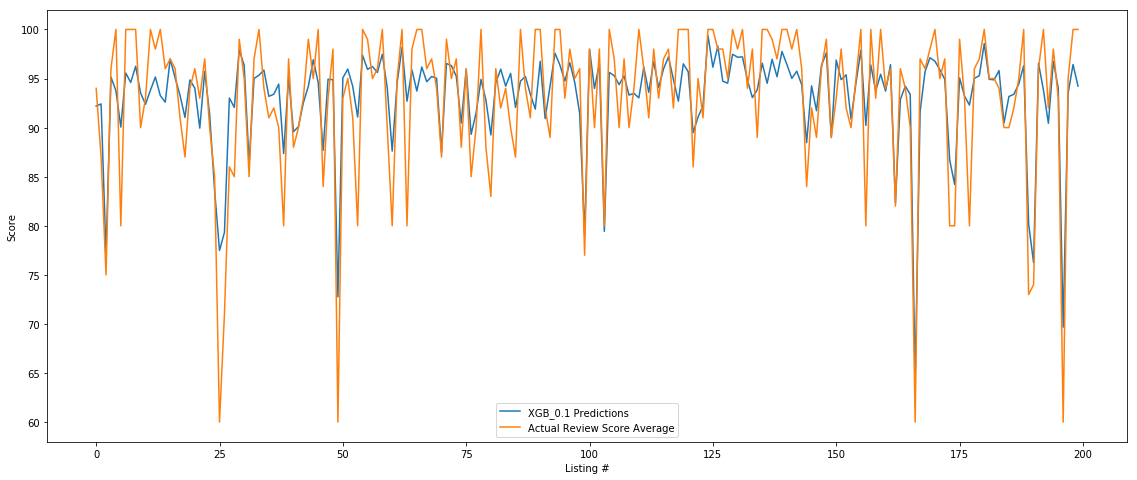

In [23]:
fig5 = plt.figure(figsize=(15,6))
ax5 = fig5.add_axes([0,0,1,1])
ax5.plot(yhat_test[0:200], label='XGB_0.1 Predictions')
ax5.plot(y_test[0:200].reset_index().drop('index',axis=1),label='Actual Review Score Average')
ax5.legend()
ax5.set_ylabel('Score')
ax5.set_xlabel('Listing #')
## Save figure
fig5.savefig('png/Yhat_xgbvsactual.png', bbox_inches='tight');